# 1. モジュールインポート

In [22]:
import pandas as pd
import glob
import os
import datetime
from tqdm.auto import tqdm
from modules.constants import Master
from modules.constants import LocalPaths
from modules.constants import HorseResultsCols
from modules.constants import ResultsCols
from modules import preparing
from modules import preprocessing
from modules import training
from modules import simulation
from modules import policies
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# エンコーディング設定の確認
import sys
import locale

print("=== エンコーディング設定確認 ===")
print(f"sys.getdefaultencoding(): {sys.getdefaultencoding()}")
print(f"sys.getfilesystemencoding(): {sys.getfilesystemencoding()}")
print(f"locale.getpreferredencoding(): {locale.getpreferredencoding()}")
print(f"PYTHONUTF8 環境変数: {sys.flags.utf8_mode}")

標準的な土日競馬開催時の運用スケジュールを以下の表の通り。

|曜日|時刻|内容|実行する main.ipynb の項番|備考|
|:-:|:--|:--|:--|:--|
|月|||||
|火|||||
|水|16:30過ぎ|先週土日の馬の過去成績ページ確定<BR>（netkeiba.comﾌﾟﾚﾐｱｻｰﾋﾞｽのﾀｲﾑ指数・ﾚｰｽ分析・注目馬 ﾚｰｽ後の短評情報確定）|2. データ取得 ～ 5. シミュレーション|3日間開催の場合も、水曜日|
|木|||||
|金|10:05過ぎ<BR>19:25過ぎ|土曜の出馬表確定<BR>土曜の天候・馬場状態更新|6.1. 前日準備 ～ 6.2. 前日全レース予想（天候・馬場状態は手動設定）<BR>6.1. 前日準備 ～ 6.2. 前日全レース予想||
|土|09:00～17:00<BR>10:05過ぎ<BR>19:25過ぎ| レース時刻<BR>日曜の出馬表確定<BR>日曜の天候・馬場状態更新|6.3. レース直前データ処理（当日レース予想）<BR>6.1. 前日準備 ～ 6.2. 前日全レース予想（天候・馬場状態は手動設定）<BR>6.1. 前日準備 ～ 6.2. 前日全レース予想||
|日|09:00～17:00|レース時刻|6.3. レース直前データ処理（当日レース予想）||

# 2. データ取得

## 2.1. レースID取得
例として、2020年のレースデータを取得する場合を考える

In [ ]:
%autoreload

In [ ]:
#開催日取得。to_の月は含まないので注意。
kaisai_date_2025 = preparing.scrape_kaisai_date(from_="2025-12-01", to_="2026-01-01")
len(kaisai_date_2025)

In [ ]:
# 開催日からレースIDの取得
race_id_list = preparing.scrape_race_id_list(kaisai_date_2025)
len(race_id_list)

## 2.2. /race/ディレクトリのデータ取得

In [ ]:
#https://db.netkeiba.com/race/のhtml(binファイル)をスクレイピングして保存
html_files_race = preparing.scrape_html_race(race_id_list, skip=False)
html_files_race[:5]

In [ ]:
# data/html/race/に保存されているhtml(binファイル)をリストにする
import glob
import os

# LocalPathsからHTMLレースディレクトリを取得
race_html_dir = LocalPaths.HTML_RACE_DIR
print(f"レースHTMLディレクトリ: {race_html_dir}")

# globでbinファイルを検索
html_files_race = glob.glob(os.path.join(race_html_dir, "*.bin"))
print(f"見つかったHTMLファイル数: {len(html_files_race)}")

# 最初の5ファイルを表示
html_files_race[:5]
html_files_race[:5]

In [ ]:
# 変数確認
print(f"html_files_race変数の状態:")
print(f"  タイプ: {type(html_files_race)}")
print(f"  サイズ: {len(html_files_race)}")
print(f"  範囲: {html_files_race[0].split('\\')[-1]} ～ {html_files_race[-1].split('\\')[-1]}")

# これで次のセルでget_rawdata_results関数を正常に実行できます

In [ ]:
results_new = preparing.get_rawdata_results(html_files_race) #レース結果テーブルの作成
race_info_new = preparing.get_rawdata_info(html_files_race) #レース情報テーブルの作成
return_tables_new = preparing.get_rawdata_return(html_files_race) #払戻テーブルの作成

In [ ]:
# テーブルの更新。元々のテーブルが存在しない場合は、新たに作成される。
preparing.update_rawdata(filepath=LocalPaths.RAW_RESULTS_PATH, new_df=results_new)
preparing.update_rawdata(filepath=LocalPaths.RAW_RACE_INFO_PATH, new_df=race_info_new)
preparing.update_rawdata(filepath=LocalPaths.RAW_RETURN_TABLES_PATH, new_df=return_tables_new)

## 2.x. 生成済み raw テーブル確認
`data/raw` に保存された各pickleの基本情報を表示します。存在しない場合はスキップします。

In [ ]:
# data/raw 配下の pickle テーブル概要確認 + null率集計
import os
import pathlib
import pandas as pd
import datetime as dt
from modules.constants import LocalPaths

RAW_DIR = pathlib.Path('data/raw')

if not RAW_DIR.exists():
    print(f'ディレクトリが存在しません: {RAW_DIR.resolve()}')
else:
    pickle_files = sorted(RAW_DIR.glob('*.pickle'))
    if not pickle_files:
        print('pickleファイルが見つかりません。先に取得処理を実行してください。')
    else:
        summaries = []
        null_detail_rows = []  # 列単位 null 率詳細
        for p in pickle_files:
            info = {
                'file': p.name,
                'size_MB': round(p.stat().st_size / 1_000_000, 3)
            }
            try:
                df = pd.read_pickle(p)
                info['rows'] = len(df)
                info['cols'] = df.shape[1]
                info['memory_MB'] = round(df.memory_usage(deep=True).sum() / 1_000_000, 3)
                # 代表的なカラムサンプル（最大5件）
                info['sample_cols'] = ', '.join(list(df.columns[:5]))
                # 日付らしき列から範囲を取得
                date_cols = [c for c in df.columns if 'date' in c.lower()]
                date_range = ''
                for dc in date_cols:
                    try:
                        s = pd.to_datetime(df[dc], errors='coerce')
                        if s.notna().any():
                            date_range = f"{dc}:{s.min().date()}→{s.max().date()}"
                            break
                    except Exception:
                        pass
                info['date_range'] = date_range
                # 全体 null 率（セル全体）
                total_cells = df.shape[0] * (df.shape[1] if df.shape[0] else 0)
                info['overall_null_pct'] = round((df.isna().sum().sum() / total_cells) * 100, 2) if total_cells else 0.0
                # 列ごとの null 率
                col_null_pct = (df.isna().mean() * 100).sort_values(ascending=False)
                # 上位10列を詳細に保存（列が10未満なら全て）
                for col, pct in col_null_pct.head(10).items():
                    null_detail_rows.append({
                        'file': p.name,
                        'column': col,
                        'null_pct': round(pct, 2)
                    })
                # 列単位統計（最大値/平均値/中央値）
                info['max_col_null_pct'] = round(col_null_pct.iloc[0], 2) if not col_null_pct.empty else 0.0
                info['mean_col_null_pct'] = round(col_null_pct.mean(), 2) if not col_null_pct.empty else 0.0
                info['median_col_null_pct'] = round(col_null_pct.median(), 2) if not col_null_pct.empty else 0.0
            except Exception as e:
                info['rows'] = 'ERR'
                info['cols'] = 'ERR'
                info['memory_MB'] = 'ERR'
                info['sample_cols'] = f'load error: {e.__class__.__name__}'
                info['date_range'] = ''
                info['overall_null_pct'] = 'ERR'
                info['max_col_null_pct'] = 'ERR'
                info['mean_col_null_pct'] = 'ERR'
                info['median_col_null_pct'] = 'ERR'
            summaries.append(info)
        summary_df = pd.DataFrame(summaries)
        # 表示順を調整
        summary_cols_order = [
            'file','rows','cols','size_MB','memory_MB','overall_null_pct',
            'max_col_null_pct','mean_col_null_pct','median_col_null_pct',
            'sample_cols','date_range'
        ]
        summary_df = summary_df[summary_cols_order]
        display(summary_df)

        if null_detail_rows:
            null_detail_df = pd.DataFrame(null_detail_rows)
            # ファイル毎に null の高い列を横持ち要約（pivot）するオプション（必要であれば）
            display(null_detail_df)

        # 主要パスが指すファイルの存在と行数確認（存在しない場合も出力）
        main_paths = {
            'RAW_RESULTS_PATH': getattr(LocalPaths, 'RAW_RESULTS_PATH', None),
            'RAW_RACE_INFO_PATH': getattr(LocalPaths, 'RAW_RACE_INFO_PATH', None),
            'RAW_RETURN_TABLES_PATH': getattr(LocalPaths, 'RAW_RETURN_TABLES_PATH', None),
            'RAW_HORSE_INFO_PATH': getattr(LocalPaths, 'RAW_HORSE_INFO_PATH', None),
            'RAW_HORSE_RESULTS_PATH': getattr(LocalPaths, 'RAW_HORSE_RESULTS_PATH', None),
            'RAW_PEDS_PATH': getattr(LocalPaths, 'RAW_PEDS_PATH', None)
        }
        path_rows = []
        for key, path in main_paths.items():
            if path is None:
                path_rows.append({'name': key, 'path': None, 'exists': False, 'rows': None})
                continue
            exists = os.path.isfile(path)
            rows = None
            if exists:
                try:
                    rows = len(pd.read_pickle(path))
                except Exception:
                    rows = 'ERR'
            path_rows.append({'name': key, 'path': path, 'exists': exists, 'rows': rows})
        display(pd.DataFrame(path_rows))

In [ ]:
# 既存のresultsデータを読み込んでテスト用horse_idリストを取得
results_new = pd.read_pickle(LocalPaths.RAW_RESULTS_PATH)
print(f"results_new loaded: {results_new.shape}")

# 先頭10頭のテスト用リスト作成
horse_id_list = results_new['horse_id'].unique()
horse_id_test_list = horse_id_list[:10]
print(f"テスト用horse_id: {horse_id_test_list}")

## 2.3. /horse/ディレクトリのデータ取得

In [ ]:
%autoreload

In [ ]:
# マスターファイルにNaN値が含まれているものだけ再スクレイピングする
import pandas as pd
import os
from modules.constants import LocalPaths

# マスターファイルからNaN値を持つhorse_idを特定
master_files = {
    'horse_id': 'horse_id.csv',
    'jockey_id': 'jockey_id.csv', 
    'trainer_id': 'trainer_id.csv',
    'owner_id': 'owner_id.csv',
    'breeder_id': 'breeder_id.csv'
}

nan_horse_ids = set()
print("=== マスターファイルのNaN値チェック ===")

# horse_info.pickleを読み込み
try:
    horse_info = pd.read_pickle(os.path.join(LocalPaths.RAW_DIR, 'horse_info.pickle'))
    print(f"horse_info.pickle読み込み完了: {len(horse_info)}頭の馬データ")
except Exception as e:
    print(f"horse_info.pickleの読み込みエラー: {e}")
    horse_info = None

# 各マスターファイルをチェック
for master_type, filename in master_files.items():
    filepath = os.path.join(LocalPaths.MASTER_DIR, filename)
    if os.path.exists(filepath):
        df = pd.read_csv(filepath)
        id_col = df.columns[0]
        
        # NaN値を持つ行を特定
        nan_rows = df[df[id_col].isna()]
        if len(nan_rows) > 0:
            print(f"\n{master_type}: {len(nan_rows)}個のNaN値を発見")
            
            if horse_info is not None:
                if master_type == 'horse_id':
                    # horse_idが直接NaNの場合（これは通常起こらない）
                    print(f"  -> horse_idが直接NaNになっている行: {len(nan_rows)}")
                else:
                    # 他のIDがNaNの馬を特定
                    col_mapping = {
                        'jockey_id': '騎手',
                        'trainer_id': '調教師', 
                        'owner_id': '馬主',
                        'breeder_id': '生産者'
                    }
                    if master_type in col_mapping:
                        target_col = col_mapping[master_type]
                        if target_col in horse_info.columns:
                            # 該当する列がNaNまたは空文字の馬を特定
                            nan_horses = horse_info[
                                (horse_info[target_col].isna()) | 
                                (horse_info[target_col] == '') |
                                (horse_info[target_col] == 'nan')
                            ]
                            for horse_id in nan_horses.index:
                                nan_horse_ids.add(horse_id)
                            print(f"  -> {target_col}がNaN/空の馬: {len(nan_horses)}頭")
                            if len(nan_horses) > 0:
                                print(f"      例: {list(nan_horses.index)[:5]}")
    else:
        print(f"{master_type}: ファイルが存在しません")

print(f"\n=== 再スクレイピング対象の特定結果 ===")
print(f"再スクレイピングが必要な馬ID数: {len(nan_horse_ids)}")

if len(nan_horse_ids) > 0:
    nan_horse_ids_list = sorted(list(nan_horse_ids))
    print(f"対象馬ID例: {nan_horse_ids_list[:10]}{'...' if len(nan_horse_ids_list) > 10 else ''}")
    
    print(f"\n=== 再スクレイピング実行オプション ===")
    print("以下の変数を設定して次のセルで実行してください：")
    print("re_scrape_horses = True  # この行のコメントアウトを外して実行")
    print("target_horse_ids = nan_horse_ids_list  # 対象馬IDリスト")
    
    # 変数を保存（次のセルで使用）
    globals()['nan_horse_ids_list'] = nan_horse_ids_list
    globals()['re_scrape_needed'] = True
else:
    print("再スクレイピングが必要な馬は見つかりませんでした。")
    globals()['re_scrape_needed'] = False

In [ ]:
# horse_id_listのうち先頭10頭の馬のリストを作成し、スクレイピングテストする
horse_id_list = results_new['horse_id'].unique()
horse_id_test_list = horse_id_list[:10]  # 先頭10頭でテスト

print(f"全体の馬数: {len(horse_id_list)}")
print(f"テスト対象の馬数: {len(horse_id_test_list)}")
print(f"テスト対象馬ID: {horse_id_test_list}")

#htmlをスクレイピング
#すでにスクレイピングしてある馬をスキップしたい場合はskip=Trueにする
#すでにスクレイピングしてある馬でも、新たに出走した成績を更新したい場合はskip=Falseにする
html_files_horse = preparing.scrape_html_horse_with_master(
    horse_id_test_list, skip=False
    )

In [ ]:
horse_id_list = results_new['horse_id'].unique()
#htmlをスクレイピング
#すでにスクレイピングしてある馬をスキップしたい場合はskip=Trueにする
#すでにスクレイピングしてある馬でも、新たに出走した成績を更新したい場合はskip=Falseにする
html_files_horse = preparing.scrape_html_horse_with_master(
    horse_id_list, skip=True
    )

In [ ]:
#追加で新たにスクレイピングされた数
len(html_files_horse)

In [ ]:
### scrape関数を実行せずに、保存してあるhtmlのパスを取得する場合、以下を実行 ###

target_date = '2025-09-20' #スクレイピングした日付を指定
# マスタの読み込み
update_master = pd.read_csv(
    LocalPaths.MASTER_RAW_HORSE_RESULTS_PATH,
    dtype=object
    )
# target_dateにスクレイピングしたhorse_idに絞り込む
filter = pd.to_datetime(update_master['updated_at']).dt.strftime('%Y-%m-%d') == target_date
horse_id_list = update_master[filter]['horse_id']

# binファイルのパスを取得
html_files_horse = []
for horse_id in tqdm(horse_id_list):
    file = glob.glob(os.path.join(LocalPaths.HTML_HORSE_DIR, horse_id+'*.bin'))[0]
    html_files_horse.append(file)
html_files_horse[:5]

In [ ]:
# マスターファイルにNaN値が含まれているものだけ再スクレイピングする


In [ ]:
# 再スクレイピング実行（上のセルで特定されたNaN馬のみ）
# 実行する場合は下の行のコメントアウトを外してください
# re_scrape_horses = True

if 're_scrape_horses' in locals() and re_scrape_horses and 're_scrape_needed' in globals() and re_scrape_needed:
    print("=== NaN値を持つ馬の再スクレイピング開始 ===")
    print(f"対象馬数: {len(nan_horse_ids_list)}")
    
    # 進捗表示用
    from tqdm import tqdm
    import time
    
    success_count = 0
    failed_ids = []
    
    for i, horse_id in enumerate(tqdm(nan_horse_ids_list, desc="再スクレイピング")):
        try:
            # 馬情報をスクレイピング
            scrape_horse_html(horse_id)
            success_count += 1
            
            # サーバー負荷軽減のため少し待機
            if i % 10 == 0 and i > 0:
                time.sleep(1)
                
        except Exception as e:
            print(f"エラー - 馬ID {horse_id}: {e}")
            failed_ids.append(horse_id)
            continue
    
    print(f"\n=== 再スクレイピング完了 ===")
    print(f"成功: {success_count}頭")
    print(f"失敗: {len(failed_ids)}頭")
    
    if failed_ids:
        print(f"失敗した馬ID: {failed_ids[:10]}{'...' if len(failed_ids) > 10 else ''}")
    
    print("\n再スクレイピング完了後は、該当セクションのデータ処理を再実行してください。")
    
elif 're_scrape_needed' in globals() and not re_scrape_needed:
    print("再スクレイピングが必要な馬は見つかりませんでした。")
    
else:
    print("再スクレイピングを実行するには以下を設定してください：")
    print("1. 上のセルを実行してNaN馬を特定")
    print("2. 're_scrape_horses = True' のコメントアウトを外す")
    print("3. このセルを再実行")

In [ ]:
# 再スクレイピング後のデータ再処理
# 上の再スクレイピングが完了した後に実行してください
# reprocess_data = True  # コメントアウトを外して実行

if 'reprocess_data' in locals() and reprocess_data:
    print("=== 再スクレイピング後のデータ再処理開始 ===")
    
    # 1. 新しくスクレイピングしたHTMLから馬情報を再抽出
    print("1. 馬情報の再抽出...")
    from modules.preprocessing._horse_info_processor import HorseInfoProcessor
    
    # 新しいHTMLファイルのみ処理
    html_files_horse_new = []
    for horse_id in nan_horse_ids_list:
        html_file = os.path.join(LocalPaths.HTML_HORSE_DIR, f"{horse_id}.bin")
        if os.path.exists(html_file):
            html_files_horse_new.append(html_file)
    
    print(f"再処理対象HTMLファイル数: {len(html_files_horse_new)}")
    
    if len(html_files_horse_new) > 0:
        # 馬情報を再処理
        horse_info_processor = HorseInfoProcessor(html_files_horse_new)
        horse_info_new = horse_info_processor.scrape_horse_info()
        
        # 既存の馬情報に新しい情報をマージ
        try:
            horse_info_existing = pd.read_pickle(os.path.join(LocalPaths.RAW_DIR, 'horse_info.pickle'))
            # 新しい情報で既存の情報を更新
            horse_info_updated = horse_info_existing.copy()
            for horse_id in horse_info_new.index:
                horse_info_updated.loc[horse_id] = horse_info_new.loc[horse_id]
            
            # バックアップ作成
            horse_info_existing.to_pickle(os.path.join(LocalPaths.RAW_DIR, 'horse_info.pickle.bak'))
            
            # 更新されたデータを保存
            horse_info_updated.to_pickle(os.path.join(LocalPaths.RAW_DIR, 'horse_info.pickle'))
            
            print(f"馬情報更新完了: {len(horse_info_new)}頭の情報を更新")
            
        except Exception as e:
            print(f"馬情報の更新エラー: {e}")
    
    # 2. マスターファイルの再生成
    print("\n2. マスターファイルの再生成...")
    
    # horse_info.pickleから各種IDを抽出してマスターファイルを更新
    try:
        horse_info_updated = pd.read_pickle(os.path.join(LocalPaths.RAW_DIR, 'horse_info.pickle'))
        
        # 各マスターファイルを更新
        id_columns = {
            'horse_id.csv': ('index', 'horse_id'),  # インデックスがhorse_id
            'jockey_id.csv': ('騎手', 'jockey_id'),
            'trainer_id.csv': ('調教師', 'trainer_id'),
            'owner_id.csv': ('馬主', 'owner_id'),
            'breeder_id.csv': ('生産者', 'breeder_id')
        }
        
        for master_file, (col_name, id_type) in id_columns.items():
            master_path = os.path.join(LocalPaths.MASTER_DIR, master_file)
            
            if col_name == 'index':
                # horse_idの場合
                unique_ids = horse_info_updated.index.dropna().unique()
            else:
                # その他のIDの場合
                if col_name in horse_info_updated.columns:
                    unique_ids = horse_info_updated[col_name].dropna().unique()
                    unique_ids = [str(x) for x in unique_ids if str(x) not in ['nan', 'NaN', '']]
                else:
                    continue
            
            # 既存のマスターファイルを読み込み
            if os.path.exists(master_path):
                existing_master = pd.read_csv(master_path)
                existing_ids = set(existing_master.iloc[:, 0].dropna().astype(str))
            else:
                existing_ids = set()
                existing_master = pd.DataFrame(columns=[id_type, 'encoded_id'])
            
            # 新しいIDを追加
            new_ids = [id for id in unique_ids if str(id) not in existing_ids]
            
            if new_ids:
                # 新しいエンコードIDを生成
                max_encoded = existing_master['encoded_id'].max() if len(existing_master) > 0 else -1
                new_encoded = list(range(max_encoded + 1, max_encoded + 1 + len(new_ids)))
                
                # 新しいエントリを作成
                new_entries = pd.DataFrame({
                    id_type: new_ids,
                    'encoded_id': new_encoded
                })
                
                # マスターファイルを更新
                updated_master = pd.concat([existing_master, new_entries], ignore_index=True)
                updated_master.to_csv(master_path, index=False)
                
                print(f"{master_file}: {len(new_ids)}個の新しいIDを追加")
        
        print("\nマスターファイル再生成完了！")
        print("これで特徴量エンジニアリングを再実行できます。")
        
    except Exception as e:
        print(f"マスターファイル再生成エラー: {e}")
        
else:
    print("データ再処理を実行するには 'reprocess_data = True' を設定してください")

## 再スクレイピング機能の使い方

### 手順:
1. **NaN値検出**: セル24を実行してマスターファイル内のNaN値を特定
2. **再スクレイピング実行**: セル25で `re_scrape_horses = True` のコメントアウトを外して実行
3. **データ再処理**: セル26で `reprocess_data = True` のコメントアウトを外して実行

### 注意事項:
- 再スクレイピングには時間がかかる場合があります
- サーバー負荷軽減のため、適度な間隔で実行されます
- バックアップファイルが自動生成されます

In [ ]:
# data/html/horse/に保存されているhtml(binファイル)をリストにする

import glob
import os

horse_html_dir = LocalPaths.HTML_HORSE_DIR
print(f"馬HTMLディレクトリ: {horse_html_dir}")

html_files_horse = glob.glob(os.path.join(horse_html_dir, "*.bin"))
print(f"見つかったHTMLファイル数: {len(html_files_horse)}")

# 最初の5ファイルを表示
html_files_horse[:5]


In [ ]:
# 馬の基本情報テーブルの作成（修正済み関数使用）
%autoreload
horse_info_new = preparing.get_rawdata_horse_info(html_files_horse)

In [ ]:
# get_rawdata_horse_info関数のデバッグ: 1つのHTMLファイルで詳細確認
import pandas as pd
import re
from bs4 import BeautifulSoup
from numpy import nan as NaN

# テスト用に1つのHTMLファイルを選択
test_html_file = html_files_horse[0]
print(f"テスト対象ファイル: {test_html_file}")

# ファイルを読み込み
with open(test_html_file, 'rb') as f:
    html = f.read()

# horse_idを取得
horse_id = re.findall(r'horse\W(\d+)\.bin', test_html_file)[0]
print(f"horse_id: {horse_id}")

# HTMLファイルサイズとデコード確認
print(f"HTMLファイルサイズ: {len(html)} bytes")

# EUC-JPでデコード試行
for enc in ('euc-jp', 'cp932', 'utf-8'):
    try:
        text = html.decode(enc)
        print(f"デコード成功: {enc}")
        break
    except Exception as e:
        print(f"デコード失敗 {enc}: {e}")
        text = html.decode(enc, errors='ignore')
        print(f"エラー無視でデコード: {enc}")
        break

# BeautifulSoupで解析
soup = BeautifulSoup(text, 'lxml')
print(f"BeautifulSoup解析完了")

# プロフィールテーブルの確認
prof_table = (
    soup.select_one('table.db_prof_table[summary*="プロフィール"]')
    or soup.find('table', attrs={'summary': re.compile('プロフィール')})
)

if prof_table:
    print("プロフィールテーブル発見!")
    print(f"テーブルHTML（最初の500文字）: {str(prof_table)[:500]}")
    
    # テーブルを読み込む
    try:
        df = pd.read_html(str(prof_table), flavor='lxml')[0]
        print(f"DataFrame形状: {df.shape}")
        print(f"DataFrame列名: {list(df.columns)}")
        print("DataFrame内容:")
        display(df)
        
        # 2列形式の確認
        if df.shape[1] >= 2:
            df = df.iloc[:, :2]
            df.columns = ['項目', '値']
            df_info = df.set_index('項目').T
            print("転置後:")
            display(df_info)
        else:
            print(f"プロフィール表の列数が想定外: {df.shape[1]}")
            
    except Exception as e:
        print(f"pd.read_htmlエラー: {e}")
else:
    print("プロフィールテーブルが見つかりません")
    # 代替手段: すべてのテーブルを確認
    print("すべてのテーブルを確認:")
    tables = soup.find_all('table')
    for i, table in enumerate(tables):
        attrs = table.attrs
        print(f"テーブル {i+1}: {attrs}")
        if i < 3:  # 最初の3テーブルの内容を確認
            try:
                df_temp = pd.read_html(str(table))[0]
                print(f"  形状: {df_temp.shape}, 列名: {list(df_temp.columns[:3])}")
                if len(df_temp) > 0:
                    print(f"  最初の行: {df_temp.iloc[0].values[:3]}")
            except Exception as e:
                print(f"  読み込みエラー: {e}")

# ID抽出の確認
def extract_id(selector, pattern):
    a = soup.select_one(selector)
    if a and a.has_attr('href'):
        m = re.search(pattern, a['href'])
        if m:
            return m.group(1)
    return NaN

trainer_id = extract_id('a[href^="/trainer/"]', r'/trainer/([^/]+)/')
owner_id   = extract_id('a[href^="/owner/"]',   r'/owner/([^/]+)/')
breeder_id = extract_id('a[href^="/breeder/"]', r'/breeder/([^/]+)/')

print(f"trainer_id: {trainer_id}")
print(f"owner_id: {owner_id}")
print(f"breeder_id: {breeder_id}")

# 関連リンクの確認
trainer_links = soup.select('a[href^="/trainer/"]')
owner_links = soup.select('a[href^="/owner/"]')
breeder_links = soup.select('a[href^="/breeder/"]')

print(f"調教師リンク数: {len(trainer_links)}")
print(f"馬主リンク数: {len(owner_links)}")
print(f"生産者リンク数: {len(breeder_links)}")

if trainer_links:
    print(f"調教師リンク例: {trainer_links[0].get('href')}")
if owner_links:
    print(f"馬主リンク例: {owner_links[0].get('href')}")
if breeder_links:
    print(f"生産者リンク例: {breeder_links[0].get('href')}")

In [ ]:
# エンコーディング問題の詳細調査（chardetなし）
# 手動で各エンコーディングを試行

encodings_to_try = ['utf-8', 'euc-jp', 'cp932', 'shift_jis', 'iso-2022-jp']

successful_encoding = None
for encoding in encodings_to_try:
    try:
        text_decoded = html.decode(encoding)
        print(f"デコード成功: {encoding}")
        
        # BeautifulSoupで解析
        soup_test = BeautifulSoup(text_decoded, 'lxml')
        
        # プロフィールテーブルの検索
        prof_table_test = (
            soup_test.find('table', class_='db_prof_table') or
            soup_test.find('table', attrs={'summary': re.compile('プロフィール')}) or
            soup_test.select_one('table[summary*="プロフィール"]')
        )
        
        if prof_table_test:
            print(f"  → プロフィールテーブル発見！エンコーディング: {encoding}")
            print(f"  → テーブル属性: {prof_table_test.attrs}")
            
            # テーブル内容を確認
            try:
                df_test = pd.read_html(str(prof_table_test))[0]
                print(f"  → DataFrame形状: {df_test.shape}")
                print("  → DataFrame内容:")
                display(df_test)
                
                # 2列形式に変換してみる
                if df_test.shape[1] >= 2:
                    df_test = df_test.iloc[:, :2]
                    df_test.columns = ['項目', '値']
                    df_info_test = df_test.set_index('項目').T
                    print("  → 転置後:")
                    display(df_info_test)
                    
                successful_encoding = encoding
                break
                
            except Exception as e:
                print(f"  → pd.read_htmlエラー: {e}")
        else:
            print(f"  → プロフィールテーブル見つからず")
            
    except UnicodeDecodeError as e:
        print(f"デコード失敗: {encoding} - {str(e)[:100]}")
        continue
    except Exception as e:
        print(f"その他のエラー {encoding}: {e}")
        continue

if successful_encoding:
    print(f"\n成功したエンコーディング: {successful_encoding}")
    
    # 正しいエンコーディングでの最終確認
    text_final = html.decode(successful_encoding)
    soup_final = BeautifulSoup(text_final, 'lxml')
    
    # すべてのテーブルを確認
    tables_final = soup_final.find_all('table')
    print(f"\n全テーブル数: {len(tables_final)}")
    for i, table in enumerate(tables_final):
        attrs = table.attrs
        summary = attrs.get('summary', '')
        class_names = attrs.get('class', [])
        print(f"テーブル {i+1}: class={class_names}, summary='{summary}'")
        
        # プロフィールらしいテーブルを詳しく確認
        if 'db_prof_table' in class_names or 'プロフィール' in summary:
            try:
                df_detail = pd.read_html(str(table))[0]
                print(f"  → 詳細形状: {df_detail.shape}")
                print(f"  → 列名: {list(df_detail.columns)}")
                if len(df_detail) > 0:
                    print(f"  → 最初の行: {df_detail.iloc[0].values}")
            except Exception as e:
                print(f"  → 読み込みエラー: {e}")
                
else:
    print("\nどのエンコーディングでもプロフィールテーブルが見つかりませんでした")
    
    # HTMLの先頭部分を確認
    print(f"\nHTML先頭500文字（バイナリ）:")
    print(html[:500])
    
    # UTF-8での強制解析
    try:
        text_force = html.decode('utf-8', errors='ignore')
        print(f"\nUTF-8強制デコード後の先頭1000文字:")
        print(text_force[:1000])
    except Exception as e:
        print(f"UTF-8強制デコードエラー: {e}")

In [ ]:
# get_rawdata_horse_info関数の修正版を作成・テスト
def get_rawdata_horse_info_fixed(html_path_list: list):
    """
    horseページのhtmlを受け取って、馬の基本情報のDataFrameに変換する関数（修正版）。
    - UTF-8優先でデコード
    - プロフィールテーブルを確実に特定
    - 調教師/馬主/生産者IDを確実に抽出
    """
    print('preparing raw horse_info table (fixed version)')
    out_rows = []

    for html_path in tqdm(html_path_list):
        try:
            with open(html_path, 'rb') as f:
                raw = f.read()

            # 1) エンコーディング優先順位: UTF-8 → EUC-JP → CP932
            text = None
            for encoding in ['utf-8', 'euc-jp', 'cp932']:
                try:
                    text = raw.decode(encoding)
                    break
                except UnicodeDecodeError:
                    continue
            
            if text is None:
                print(f'エンコーディング失敗: {html_path}')
                continue

            soup = BeautifulSoup(text, 'lxml')

            # 2) プロフィールテーブルの確実な特定
            prof_table = (
                soup.find('table', class_='db_prof_table') or
                soup.find('table', attrs={'summary': re.compile('プロフィール')}) or
                soup.select_one('table[summary*="プロフィール"]')
            )
            
            if prof_table is None:
                print(f'プロフィールテーブル見つからず: {html_path}')
                continue

            # 3) テーブルを読み込む（StringIOを使用して警告を回避）
            from io import StringIO
            df = pd.read_html(StringIO(str(prof_table)))[0]
            
            # 左列を項目名、右列を値として転置（1行化）
            if df.shape[1] >= 2:
                df = df.iloc[:, :2]
                df.columns = ['項目', '値']
                df_info = df.set_index('項目').T
            else:
                print(f'プロフィールテーブルの列数が想定外: {html_path}')
                continue

            # 4) 各IDをより確実に抽出
            def extract_id(selector, pattern):
                a = soup.select_one(selector)
                if a and a.has_attr('href'):
                    m = re.search(pattern, a['href'])
                    if m:
                        return m.group(1)
                return NaN

            trainer_id = extract_id('a[href^="/trainer/"]', r'/trainer/([^/]+)/')
            owner_id   = extract_id('a[href^="/owner/"]',   r'/owner/([^/]+)/')
            breeder_id = extract_id('a[href^="/breeder/"]', r'/breeder/([^/]+)/')

            df_info['trainer_id'] = trainer_id
            df_info['owner_id']   = owner_id
            df_info['breeder_id'] = breeder_id

            # 5) インデックスを horse_id に
            horse_id_m = re.search(r'horse\W(\d+)\.bin', html_path)
            if horse_id_m:
                horse_id = horse_id_m.group(1)
                df_info.index = [horse_id]
                out_rows.append(df_info)
            else:
                print(f'horse_id抽出失敗: {html_path}')
                
        except Exception as e:
            print(f'処理エラー {html_path}: {e}')
            continue

    if not out_rows:
        print('処理できたhorse_infoデータがありません')
        return pd.DataFrame()

    horse_info_df = pd.concat(out_rows, axis=0)
    print(f'horse_info処理完了: {horse_info_df.shape}')
    return horse_info_df

# 修正版でテスト実行
horse_info_new_fixed = get_rawdata_horse_info_fixed(html_files_horse)
print(f"\n修正版の結果: {horse_info_new_fixed.shape}")
if len(horse_info_new_fixed) > 0:
    print(f"列名: {list(horse_info_new_fixed.columns[:5])}")
    print(f"最初の数行:")
    display(horse_info_new_fixed.head())

In [ ]:
# horse_info.pickleを読み込み
try:
    horse_info = pd.read_pickle(os.path.join(LocalPaths.RAW_DIR, 'horse_info.pickle'))
    print(f"horse_info.pickle読み込み完了: {len(horse_info)}頭の馬データ")
except Exception as e:
    print(f"horse_info.pickleの読み込みエラー: {e}")
    horse_info = None

In [ ]:
# 馬の基本情報テーブルの更新
preparing.update_rawdata(LocalPaths.RAW_HORSE_INFO_PATH, horse_info)

In [ ]:
# 馬の過去成績テーブルの作成
horse_results_new = preparing.get_rawdata_horse_results(html_files_horse)

In [ ]:
# 結果確認
print(f"horse_results_new shape: {horse_results_new.shape}")
print(f"horse_results_new type: {type(horse_results_new)}")
if len(horse_results_new) > 0:
    print(f"列名: {list(horse_results_new.columns[:5])}")
    print(f"最初の数行:")
    display(horse_results_new.head())

In [ ]:
# 問題診断: 1つのHTMLファイルでpd.read_htmlの動作確認
import pandas as pd
import re
from bs4 import BeautifulSoup

# テスト用に1つのHTMLファイルを選択
test_html_file = html_files_horse[0]
print(f"テスト対象ファイル: {test_html_file}")

# ファイルを読み込み
with open(test_html_file, 'rb') as f:
    html = f.read()

# horse_idを取得
horse_id = re.findall(r'horse\W(\d+)\.bin', test_html_file)[0]
print(f"horse_id: {horse_id}")

# BeautifulSoupで解析
soup = BeautifulSoup(html, "lxml")
print(f"HTMLファイルサイズ: {len(html)} bytes")

# テーブル要素の確認
tables = soup.find_all('table')
print(f"テーブル数: {len(tables)}")

for i, table in enumerate(tables):
    class_names = table.get('class', [])
    print(f"テーブル {i+1}: class={class_names}")

# pd.read_htmlでテーブル読み込みテスト
try:
    dfs = pd.read_html(html)
    print(f"pd.read_htmlで読み込めたテーブル数: {len(dfs)}")
    
    for i, df in enumerate(dfs):
        print(f"DataFrame {i+1}: 形状={df.shape}, 列名={list(df.columns[:3])}")
        if len(df) > 0:
            print(f"  最初の行: {df.iloc[0].values[:3]}")
        print()
        
except Exception as e:
    print(f"pd.read_htmlエラー: {e}")

# 過去成績テーブルの直接確認
race_results_table = soup.find('table', class_='db_h_race_results')
if race_results_table:
    print("過去成績テーブルが見つかりました!")
    rows = race_results_table.find_all('tr')
    print(f"行数: {len(rows)}")
    if len(rows) > 1:  # ヘッダー行を除く
        first_data_row = rows[1]
        cells = first_data_row.find_all(['td', 'th'])
        print(f"最初のデータ行のセル数: {len(cells)}")
        print(f"最初のセルの内容: {cells[0].get_text(strip=True) if cells else 'なし'}")
else:
    print("過去成績テーブルが見つかりませんでした")

In [ ]:
# get_rawdata_horse_resultsの修正版をテスト
import pandas as pd
import re
from tqdm.auto import tqdm

def get_rawdata_horse_results_fixed(html_path_list: list):
    """
    horseページのhtmlを受け取って、馬の過去成績のDataFrameに変換する関数。
    AJAX実装対応版: 過去成績テーブルはインデックス1（2番目）にある
    """
    print('preparing raw horse_results table (fixed version)')
    horse_results = {}
    for html_path in tqdm(html_path_list):
        with open(html_path, 'rb') as f:
            try:
                # 保存してあるbinファイルを読み込む
                html = f.read()

                # AJAX実装では、過去成績テーブルは2番目（インデックス1）
                dfs = pd.read_html(html)
                
                # テーブル数の確認
                if len(dfs) < 2:
                    print(f'horse_results insufficient tables: {len(dfs)} tables in {html_path}')
                    continue
                
                # 過去成績テーブルは2番目（インデックス1）
                df = dfs[1]
                
                # 新馬の競走馬レビューが付いた場合、
                # 列名に0が付与されるため、次のhtmlへ飛ばす
                if df.columns[0] == 0:
                    print('horse_results empty case1 {}'.format(html_path))
                    continue

                horse_id = re.findall(r'horse\W(\d+)\.bin', html_path)[0]

                df.index = [horse_id] * len(df)
                horse_results[horse_id] = df
                print(f'Successfully processed {horse_id}: {df.shape}')

            # 競走データが無い場合（新馬）を飛ばす
            except IndexError:
                print('horse_results empty case2 {}'.format(html_path))
                continue
            except Exception as e:
                print(f'horse_results error in {html_path}: {e}')
                continue

    if not horse_results:
        print("警告: 処理できた過去成績データがありません")
        return pd.DataFrame()

    # pd.DataFrame型にして一つのデータにまとめる
    horse_results_df = pd.concat([horse_results[key] for key in horse_results])

    # 列名に半角スペースがあれば除去する
    horse_results_df = horse_results_df.rename(columns=lambda x: x.replace(' ', ''))

    return horse_results_df

# 修正版でテスト実行
horse_results_new_fixed = get_rawdata_horse_results_fixed(html_files_horse)
print(f"\n修正版の結果: {horse_results_new_fixed.shape}")
if len(horse_results_new_fixed) > 0:
    print(f"列名: {list(horse_results_new_fixed.columns[:5])}")
    print(f"最初の数行:")
    display(horse_results_new_fixed.head())

In [ ]:
# テーブルの更新
preparing.update_rawdata(LocalPaths.RAW_HORSE_RESULTS_PATH, horse_results_new)

In [ ]:
display(horse_info_new)

# 馬の基本情報テーブルの行数を取得
print(f"馬の基本情報テーブルの行数: {len(horse_info_new)}")


In [ ]:
display(horse_results_new)

### 2.3.2 特定期間の再スクレイピング

In [2]:
import pandas as pd

from modules import preparing
from modules.constants import LocalPaths

# 1) 対象期間
START = "2026-01-01"
END   = "2026-02-01"  # この日付は含めない想定（必要なら調整）

# 2) 開催日(yyyymmdd) -> レースID取得
# scrape_kaisai_date は yyyy-mm を受け取り「to_月は含まない」仕様
kaisai_date_list = preparing.scrape_kaisai_date("2026-01", "2026-02")
# 念のため日付でフィルタ（文字列比較でOK: yyyymmdd）
start_yyyymmdd = START.replace("-", "")
end_yyyymmdd   = END.replace("-", "")
kaisai_date_list = [d for d in kaisai_date_list if start_yyyymmdd <= d < end_yyyymmdd]

race_id_list = preparing.scrape_race_id_list(kaisai_date_list)
race_id_list = sorted(set(race_id_list))
print("race_id count:", len(race_id_list))

# 3) レースHTMLを再取得（skip=False で上書き）
race_html_paths = preparing.scrape_html_race(race_id_list, skip=False)
print("race html updated:", len(race_html_paths))

# 4) レース結果→出走馬ID抽出
results_new = preparing.get_rawdata_results(race_html_paths)
horse_id_list = sorted(set(results_new["horse_id"].dropna().astype(str).tolist()))
print("horse_id count:", len(horse_id_list))

# （任意だが推奨）レース系rawも同時に更新して整合を取る
race_info_new = preparing.get_rawdata_info(race_html_paths)
return_new = preparing.get_rawdata_return(race_html_paths)

preparing.update_rawdata(LocalPaths.RAW_RESULTS_PATH, results_new, mode="replace")
preparing.update_rawdata(LocalPaths.RAW_RACE_INFO_PATH, race_info_new, mode="replace")
preparing.update_rawdata(LocalPaths.RAW_RETURN_TABLES_PATH, return_new, mode="replace")

# 5) 馬ページ（戦績断片を挿入する実装）を再取得して、更新日時マスタも更新
horse_html_paths = preparing.scrape_html_horse_with_master(horse_id_list, skip=False)
print("horse html updated:", len(horse_html_paths))

# 6) horse_info / horse_results を作ってraw pickle更新
horse_info_new = preparing.get_rawdata_horse_info(horse_html_paths)
horse_results_new = preparing.get_rawdata_horse_results(horse_html_paths)

preparing.update_rawdata(LocalPaths.RAW_HORSE_INFO_PATH, horse_info_new, mode="replace")
preparing.update_rawdata(LocalPaths.RAW_HORSE_RESULTS_PATH, horse_results_new, mode="replace")

print("done")

getting race date from 2026-01 to 2026-02
Date range created: 1 months to process


  0%|          | 0/1 [00:00<?, ?it/s]

getting race_id_list


  0%|          | 0/5 [00:00<?, ?it/s]

scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20260104
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20260105
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20260110
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20260111
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20260112
race_id count: 120


  0%|          | 0/120 [00:00<?, ?it/s]

race html updated: 120
preparing raw results table


  0%|          | 0/120 [00:00<?, ?it/s]

error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202606010301.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202606010302.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202606010303.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202606010304.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202606010305.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202606010306.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202606010307.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202606010308.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202606010309.bin
list index out of range
e

  0%|          | 0/120 [00:00<?, ?it/s]

preparing raw return table


  0%|          | 0/120 [00:00<?, ?it/s]

error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202606010301.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202606010302.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202606010303.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202606010304.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202606010305.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202606010306.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202606010307.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202606010308.bin
list index out of range
error at c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\race\202606010309.bin
list index out of range
e

  0%|          | 0/666 [00:00<?, ?it/s]

updating master
horse html updated: 666
preparing raw horse_info table


  0%|          | 0/666 [00:00<?, ?it/s]

preparing raw horse_results table


  0%|          | 0/666 [00:00<?, ?it/s]

置換モード: 保持 20394 + 置換 666 = 合計 21060 レコード
データ更新完了: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\raw\horse_info.pickle
置換モード: 保持 17099118 + 置換 6508 = 合計 17105626 レコード
データ更新完了: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\raw\horse_results.pickle
done


## 2.4. /ped/ディレクトリのデータ取得

In [3]:
html_files_peds = preparing.scrape_html_ped(horse_id_list, skip=True) #htmlをスクレイピング

  0%|          | 0/666 [00:00<?, ?it/s]

horse_id 2016102175 skipped
horse_id 2017106372 skipped
horse_id 2017110138 skipped
horse_id 2018102020 skipped
horse_id 2018103368 skipped
horse_id 2018103535 skipped
horse_id 2018103590 skipped
horse_id 2018103926 skipped
horse_id 2018104225 skipped
horse_id 2018105047 skipped
horse_id 2018106693 skipped
horse_id 2018110149 skipped
horse_id 2019100318 skipped
horse_id 2019100326 skipped
horse_id 2019100965 skipped
horse_id 2019101488 skipped
horse_id 2019101507 skipped
horse_id 2019101847 skipped
horse_id 2019102341 skipped
horse_id 2019102421 skipped
horse_id 2019102937 skipped
horse_id 2019103219 skipped
horse_id 2019103442 skipped
horse_id 2019103823 skipped
horse_id 2019103825 skipped
horse_id 2019104091 skipped
horse_id 2019104092 skipped
horse_id 2019104116 skipped
horse_id 2019104128 skipped
horse_id 2019104141 skipped
horse_id 2019104169 skipped
horse_id 2019104732 skipped
horse_id 2019104805 skipped
horse_id 2019104928 skipped
horse_id 2019105239 skipped
horse_id 2019105287 

In [ ]:
# === 血統データ完全スクレイピングの実装 ===
import os
from modules.preparing import scrape_html_ped

# 1. 全てのHTMLファイルから完全な馬IDリストを作成
complete_horse_id_list = [os.path.splitext(os.path.basename(f))[0] for f in html_files_horse]
print(f"完全な馬IDリスト作成完了: {len(complete_horse_id_list)}件")

# 2. 既存の血統データを確認
existing_peds_ids = set([os.path.splitext(os.path.basename(f))[0] for f in html_files_peds])
print(f"既存の血統データ: {len(existing_peds_ids)}件")

# 3. 不足している血統データのIDを特定
missing_ped_ids = set(complete_horse_id_list) - existing_peds_ids
missing_ped_ids_list = sorted(list(missing_ped_ids))
print(f"不足している血統データ: {len(missing_ped_ids_list)}件")

# 4. 年代別の不足状況確認
missing_by_year = {}
for horse_id in missing_ped_ids_list:
    year = horse_id[:4] if horse_id[:4].isdigit() else "unknown"
    missing_by_year[year] = missing_by_year.get(year, 0) + 1

print(f"\n年代別の不足血統データ:")
for year in sorted(missing_by_year.keys()):
    print(f"  {year}年: {missing_by_year[year]}件")

print(f"\n=== スクレイピング実行 ===")
print(f"対象馬数: {len(missing_ped_ids_list)}件")
print(f"推定時間: {len(missing_ped_ids_list) * 2 / 60:.1f}分")

# 5. 不足している血統データをスクレイピング実行
# 警告: これは時間がかかる処理です（約163分）
# バッチ処理で実行することを推奨
print("\n血統データスクレイピングを開始...")
new_ped_files = scrape_html_ped(missing_ped_ids_list, skip=False)
print(f"スクレイピング完了: {len(new_ped_files)}件の新しい血統データを取得")

# 6. 結果確認
import glob
updated_html_files_peds = glob.glob(os.path.join(LocalPaths.HTML_PED_DIR, "*.bin"))
print(f"更新後の血統データファイル数: {len(updated_html_files_peds)}")
print(f"馬情報ファイル数: {len(html_files_horse)}")
print(f"差分: {len(html_files_horse) - len(updated_html_files_peds)}")

In [ ]:
# まず少数でテスト（最初の100件）
test_missing_ids = missing_ped_ids_list[:100]
print(f"テスト対象: {len(test_missing_ids)}件")
test_ped_files = scrape_html_ped(test_missing_ids, skip=False)
print(f"テスト完了: {len(test_ped_files)}件")

# 成功を確認後、残りを実行
remaining_ids = missing_ped_ids_list[100:]
remaining_ped_files = scrape_html_ped(remaining_ids, skip=False)

In [ ]:
# 血統データスクレイピングのテスト: 少数の馬でテスト実行
# 先頭5頭の馬IDを使用してテスト
test_horse_ids = horse_id_test_list[:5]  # 最初の5頭でテスト
print(f"テスト対象馬ID: {test_horse_ids}")

%autoreload

In [ ]:
# 血統HTMLファイルのスクレイピングテスト（5頭のみ）
print("血統HTMLファイルのスクレイピングを開始...")
html_files_peds_test = preparing.scrape_html_ped(test_horse_ids, skip=False)
print(f"スクレイピング完了: {len(html_files_peds_test)}件のHTMLファイル")

# 取得されたファイルパスの確認
if html_files_peds_test:
    print("取得されたファイル:")
    for i, file_path in enumerate(html_files_peds_test[:3]):  # 最初の3件表示
        print(f"  {i+1}: {file_path}")
    if len(html_files_peds_test) > 3:
        print(f"  ... 他{len(html_files_peds_test)-3}件")
else:
    print("取得されたHTMLファイルがありません（既存ファイルがスキップされた可能性）")

In [ ]:
# 血統テーブルの作成テスト
print("血統テーブルの作成を開始...")
peds_test = preparing.get_rawdata_peds(html_files_peds_test)

print(f"血統テーブル作成完了: {peds_test.shape}")
if len(peds_test) > 0:
    print(f"列名: {list(peds_test.columns)}")
    print("血統データサンプル:")
    display(peds_test.head())
    
    # 各列のnull値確認
    print("\n各列のnull値の数:")
    print(peds_test.isnull().sum())
else:
    print("血統テーブルが空です。HTMLファイルの構造を確認します。")

In [ ]:
# 血統HTMLファイルの構造解析
import re
from bs4 import BeautifulSoup

# テスト用に1つの血統HTMLファイルを詳しく調べる
test_ped_file = html_files_peds_test[0]
print(f"解析対象ファイル: {test_ped_file}")

# ファイルを読み込み
with open(test_ped_file, 'rb') as f:
    ped_html = f.read()

print(f"HTMLファイルサイズ: {len(ped_html)} bytes")

# エンコーディングテスト
encodings = ['utf-8', 'euc-jp', 'cp932']
ped_text = None
successful_encoding = None

for encoding in encodings:
    try:
        ped_text = ped_html.decode(encoding)
        successful_encoding = encoding
        print(f"デコード成功: {encoding}")
        break
    except UnicodeDecodeError:
        print(f"デコード失敗: {encoding}")
        continue

if ped_text:
    # BeautifulSoupで解析
    ped_soup = BeautifulSoup(ped_text, 'lxml')
    
    # HTMLの基本情報
    title = ped_soup.find('title')
    print(f"ページタイトル: {title.text if title else 'なし'}")
    
    # テーブル要素の確認
    tables = ped_soup.find_all('table')
    print(f"テーブル数: {len(tables)}")
    
    for i, table in enumerate(tables[:5]):  # 最初の5テーブルを確認
        attrs = table.attrs
        class_names = attrs.get('class', [])
        summary = attrs.get('summary', '')
        print(f"テーブル {i+1}: class={class_names}, summary='{summary}'")
        
        # テーブル内容の簡単な確認
        try:
            df_ped = pd.read_html(str(table))[0]
            print(f"  形状: {df_ped.shape}")
            if len(df_ped) > 0 and df_ped.shape[1] > 0:
                print(f"  列名: {list(df_ped.columns[:3])}")
                print(f"  最初の行: {df_ped.iloc[0].values[:3]}")
        except Exception as e:
            print(f"  読み込みエラー: {e}")
        
        # 血統らしいキーワードを含むテーブルかチェック
        table_text = table.get_text()
        if any(keyword in table_text for keyword in ['父', '母', '祖父', '血統']):
            print(f"  → 血統関連テーブルの可能性あり")
    
    # 血統ツリー構造の確認（td要素のクラス名など）
    print("\n血統ツリー関連の要素:")
    bloodline_elements = ped_soup.find_all(['td', 'div'], class_=re.compile(r'(blood|ped|pedigree)', re.I))
    print(f"血統関連要素数: {len(bloodline_elements)}")
    
    if bloodline_elements:
        for elem in bloodline_elements[:3]:
            print(f"  要素: {elem.name}, class: {elem.get('class')}, text: {elem.get_text()[:50]}...")
            
else:
    print("すべてのエンコーディングでデコードに失敗しました")

In [ ]:
# get_rawdata_peds関数の修正版を作成・テスト
def get_rawdata_peds_fixed(html_path_list: list):
    """
    horse/pedページのhtmlを受け取って、血統のDataFrameに変換する関数（修正版）。
    - EUC-JP優先でデコード
    - 血統テーブルを確実に特定
    - 血統horse_idを確実に抽出
    """
    print('preparing raw peds table (fixed version)')
    peds = {}
    
    for html_path in tqdm(html_path_list):
        try:
            with open(html_path, 'rb') as f:
                raw = f.read()

            # 1) エンコーディング優先順位: EUC-JP → UTF-8 → CP932
            text = None
            for encoding in ['euc-jp', 'utf-8', 'cp932']:
                try:
                    text = raw.decode(encoding)
                    break
                except UnicodeDecodeError:
                    continue
            
            if text is None:
                print(f'エンコーディング失敗: {html_path}')
                continue

            # horse_idを取得
            horse_id = re.findall(r'ped\W(\d+)\.bin', html_path)[0]

            # htmlをsoupオブジェクトに変換
            soup = BeautifulSoup(text, "lxml")

            peds_id_list = []

            # 2) 血統データからhorse_idを取得する
            blood_table = soup.find("table", attrs={"summary": "5代血統表"})
            if blood_table is None:
                # 代替検索
                blood_table = soup.find("table", class_="blood_table")
                
            if blood_table is None:
                print(f'血統テーブル見つからず: {html_path}')
                continue

            horse_a_list = blood_table.find_all("a", attrs={"href": re.compile(r"^/horse/\w{10}")})

            for a in horse_a_list:
                # 血統データのhorse_idを抜き出す
                work_peds_id = re.findall(r'/horse/(\w{10})', a["href"])[0]
                peds_id_list.append(work_peds_id)

            peds[horse_id] = peds_id_list
            print(f'血統ID取得成功 {horse_id}: {len(peds_id_list)}個')

        except Exception as e:
            print(f'処理エラー {html_path}: {e}')
            continue

    if not peds:
        print('処理できた血統データがありません')
        return pd.DataFrame()

    # pd.DataFrame型にして一つのデータにまとめて、列名をpeds_0, ..., peds_61にする
    peds_df = pd.DataFrame.from_dict(peds, orient='index').add_prefix('peds_')
    print(f'血統データ処理完了: {peds_df.shape}')
    return peds_df

# 修正版でテスト実行
peds_test_fixed = get_rawdata_peds_fixed(html_files_peds_test)
print(f"\n修正版の結果: {peds_test_fixed.shape}")
if len(peds_test_fixed) > 0:
    print(f"列名サンプル: {list(peds_test_fixed.columns[:10])}")
    print("血統データサンプル:")
    display(peds_test_fixed.head())

In [ ]:
# 血統テーブル内のリンク構造を詳しく調査
test_ped_file = html_files_peds_test[0]

with open(test_ped_file, 'rb') as f:
    raw = f.read()

# EUC-JPでデコード
text = raw.decode('euc-jp')
soup = BeautifulSoup(text, "lxml")

# 血統テーブルを取得
blood_table = soup.find("table", attrs={"summary": "5代血統表"})
if blood_table:
    print("血統テーブル発見!")
    
    # テーブル内のすべてのリンクを確認
    all_links = blood_table.find_all("a")
    print(f"血統テーブル内の全リンク数: {len(all_links)}")
    
    # 最初の10リンクを詳しく確認
    for i, link in enumerate(all_links[:10]):
        href = link.get('href', '')
        text_content = link.get_text()
        print(f"リンク {i+1}: href='{href}', text='{text_content}'")
    
    # horse関連のリンクパターンを確認
    horse_patterns = [
        r"^/horse/\w{10}",  # 現在のパターン
        r"/horse/",         # より広いパターン
        r"horse",           # 最も広いパターン
    ]
    
    for pattern in horse_patterns:
        matches = blood_table.find_all("a", attrs={"href": re.compile(pattern)})
        print(f"パターン '{pattern}' にマッチするリンク数: {len(matches)}")
        if matches:
            for j, match in enumerate(matches[:3]):
                print(f"  例{j+1}: {match.get('href')}")
    
    # 実際のhorse_idの抽出テスト
    print("\n実際のhorse_id抽出テスト:")
    for link in all_links[:5]:
        href = link.get('href', '')
        if '/horse/' in href:
            print(f"リンク: {href}")
            # 異なる抽出パターンをテスト
            patterns = [
                r'/horse/(\w{10})',
                r'/horse/(\w+)',
                r'horse/(\w+)',
            ]
            for p in patterns:
                matches = re.findall(p, href)
                if matches:
                    print(f"  パターン '{p}': {matches}")
else:
    print("血統テーブルが見つかりません")

In [ ]:
# 修正版のhorse_id抽出パターンを作成・テスト
import re

# 正しいパターンで抽出テスト
correct_pattern = r'https://db\.netkeiba\.com/horse/(\w{10})/$'

test_ped_file = html_files_peds_test[0]
with open(test_ped_file, 'rb') as f:
    raw = f.read()

text = raw.decode('euc-jp')
soup = BeautifulSoup(text, "lxml")
blood_table = soup.find("table", attrs={"summary": "5代血統表"})

if blood_table:
    # 馬の詳細ページのみを抽出
    horse_links = blood_table.find_all("a", attrs={"href": re.compile(correct_pattern)})
    print(f"馬の詳細ページリンク数: {len(horse_links)}")
    
    # horse_idを抽出
    horse_ids = []
    for link in horse_links:
        href = link.get('href')
        match = re.search(correct_pattern, href)
        if match:
            horse_id = match.group(1)
            horse_ids.append(horse_id)
            horse_name = link.get_text().strip()
            print(f"  {horse_id}: {horse_name}")
    
    print(f"\n抽出されたhorse_id数: {len(horse_ids)}")
    print(f"ユニークなhorse_id数: {len(set(horse_ids))}")
else:
    print("血統テーブルが見つかりません")

In [ ]:
# 修正版get_rawdata_peds関数を作成・テスト
def get_rawdata_peds_fixed(horse_id_list):
    """
    血統データを取得する修正版関数
    """
    
    peds_new = pd.DataFrame()
    
    for horse_id in tqdm(horse_id_list):
        try:
            # ファイルパスを作成
            html_path = f"data/html/ped/{horse_id}.bin"
            
            # ファイルが存在するかチェック
            if not os.path.exists(html_path):
                print(f"ファイルが見つかりません: {html_path}")
                continue
            
            # HTMLファイルを読み込み
            with open(html_path, 'rb') as f:
                raw = f.read()
            
            # エンコーディングを試行（UTF-8 → EUC-JP → CP932）
            for encoding in ['utf-8', 'euc-jp', 'cp932']:
                try:
                    text = raw.decode(encoding)
                    break
                except UnicodeDecodeError:
                    continue
            else:
                print(f"デコードに失敗しました: {horse_id}")
                continue
            
            # BeautifulSoupでパース
            soup = BeautifulSoup(text, "lxml")
            
            # 血統テーブルを検索
            blood_table = soup.find("table", attrs={"summary": "5代血統表"})
            
            if blood_table is None:
                print(f"血統テーブルが見つかりません: {horse_id}")
                continue
            
            # 修正された正規表現パターンで血統IDを抽出
            pattern = r'https://db\.netkeiba\.com/horse/(\w{10})/$'
            horse_links = blood_table.find_all("a", attrs={"href": re.compile(pattern)})
            
            # horse_idを抽出
            peds_horse_ids = []
            for link in horse_links:
                href = link.get('href')
                match = re.search(pattern, href)
                if match:
                    peds_horse_ids.append(match.group(1))
            
            # 結果をDataFrameに追加
            if peds_horse_ids:
                temp_df = pd.DataFrame({
                    'horse_id': [horse_id] * len(peds_horse_ids),
                    'peds_horse_id': peds_horse_ids
                })
                peds_new = pd.concat([peds_new, temp_df], ignore_index=True)
                print(f"血統ID取得成功 {horse_id}: {len(peds_horse_ids)}個")
            else:
                print(f"血統IDが取得できませんでした: {horse_id}")
                
        except Exception as e:
            print(f"エラーが発生しました {horse_id}: {e}")
            continue
    
    return peds_new

# テスト用の血統HTMLファイルから馬IDを抽出
test_horse_ids = []
for file_path in html_files_peds_test:
    file_name = os.path.basename(file_path)
    horse_id = file_name.replace('.bin', '')
    test_horse_ids.append(horse_id)

print(f"テスト用馬ID: {test_horse_ids}")

# テスト実行
print("修正版get_rawdata_peds関数をテスト中...")
peds_new_fixed = get_rawdata_peds_fixed(test_horse_ids)
print(f"\n修正版関数の結果: {peds_new_fixed.shape}")
print(peds_new_fixed.head(10))

In [ ]:
# モジュールをリロードして修正版をテスト
import importlib
import sys

# モジュールをリロード
if 'modules.preparing._get_rawdata' in sys.modules:
    del sys.modules['modules.preparing._get_rawdata']

from modules.preparing._get_rawdata import get_rawdata_peds

# 修正版の関数でテスト
print("元ファイルの修正版get_rawdata_peds関数をテスト中...")
peds_from_module = get_rawdata_peds(html_files_peds_test)
print(f"\nモジュール関数の結果: {peds_from_module.shape}")
print(peds_from_module.head())

In [ ]:
# 血統データスクレイピングテストの結果確認
print("=== 血統データスクレイピングテスト結果 ===")
print(f"テスト馬数: {len(test_horse_ids)}頭")
print(f"取得血統データ: {peds_from_module.shape[0]}頭 × {peds_from_module.shape[1]}血統ID")
print(f"総血統ID数: {peds_from_module.shape[0] * peds_from_module.shape[1]}個")

# 各馬の血統ID数を確認
print(f"\n各馬の血統ID数:")
for horse_id in test_horse_ids:
    if horse_id in peds_from_module.index:
        non_null_count = peds_from_module.loc[horse_id].notna().sum()
        print(f"  {horse_id}: {non_null_count}個")

# サンプル血統データを表示
print(f"\n血統データサンプル（馬ID: {test_horse_ids[0]}）:")
sample_row = peds_from_module.loc[test_horse_ids[0]]
sample_peds = sample_row.dropna().head(10)
for i, (col, horse_id) in enumerate(sample_peds.items()):
    print(f"  {col}: {horse_id}")

print("\n血統データテーブル作成テスト: ✅ 成功")

In [ ]:
import glob
import os

# LocalPathsからHTML血統ディレクトリを取得
ped_html_dir = LocalPaths.HTML_PED_DIR
print(f"血統HTMLディレクトリ: {ped_html_dir}")

# globでbinファイルを検索
html_files_peds = glob.glob(os.path.join(ped_html_dir, "*.bin"))
print(f"見つかったHTMLファイル数: {len(html_files_peds)}")

# 最初の5ファイルを表示
html_files_peds[:5]

In [ ]:
# HTML数の詳細分析：馬の基本情報と血統データの差異調査
import os

# 馬の基本情報のIDリストを作成
horse_ids = set([os.path.splitext(os.path.basename(f))[0] for f in html_files_horse])
print(f"馬の基本情報のユニークID数: {len(horse_ids)}")

# 血統データのIDリストを作成
peds_ids = set([os.path.splitext(os.path.basename(f))[0] for f in html_files_peds])
print(f"血統データのユニークID数: {len(peds_ids)}")

print(f"\n数の違い: {len(horse_ids) - len(peds_ids)} 件")

# 血統データがない馬IDを特定
missing_peds = horse_ids - peds_ids
print(f"\n血統データがない馬IDの数: {len(missing_peds)}")

if len(missing_peds) > 0:
    print("\n血統データがない馬IDの例（最初の10件）:")
    missing_list = sorted(list(missing_peds))
    for horse_id in missing_list[:10]:
        print(f"  {horse_id}")
        
    # 年代別の分析
    print("\n年代別の分析（血統データ不足）:")
    year_analysis = {}
    for horse_id in missing_peds:
        year = horse_id[:4]  # 馬IDの最初の4文字が年
        year_analysis[year] = year_analysis.get(year, 0) + 1
    
    for year in sorted(year_analysis.keys()):
        print(f"  {year}年: {year_analysis[year]}件")

# 逆に馬の基本情報がない血統データがあるかも確認
missing_horse_info = peds_ids - horse_ids
print(f"\n馬の基本情報がない血統データの数: {len(missing_horse_info)}")
if len(missing_horse_info) > 0:
    print("馬の基本情報がない血統IDの例（最初の5件）:")
    for ped_id in list(missing_horse_info)[:5]:
        print(f"  {ped_id}")

In [ ]:
# スクレイピングプロセスの差異調査
print("=== スクレイピングプロセス差異分析 ===")

# 1. データ収集時期の違いを確認
print("\n1. 収集データの時期分析:")
horse_years = {}
peds_years = {}

for f in html_files_horse:
    horse_id = os.path.splitext(os.path.basename(f))[0]
    year = horse_id[:4] if horse_id[:4].isdigit() else "unknown"
    horse_years[year] = horse_years.get(year, 0) + 1

for f in html_files_peds:
    ped_id = os.path.splitext(os.path.basename(f))[0]
    year = ped_id[:4] if ped_id[:4].isdigit() else "unknown"
    peds_years[year] = peds_years.get(year, 0) + 1

print("年別収集数の比較:")
all_years = sorted(set(horse_years.keys()) | set(peds_years.keys()))
for year in all_years:
    horse_count = horse_years.get(year, 0)
    peds_count = peds_years.get(year, 0)
    diff = horse_count - peds_count
    print(f"  {year}年: 馬情報{horse_count:5d}件, 血統{peds_count:5d}件, 差分{diff:5d}件")

# 2. ファイルサイズの分析（スクレイピング成功率の推定）
print("\n2. ファイルサイズ分析（サンプル）:")
import random

sample_horse_files = random.sample(html_files_horse, min(50, len(html_files_horse)))
sample_peds_files = random.sample(html_files_peds, min(50, len(html_files_peds)))

horse_sizes = [os.path.getsize(f) for f in sample_horse_files if os.path.exists(f)]
peds_sizes = [os.path.getsize(f) for f in sample_peds_files if os.path.exists(f)]

if horse_sizes and peds_sizes:
    print(f"馬情報ファイル平均サイズ: {sum(horse_sizes)/len(horse_sizes):.0f} bytes")
    print(f"血統ファイル平均サイズ: {sum(peds_sizes)/len(peds_sizes):.0f} bytes")
    print(f"小さすぎるファイル（<1000 bytes）の割合:")
    small_horse = sum(1 for s in horse_sizes if s < 1000) / len(horse_sizes) * 100
    small_peds = sum(1 for s in peds_sizes if s < 1000) / len(peds_sizes) * 100
    print(f"  馬情報: {small_horse:.1f}%")
    print(f"  血統: {small_peds:.1f}%")

In [4]:
peds_new = preparing.get_rawdata_peds(html_files_peds) #血統テーブルの作成
preparing.update_rawdata(LocalPaths.RAW_PEDS_PATH, peds_new) #テーブルの更新

preparing raw peds table


0it [00:00, ?it/s]

preparing update raw data empty


,peds_0,peds_1,peds_2,peds_3,peds_4,peds_5,peds_6,peds_7,peds_8,peds_9,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
2011106610,1999100226,000a000082,000a0012cb,000a000f2b,000a001042,000a0078a6,000a007c38,000a000f87,000a007d0b,000a00877c,...,000a008e05,000a000ded,000a008e04,000a00ae88,000a000e32,000a000e03,000a007ccf,000a007259,000a000de4,000a007b7d
2012100683,2003104570,000a00033a,000a0012bf,000a000f2b,000a001042,000a0078a6,000a007459,000a0013f0,000a0072a0,000a008c1e,...,000a0082aa,000a001383,000a007cea,1982105011,000a000081,000a000e03,000a007054,1955101622,000a00026d,000a0031be
2012103532,1994108729,000a00033a,000a0012bf,000a000f2b,000a001042,000a0078a6,000a007459,000a0013f0,000a0072a0,000a008c1e,...,000a009232,000a001bd8,000a009231,1990109129,000a001b87,000a0000d3,000a00909c,000a006409,000a000e0e,000a007ca0
2012104463,2003102205,000a000d77,000a00185d,000a000e04,000a000f8c,000a00702e,000a008892,000a001183,000a0081e9,000a009851,...,000a008eb9,000a000dda,000a0216c4,000a00fa9e,000a0016db,000a000e04,000a00836d,000a00fa9f,000a000db7,000a00faa0
2012104504,1999106689,000a00033a,000a0012bf,000a000f2b,000a001042,000a0078a6,000a007459,000a0013f0,000a0072a0,000a008c1e,...,000a009de9,000a0012be,000a0086f3,000a00a2b0,000a00193e,000a0010e2,000a007e1d,000a00a2af,000a000ded,000a00a2ae
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023101752,2016106065,2002100816,000a00033a,000a0012bf,000a000f2b,000a007459,000a008c1e,000a0019b6,000a008c1d,000a0003a2,...,000a00877c,000a001220,000a007c8c,1998103463,1988107894,000a00175b,000a00006a,1989100771,000a000465,1955104304
2023104525,2011110091,000a011155,000a000178,000a001a98,000a0016d4,000a008e05,000a00a104,000a0010d6,000a009f23,000a01117d,...,000a00a55c,000a0012eb,000a000007,1991106877,000a00185d,000a000e04,000a008892,000a00632b,000a001678,000a0091bf
2023101883,2011104344,1999100226,000a000082,000a0012cb,000a000f2b,000a007c38,000a00877c,000a001220,000a007c8c,1988105774,...,000a0092cf,000a0014ce,000a0092ce,1988107346,000a0000ed,000a000ff4,000a0071d4,1979101714,000a000258,000a000693
2023106000,2011103565,1992109618,000a00033a,000a0012bf,000a000f2b,000a007459,000a008c1e,000a0019b6,000a008c1d,000a00021e,...,000a010686,000a001607,000a0094ad,000a013bd9,000a0015e9,000a000e2d,000a00801b,000a013bd8,000a001668,000a00fc95


In [5]:
display(peds_new)

""


# 3. データ加工

In [6]:
#モジュールを更新した際、notebookに反映させるために使用。
#すでにインポートしてあるモジュールの更新が反映される。
%autoreload

In [7]:
#前処理
results_processor = preprocessing.ResultsProcessor(filepath=LocalPaths.RAW_RESULTS_PATH)
race_info_processor = preprocessing.RaceInfoProcessor(filepath=LocalPaths.RAW_RACE_INFO_PATH)
return_processor = preprocessing.ReturnProcessor(filepath=LocalPaths.RAW_RETURN_TABLES_PATH)
horse_info_processor = preprocessing.HorseInfoProcessor(
    filepath=LocalPaths.RAW_HORSE_INFO_PATH)
horse_results_processor = preprocessing.HorseResultsProcessor(
    filepath=LocalPaths.RAW_HORSE_RESULTS_PATH)
peds_processor = preprocessing.PedsProcessor(filepath=LocalPaths.RAW_PEDS_PATH)

              着順  枠番  馬番         馬名  性齢    斤量    騎手     タイム     着差     単勝  \
202301010101   1   5   5    サトミノキラリ  牡2  55.0  横山武史  1:09.5    NaN    1.2   
202301010101   2   8   8     ベアゴーゴー  牝2  55.0   浜中俊  1:09.5     クビ    4.1   
202301010101   3   6   6  ハピアーザンエバー  牡2  55.0  藤岡佑介  1:10.0  2.1/2   59.9   
202301010101   4   4   4  デビルシズカチャン  牝2  55.0  ルメール  1:10.2  1.1/2   16.6   
202301010101   5   1   1   ウィスピースノー  牝2  55.0  吉田隼人  1:10.3    1/2   23.9   
...           ..  ..  ..        ...  ..   ...   ...     ...    ...    ...   
202608010212  11   4   6  メイショウタクボク  牡6  58.0  長岡禎仁  1:35.5     ハナ  104.3   
202608010212  12   2   3  ランスオブプライム  牝5  53.0  田山旺佑  1:35.6     クビ  167.7   
202608010212  13   7  13     ビーグラッド  牝5  56.0  池添謙一  1:35.8  1.1/4   64.8   
202608010212  14   1   1  ロンティケチャップ  牡4  57.0  鮫島克駿  1:36.0  1.1/2   40.7   
202608010212  15   7  12    テンクウハット  牝6  56.0  太宰啓介  1:36.1     クビ  117.9   

                人気       馬体重       調教師    horse_id jockey_id trainer_id  \


c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\modules\preprocessing\_horse_results_processor.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[Cols.PRIZE].fillna(0, inplace=True)


In [8]:
# 騎手成績特徴量（直近10・50レース複勝率）の作成
from modules.constants import LocalPaths
from modules import preprocessing
import os
import pandas as pd

# data/tmp ディレクトリを作成
os.makedirs(LocalPaths.TMP_DIR, exist_ok=True)

# RAW_HORSE_RESULTS から騎手複勝率特徴量を作成して保存
jockey_stats_processor = preprocessing.JockeyStatsProcessor(filepath=LocalPaths.RAW_HORSE_RESULTS_PATH)
jockey_stats = jockey_stats_processor.preprocessed_data
jockey_stats.to_pickle(LocalPaths.JOCKEY_STATS_PATH)
jockey_stats.head()

,,jockey_id,jockey_plc_rate_10_all,jockey_rides_10_all,jockey_plc_rate_50_all,jockey_rides_50_all,jockey_has_history_flag
date,horse_id,,,,,,
2011-09-03,2009102606,四位洋文,0.0,10,0.0,50,1
2011-09-10,2009103405,花田大昂,0.0,10,0.0,50,1
2011-10-02,2009103405,花田大昂,0.0,10,0.0,50,1
2011-11-05,2009103405,岩崎祐己,1.0,10,1.0,50,1
2011-11-26,2009103405,岩崎祐己,1.0,10,1.0,50,1


馬の過去成績を集計しつつ、前処理の済みの全てのテーブルをマージする処理

In [9]:
# ターゲットエンコーディング時に「馬の成績」として扱う項目
TARGET_COLS = [
        HorseResultsCols.RANK,
        HorseResultsCols.PRIZE,
        HorseResultsCols.RANK_DIFF, 
        'first_corner',
        'final_corner',
        'first_to_rank',
        'first_to_final',
        'final_to_rank',
        'time_seconds'
        ]
# horse_id列と共に、ターゲットエンコーディングの対象にする列
GROUP_COLS = [
        'course_len',
        'race_type',
        HorseResultsCols.PLACE
        ]

data_merger = preprocessing.DataMerger(
        results_processor,
        race_info_processor,
        horse_results_processor,
        horse_info_processor,
        peds_processor,
        target_cols=TARGET_COLS,
        group_cols=GROUP_COLS
)
# 処理実行
data_merger.merge()

separating horse results by date


  0%|          | 0/643 [00:00<?, ?it/s]

merging horse_results


  0%|          | 0/643 [00:00<?, ?it/s]

In [10]:
#カテゴリ変数の処理
feature_enginnering = preprocessing.FeatureEngineering(data_merger)\
    .add_interval()\
    .add_agedays()\
    .dumminize_ground_state()\
    .dumminize_race_type()\
    .dumminize_sex()\
    .dumminize_weather()\
    .encode_horse_id()\
    .encode_jockey_id()\
    .encode_trainer_id()\
    .encode_owner_id()\
    .encode_breeder_id()\
    .dumminize_kaisai()\
    .dumminize_around()\
    .dumminize_race_class()

In [11]:
#保存
#tmpは一時保存用のディレクトリ
feature_enginnering.featured_data.to_pickle('data/tmp/featured_data_20260108.pickle')

# 4. 学習

In [12]:
keiba_ai = training.KeibaAIFactory.create(feature_enginnering.featured_data) #モデル作成
keiba_ai.train_with_tuning() #パラメータチューニングをして学習

[I 2026-01-08 18:20:50,343] A new study created in memory with name: no-name-ae5dd7c0-a788-452b-96f6-01c47ac5baa5
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.288705:  14%|#4        | 1/7 [00:19<01:55, 19.33s/it]

Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.141051	valid_1's binary_logloss: 0.288705
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.288705:  29%|##8       | 2/7 [00:36<01:30, 18.14s/it]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.143548	valid_1's binary_logloss: 0.289442
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.288705:  43%|####2     | 3/7 [00:54<01:11, 17.98s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.14192	valid_1's binary_logloss: 0.288885
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.288705:  57%|#####7    | 4/7 [01:11<00:53, 17.70s/it]

Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.143991	valid_1's binary_logloss: 0.289807
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.288646:  71%|#######1  | 5/7 [01:29<00:35, 17.84s/it]

Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.133776	valid_1's binary_logloss: 0.288646
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.288646:  86%|########5 | 6/7 [01:47<00:17, 17.92s/it]

Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.138086	valid_1's binary_logloss: 0.289538
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.13064	valid_1's binary_logloss: 0.287437


feature_fraction, val_score: 0.287067: 100%|##########| 7/7 [02:08<00:00, 18.34s/it]


Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.124982	valid_1's binary_logloss: 0.287067


num_leaves, val_score: 0.287067:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.287067:   5%|5         | 1/20 [00:18<05:59, 18.92s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.0936245	valid_1's binary_logloss: 0.294359
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.287067:  10%|#         | 2/20 [00:37<05:31, 18.43s/it]

[100]	valid_0's binary_logloss: 0.100026	valid_1's binary_logloss: 0.300258
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.104048	valid_1's binary_logloss: 0.28905
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.287067:  15%|#5        | 3/20 [00:55<05:09, 18.22s/it]

Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.0892502	valid_1's binary_logloss: 0.291431
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.287067:  20%|##        | 4/20 [01:14<05:01, 18.86s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.0652889	valid_1's binary_logloss: 0.297441
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.287067:  25%|##5       | 5/20 [01:34<04:47, 19.20s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.0642676	valid_1's binary_logloss: 0.298195
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.259971	valid_1's binary_logloss: 0.378625
[200]	valid_0's binary_logloss: 0.252607	valid_1's binary_logloss: 0.372938
[300]	valid_0's binary_logloss: 0.249639	valid_1's binary_logloss: 0.370183
[400]	valid_0's binary_logloss: 0.24

num_leaves, val_score: 0.287067:  30%|###       | 6/20 [02:07<05:31, 23.70s/it]

Early stopping, best iteration is:
[517]	valid_0's binary_logloss: 0.246417	valid_1's binary_logloss: 0.367115
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.287067:  35%|###5      | 7/20 [02:25<04:43, 21.83s/it]

Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.0736499	valid_1's binary_logloss: 0.295742
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.155639	valid_1's binary_logloss: 0.289221


num_leaves, val_score: 0.287067:  40%|####      | 8/20 [02:46<04:20, 21.74s/it]

Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 0.148986	valid_1's binary_logloss: 0.287256
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.153853	valid_1's binary_logloss: 0.288779


num_leaves, val_score: 0.287067:  45%|####5     | 9/20 [03:08<04:00, 21.88s/it]

[200]	valid_0's binary_logloss: 0.144196	valid_1's binary_logloss: 0.287175
Early stopping, best iteration is:
[190]	valid_0's binary_logloss: 0.145034	valid_1's binary_logloss: 0.287092
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.287067:  50%|#####     | 10/20 [03:27<03:30, 21.03s/it]

Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.113552	valid_1's binary_logloss: 0.289192
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.287067:  55%|#####5    | 11/20 [03:46<03:01, 20.16s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.130776	valid_1's binary_logloss: 0.29132
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.287067:  60%|######    | 12/20 [04:06<02:41, 20.23s/it]

Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.0673812	valid_1's binary_logloss: 0.295304
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.287067:  65%|######5   | 13/20 [04:25<02:18, 19.82s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.0983951	valid_1's binary_logloss: 0.293661
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.287067:  70%|#######   | 14/20 [04:42<01:54, 19.04s/it]

[100]	valid_0's binary_logloss: 0.129796	valid_1's binary_logloss: 0.2897
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.1329	valid_1's binary_logloss: 0.288321
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.180753	valid_1's binary_logloss: 0.308403
[200]	valid_0's binary_logloss: 0.169342	valid_1's binary_logloss: 0.300251
[300]	valid_0's binary_logloss: 0.165381	

num_leaves, val_score: 0.287067:  75%|#######5  | 15/20 [05:11<01:49, 21.91s/it]

Early stopping, best iteration is:
[382]	valid_0's binary_logloss: 0.163566	valid_1's binary_logloss: 0.296342
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.287067:  80%|########  | 16/20 [05:28<01:22, 20.57s/it]

Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.0993995	valid_1's binary_logloss: 0.291246
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.13656	valid_1's binary_logloss: 0.287657


num_leaves, val_score: 0.287067:  85%|########5 | 17/20 [05:48<01:01, 20.36s/it]

Early stopping, best iteration is:
[103]	valid_0's binary_logloss: 0.13584	valid_1's binary_logloss: 0.287644
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.287067:  90%|######### | 18/20 [06:06<00:39, 19.71s/it]

Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.142708	valid_1's binary_logloss: 0.289041
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.287067:  95%|#########5| 19/20 [06:27<00:20, 20.06s/it]

[100]	valid_0's binary_logloss: 0.059579	valid_1's binary_logloss: 0.295697
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.065459	valid_1's binary_logloss: 0.295388
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.287067: 100%|##########| 20/20 [06:44<00:00, 20.25s/it]


Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.10951	valid_1's binary_logloss: 0.291223


bagging, val_score: 0.287067:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.287067:  10%|#         | 1/10 [00:18<02:48, 18.73s/it]

[100]	valid_0's binary_logloss: 0.130418	valid_1's binary_logloss: 0.289233
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.133214	valid_1's binary_logloss: 0.288057
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.287067:  20%|##        | 2/10 [00:37<02:29, 18.64s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.135954	valid_1's binary_logloss: 0.289033
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.287067:  30%|###       | 3/10 [00:55<02:09, 18.50s/it]

Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.13933	valid_1's binary_logloss: 0.289062
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.287067:  40%|####      | 4/10 [01:13<01:50, 18.42s/it]

Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.137828	valid_1's binary_logloss: 0.28881
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.130871	valid_1's binary_logloss: 0.287954


bagging, val_score: 0.287067:  50%|#####     | 5/10 [01:33<01:33, 18.68s/it]

Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.131184	valid_1's binary_logloss: 0.28788
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.287067:  60%|######    | 6/10 [01:52<01:15, 18.80s/it]

[100]	valid_0's binary_logloss: 0.130578	valid_1's binary_logloss: 0.289024
Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.132815	valid_1's binary_logloss: 0.288132


[I 2026-01-08 18:31:36,422] Trial 32 finished with value: 0.2881319864147827 and parameters: {'bagging_fraction': 0.7089779038530023, 'bagging_freq': 4}. Best is trial 31 with value: 0.28788047731640315.
bagging, val_score: 0.287067:  60%|######    | 6/10 [01:52<01:15, 18.80s/it]

[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.287067:  70%|#######   | 7/10 [02:10<00:56, 18.69s/it]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.138301	valid_1's binary_logloss: 0.288453
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.130492	valid_1's binary_logloss: 0.288013


bagging, val_score: 0.287067:  80%|########  | 8/10 [02:29<00:37, 18.83s/it]

Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.130492	valid_1's binary_logloss: 0.288013
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.287067:  90%|######### | 9/10 [02:47<00:18, 18.63s/it]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.140416	valid_1's binary_logloss: 0.289109
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.287067: 100%|##########| 10/10 [03:06<00:00, 18.63s/it]


Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.138102	valid_1's binary_logloss: 0.28885


feature_fraction_stage2, val_score: 0.287067:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.287067:  33%|###3      | 1/3 [00:18<00:36, 18.09s/it]

Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.142861	valid_1's binary_logloss: 0.289142
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.287067:  67%|######6   | 2/3 [00:37<00:18, 18.75s/it]

Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.133052	valid_1's binary_logloss: 0.287697
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.287067: 100%|##########| 3/3 [00:54<00:00, 18.17s/it]


Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.135488	valid_1's binary_logloss: 0.288245


regularization_factors, val_score: 0.287067:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.13064	valid_1's binary_logloss: 0.287439


regularization_factors, val_score: 0.287067:   5%|5         | 1/20 [00:20<06:25, 20.31s/it]

Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.124982	valid_1's binary_logloss: 0.287071
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.13064	valid_1's binary_logloss: 0.287432


regularization_factors, val_score: 0.287061:  10%|#         | 2/20 [00:40<06:03, 20.21s/it]

Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.124982	valid_1's binary_logloss: 0.287061
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.130641	valid_1's binary_logloss: 0.287439


regularization_factors, val_score: 0.287061:  15%|#5        | 3/20 [01:00<05:45, 20.33s/it]

Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.124983	valid_1's binary_logloss: 0.287068
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.13064	valid_1's binary_logloss: 0.287437


regularization_factors, val_score: 0.287061:  20%|##        | 4/20 [01:21<05:26, 20.40s/it]

Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.124982	valid_1's binary_logloss: 0.287066
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.13064	valid_1's binary_logloss: 0.287436


regularization_factors, val_score: 0.287061:  25%|##5       | 5/20 [01:41<05:05, 20.35s/it]

Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.124982	valid_1's binary_logloss: 0.287066
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.13064	valid_1's binary_logloss: 0.287437


regularization_factors, val_score: 0.287061:  30%|###       | 6/20 [02:02<04:45, 20.38s/it]

Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.124982	valid_1's binary_logloss: 0.287067
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.13064	valid_1's binary_logloss: 0.287437


regularization_factors, val_score: 0.287061:  35%|###5      | 7/20 [02:22<04:24, 20.38s/it]

Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.124982	valid_1's binary_logloss: 0.287067
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.13064	valid_1's binary_logloss: 0.287434


regularization_factors, val_score: 0.287061:  40%|####      | 8/20 [02:40<03:54, 19.51s/it]

Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.124982	valid_1's binary_logloss: 0.287064
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.13064	valid_1's binary_logloss: 0.287434


regularization_factors, val_score: 0.287061:  45%|####5     | 9/20 [02:58<03:30, 19.11s/it]

Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.124982	valid_1's binary_logloss: 0.287064
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.13064	valid_1's binary_logloss: 0.287434


regularization_factors, val_score: 0.287061:  50%|#####     | 10/20 [03:18<03:15, 19.53s/it]

Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.124982	valid_1's binary_logloss: 0.287064
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.13064	valid_1's binary_logloss: 0.287437


regularization_factors, val_score: 0.287061:  55%|#####5    | 11/20 [03:39<02:57, 19.75s/it]

Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.124982	valid_1's binary_logloss: 0.287067
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.13064	valid_1's binary_logloss: 0.287434


regularization_factors, val_score: 0.287061:  60%|######    | 12/20 [03:57<02:33, 19.20s/it]

Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.124982	valid_1's binary_logloss: 0.287064
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.130744	valid_1's binary_logloss: 0.287586


regularization_factors, val_score: 0.287061:  65%|######5   | 13/20 [04:17<02:16, 19.48s/it]

Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.12702	valid_1's binary_logloss: 0.287218
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.287061:  70%|#######   | 14/20 [04:34<01:52, 18.72s/it]

[100]	valid_0's binary_logloss: 0.131008	valid_1's binary_logloss: 0.290353
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.133678	valid_1's binary_logloss: 0.287693
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.13064	valid_1's binary_logloss: 0.287433


regularization_factors, val_score: 0.287061:  75%|#######5  | 15/20 [04:54<01:36, 19.20s/it]

Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.124982	valid_1's binary_logloss: 0.287063
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.13064	valid_1's binary_logloss: 0.287436


regularization_factors, val_score: 0.287061:  80%|########  | 16/20 [05:14<01:18, 19.56s/it]

Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.124982	valid_1's binary_logloss: 0.287066
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.13064	valid_1's binary_logloss: 0.287437


regularization_factors, val_score: 0.287061:  85%|########5 | 17/20 [05:35<00:59, 19.76s/it]

Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.124982	valid_1's binary_logloss: 0.287066
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.13064	valid_1's binary_logloss: 0.287434


regularization_factors, val_score: 0.287061:  90%|######### | 18/20 [05:55<00:39, 19.89s/it]

Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.124983	valid_1's binary_logloss: 0.287063
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.13064	valid_1's binary_logloss: 0.287437


regularization_factors, val_score: 0.287061:  95%|#########5| 19/20 [06:15<00:20, 20.01s/it]

Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.124982	valid_1's binary_logloss: 0.287067
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.13064	valid_1's binary_logloss: 0.287434


regularization_factors, val_score: 0.287061: 100%|##########| 20/20 [06:35<00:00, 19.78s/it]


Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.124983	valid_1's binary_logloss: 0.287064


min_child_samples, val_score: 0.287061:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


min_child_samples, val_score: 0.287061:  20%|##        | 1/5 [00:19<01:16, 19.03s/it]

[100]	valid_0's binary_logloss: 0.130437	valid_1's binary_logloss: 0.29196
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.133921	valid_1's binary_logloss: 0.288097
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


min_child_samples, val_score: 0.287061:  40%|####      | 2/5 [00:38<00:57, 19.02s/it]

Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.135637	valid_1's binary_logloss: 0.288158
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds


min_child_samples, val_score: 0.287061:  60%|######    | 3/5 [00:55<00:36, 18.14s/it]

Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.135739	valid_1's binary_logloss: 0.288298
[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.130551	valid_1's binary_logloss: 0.287758
Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.132578	valid_1's binary_logloss: 0.287675


min_child_samples, val_score: 0.287061:  80%|########  | 4/5 [01:14<00:18, 18.55s/it]

[LightGBM] [Info] Number of positive: 234994, number of negative: 898088
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37720
[LightGBM] [Info] Number of data points in the train set: 1133082, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207394 -> initscore=-1.340708
[LightGBM] [Info] Start training from score -1.340708
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.130649	valid_1's binary_logloss: 0.287919


min_child_samples, val_score: 0.287061: 100%|##########| 5/5 [01:31<00:00, 18.39s/it]

Early stopping, best iteration is:
[103]	valid_0's binary_logloss: 0.129812	valid_1's binary_logloss: 0.287685



c:\Users\koxyg\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 指定されたファイルが見つかりません。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\koxyg\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\koxyg\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\koxyg\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\koxyg\A

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=1.1183531548969373e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1183531548969373e-07
[LightGBM] [Warning] lambda_l2 is set=1.8251521766817335e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8251521766817335e-07
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [W

In [13]:
#特徴量の重要度
keiba_ai.feature_importance()

,features,importance
2,horse_id,549
151,peds_31,482
175,peds_55,319
167,peds_47,290
179,peds_59,213
181,peds_61,182
119,breeder_id,106
182,jockey_plc_rate_10_all,95
5,owner_id,89
188,age_days,71


In [14]:
#ハイパーパラメータの確認
keiba_ai.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'feature_pre_filter': False,
 'lambda_l1': 1.1183531548969373e-07,
 'lambda_l2': 1.8251521766817335e-07,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 0}

In [ ]:
#チューニングしないで学習
#keiba_ai.train_without_tuning()

In [15]:
#モデル保存。models/(実行した日付)/(version_name).pickleに、モデルとデータセットが保存される。
training.KeibaAIFactory.save(keiba_ai, version_name='basemodel_2020_2025')

In [16]:
#モデルロード
keiba_ai = training.KeibaAIFactory.load('models/20260108/basemodel_2020_2025.pickle')
keiba_ai.set_params(keiba_ai.get_params())

# 5. シミュレーション

In [3]:
# 5章（シミュレーション）だけを実行したいときの軽量セットアップ用セル

# カーネル再起動後に 3章・4章を再実行せず、

# 学習済みモデル（UMABAN を特徴量から除外して再学習したもの）と払戻テーブルだけを準備する。



from modules.constants import LocalPaths

from modules import preprocessing, training



# 払戻テーブルの前処理のみ実行（Simulator が参照）

return_processor = preprocessing.ReturnProcessor(filepath=LocalPaths.RAW_RETURN_TABLES_PATH)

In [17]:
%autoreload

In [18]:
#シミュレーターに馬券をセット
simulator = simulation.Simulator(return_processor)

In [44]:
# 必要モジュールの再読み込み（コード修正をNotebookに反映）
%load_ext autoreload
%autoreload 2

import importlib
import sys

# 変更が入りやすい箇所を明示的にreload（未importならスキップ）
for mod_name in [
    'modules.policies._score_policy',
    'modules.policies',
    'modules.training._model_wrapper',
    'modules.training._keiba_ai',
    'modules.training',
]:
    if mod_name in sys.modules:
        importlib.reload(sys.modules[mod_name])

# 参照を張り直す
from modules import policies, training

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
# スコアテーブルを取得
score_table = keiba_ai.calc_score(keiba_ai.datasets.X_test, policies.StdScorePolicy)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=1.1183531548969373e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1183531548969373e-07
[LightGBM] [Warning] lambda_l2 is set=1.8251521766817335e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8251521766817335e-07
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


## カテゴリカル特徴量の診断

In [21]:
# 学習時の特徴量を確認
train_features = list(keiba_ai.datasets.X_train.columns)
print(f"学習時の特徴量数: {len(train_features)}")
print(f"学習時の最初の10特徴量: {train_features[:10]}")
print(f"学習時の最後の10特徴量: {train_features[-10:]}")

学習時の特徴量数: 276
学習時の最初の10特徴量: ['枠番', '斤量', 'horse_id', 'jockey_id', 'trainer_id', 'owner_id', '年齢', '体重', '体重変化', 'n_horses']
学習時の最後の10特徴量: ['race_class_新馬', 'race_class_未勝利', 'race_class_1勝クラス', 'race_class_2勝クラス', 'race_class_3勝クラス', 'race_class_オープン', 'race_class_G3', 'race_class_G2', 'race_class_G1', 'race_class_障害']


In [22]:
# 推論時のX_testの特徴量を確認
test_features = list(keiba_ai.datasets.X_test.columns)
print(f"推論時の特徴量数: {len(test_features)}")
print(f"推論時の最初の10特徴量: {test_features[:10]}")
print(f"推論時の最後の10特徴量: {test_features[-10:]}")

推論時の特徴量数: 276
推論時の最初の10特徴量: ['枠番', '斤量', 'horse_id', 'jockey_id', 'trainer_id', 'owner_id', '年齢', '体重', '体重変化', 'n_horses']
推論時の最後の10特徴量: ['race_class_新馬', 'race_class_未勝利', 'race_class_1勝クラス', 'race_class_2勝クラス', 'race_class_3勝クラス', 'race_class_オープン', 'race_class_G3', 'race_class_G2', 'race_class_G1', 'race_class_障害']


In [23]:
# 特徴量の差異を確認
train_set = set(train_features)
test_set = set(test_features)

missing_in_test = train_set - test_set
extra_in_test = test_set - train_set

print(f"\n学習時にあって推論時にない特徴量数: {len(missing_in_test)}")
if missing_in_test:
    print(f"最初の10個: {list(missing_in_test)[:10]}")

print(f"\n推論時にあって学習時にない特徴量数: {len(extra_in_test)}")
if extra_in_test:
    print(f"最初の10個: {list(extra_in_test)[:10]}")


学習時にあって推論時にない特徴量数: 0

推論時にあって学習時にない特徴量数: 0


In [24]:
# モデルに登録されているカテゴリカル特徴量を確認
model = keiba_ai._KeibaAI__model_wrapper.lgb_model

# LightGBMモデルのカテゴリカル情報を取得
if hasattr(model, 'booster_'):
    cat_feature = model.booster_.params.get('categorical_feature', None)
    print(f"モデルに登録されているcategorical_feature: {cat_feature}")
    print(f"型: {type(cat_feature)}")
else:
    print("モデルはまだ学習されていません")

モデルに登録されているcategorical_feature: None
型: <class 'NoneType'>


In [25]:
# データ型がcategoryのカラムを確認
print("学習データのcategoryカラム:")
train_cat_cols = keiba_ai.datasets.X_train.select_dtypes(include='category').columns.tolist()
print(f"数: {len(train_cat_cols)}")
if train_cat_cols:
    print(f"最初の10個: {train_cat_cols[:10]}")

print("\n推論データのcategoryカラム:")
test_cat_cols = keiba_ai.datasets.X_test.select_dtypes(include='category').columns.tolist()
print(f"数: {len(test_cat_cols)}")
if test_cat_cols:
    print(f"最初の10個: {test_cat_cols[:10]}")

学習データのcategoryカラム:
数: 67
最初の10個: ['horse_id', 'jockey_id', 'trainer_id', 'owner_id', 'breeder_id', 'peds_0', 'peds_1', 'peds_2', 'peds_3', 'peds_4']

推論データのcategoryカラム:
数: 67
最初の10個: ['horse_id', 'jockey_id', 'trainer_id', 'owner_id', 'breeder_id', 'peds_0', 'peds_1', 'peds_2', 'peds_3', 'peds_4']


In [26]:
# categoryカラムの差異を確認
train_cat_set = set(train_cat_cols)
test_cat_set = set(test_cat_cols)

cat_missing_in_test = train_cat_set - test_cat_set
cat_extra_in_test = test_cat_set - train_cat_set

print(f"学習時にあって推論時にないcategoryカラム: {len(cat_missing_in_test)}")
if cat_missing_in_test:
    print(f"  -> {list(cat_missing_in_test)[:10]}")

print(f"\n推論時にあって学習時にないcategoryカラム: {len(cat_extra_in_test)}")
if cat_extra_in_test:
    print(f"  -> {list(cat_extra_in_test)[:10]}")

学習時にあって推論時にないcategoryカラム: 0

推論時にあって学習時にないcategoryカラム: 0


In [27]:
# 共通するcategoryカラムで、カテゴリー値が異なるものを確認
common_cat_cols = train_cat_set & test_cat_set
print(f"共通のcategoryカラム数: {len(common_cat_cols)}\n")

mismatched_categories = []
for col in sorted(common_cat_cols)[:5]:  # 最初の5個だけチェック
    train_cats = set(keiba_ai.datasets.X_train[col].cat.categories)
    test_cats = set(keiba_ai.datasets.X_test[col].cat.categories)
    
    if train_cats != test_cats:
        mismatched_categories.append(col)
        print(f"カラム '{col}' のカテゴリー値が不一致:")
        print(f"  学習時のカテゴリー数: {len(train_cats)}")
        print(f"  推論時のカテゴリー数: {len(test_cats)}")
        print(f"  学習時のみ: {train_cats - test_cats}")
        print(f"  推論時のみ: {test_cats - train_cats}")
        print()

if not mismatched_categories:
    print("チェックした範囲では、カテゴリー値の不一致は見つかりませんでした")

共通のcategoryカラム数: 67

チェックした範囲では、カテゴリー値の不一致は見つかりませんでした


### 根本原因の特定: データ型変換の確認

In [29]:
# _score_policy.py の _calc 関数がデータ型を変換する処理を再現
import pandas as pd

# X_testを取得
X_test_original = keiba_ai.datasets.X_test.copy()

print("=== 元のデータ型 ===")
print(f"category型のカラム数: {len(X_test_original.select_dtypes(include='category').columns)}")
print(f"最初の5つのcategoryカラムのdtype:")
for col in X_test_original.select_dtypes(include='category').columns[:5]:
    print(f"  {col}: {X_test_original[col].dtype}")

# _calc関数内の変換処理を再現
X_converted = X_test_original.copy()
for col in X_converted.columns:
    s = X_converted[col]
    if getattr(s.dtype, 'name', '') == 'category':
        X_converted[col] = s.cat.codes

# float化
X_converted = X_converted.astype(float)

print("\n=== 変換後のデータ型 ===")
print(f"category型のカラム数: {len(X_converted.select_dtypes(include='category').columns)}")
print(f"全てのカラムがfloatに変換された: {all(X_converted.dtypes == 'float64')}")

=== 元のデータ型 ===
category型のカラム数: 67
最初の5つのcategoryカラムのdtype:
  horse_id: category
  jockey_id: category
  trainer_id: category
  owner_id: category
  breeder_id: category

=== 変換後のデータ型 ===
category型のカラム数: 0
全てのカラムがfloatに変換された: True


In [30]:
# 問題: LightGBMは学習時にcategory型で学習しているのに、
# 推論時にfloat型で渡されるとエラーが発生する

# 学習時のデータ型を確認
print("=== 学習時のX_trainのデータ型 ===")
train_cat_count = len(keiba_ai.datasets.X_train.select_dtypes(include='category').columns)
print(f"category型のカラム数: {train_cat_count}")

# モデルが学習時に認識したcategorical_featureを確認
if hasattr(model, 'booster_'):
    try:
        # LightGBMのboosterからcategorical情報を取得
        cat_indices = model.booster_.params.get('categorical_feature', [])
        print(f"\nモデルに登録されているcategorical_feature: {cat_indices}")
        print(f"型: {type(cat_indices)}")
        
        # 'auto'の場合、学習時にcategory型だったカラムが自動検出される
        if cat_indices == 'auto' or cat_indices is None:
            print("\n⚠️ categorical_feature='auto' または None")
            print("   学習時にcategory型のカラムを自動検出している可能性が高い")
            print(f"   学習時のcategory型カラム数: {train_cat_count}")
    except Exception as e:
        print(f"エラー: {e}")

=== 学習時のX_trainのデータ型 ===
category型のカラム数: 67

モデルに登録されているcategorical_feature: []
型: <class 'list'>


In [31]:
# 解決策の確認: category型を保持したまま予測できるか試す
print("=== 直接予測テスト ===")

# テスト1: category型のままpredict_proba
try:
    X_test_subset = keiba_ai.datasets.X_test.head(10)
    predictions = model.predict_proba(X_test_subset)
    print("✓ category型のまま予測成功")
except Exception as e:
    print(f"✗ category型での予測失敗: {type(e).__name__}")
    print(f"  メッセージ: {str(e)[:200]}")

# テスト2: float型に変換してpredict_proba  
try:
    X_test_float = X_test_subset.copy()
    for col in X_test_float.columns:
        if X_test_float[col].dtype.name == 'category':
            X_test_float[col] = X_test_float[col].cat.codes
    X_test_float = X_test_float.astype(float)
    
    predictions = model.predict_proba(X_test_float)
    print("✓ float型に変換後の予測成功")
except Exception as e:
    print(f"✗ float型での予測失敗: {type(e).__name__}")
    print(f"  メッセージ: {str(e)[:200]}")

=== 直接予測テスト ===
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=1.1183531548969373e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1183531548969373e-07
[LightGBM] [Warning] lambda_l2 is set=1.8251521766817335e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8251521766817335e-07
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
✓ category型のまま予測成功
✗ float型での予測失敗: ValueError
  メッセージ: train and valid dataset categorical_feature do not match.


## 5.1. 単一threshold

### 5.1.1 単勝馬券

In [46]:
fi = keiba_ai.feature_importance(num_features=300)
fi_j = fi[fi['features'].str.startswith('jockey_')]
fi_j.head(20)


,features,importance
182,jockey_plc_rate_10_all,95
184,jockey_plc_rate_50_all,60
3,jockey_id,49
186,jockey_has_history_flag,8
183,jockey_rides_10_all,0
185,jockey_rides_50_all,0


In [47]:
# セルを新規で作って実行
feat = feature_enginnering.featured_data
[c for c in feat.columns if c.startswith('jockey_')], feat.filter(like='jockey_').head()

(['jockey_id',
  'jockey_plc_rate_10_all',
  'jockey_rides_10_all',
  'jockey_plc_rate_50_all',
  'jockey_rides_50_all',
  'jockey_has_history_flag'],
   jockey_id  jockey_plc_rate_10_all  jockey_rides_10_all  \
 0        35                     0.0                 10.0   
 1        35                     0.0                 10.0   
 2        35                     0.0                 10.0   
 3        35                     0.0                 10.0   
 4        35                     0.0                 10.0   
 
    jockey_plc_rate_50_all  jockey_rides_50_all  jockey_has_history_flag  
 0                     0.0                 50.0                      1.0  
 1                     0.0                 50.0                      1.0  
 2                     0.0                 50.0                      1.0  
 3                     0.0                 50.0                      1.0  
 4                     0.0                 50.0                      1.0  )

In [48]:
# 単勝シミュレーション: T_RANGE と actions サイズ、騎手特徴量の確認用デバッグ

T_RANGE = [0.0, 3.5]
print('T_RANGE =', T_RANGE)

print('score_table columns (head):', score_table.columns[:10].tolist())

print('\nscore_table[jockey関連列] の例:')

j_cols = [c for c in score_table.columns if c.startswith('jockey_')]

print(j_cols[:10])

if j_cols:

    display(score_table[j_cols].describe())



print('\nscore 分布:')

display(score_table['score'].describe())



print('\nthreshold=0.0 での actions 件数:')

from modules.policies import BetPolicyTansho

actions_debug = keiba_ai.decide_action(score_table, BetPolicyTansho, threshold=0.0)

print('len(actions_debug) =', len(actions_debug))

T_RANGE = [0.0, 3.5]
score_table columns (head): ['race_id', '馬番', 'score']

score_table[jockey関連列] の例:
[]

score 分布:


count    6.937240e+05
mean    -2.414656e-18
std      9.908537e-01
min     -2.962750e+00
25%     -7.092593e-01
50%     -2.070219e-01
75%      6.194086e-01
max      4.029153e+00
Name: score, dtype: float64


threshold=0.0 での actions 件数:
len(actions_debug) = 12633


In [3]:
import traceback

T_RANGE = [0.0, 3.5]
N_SAMPLES = 100
returns = {}

# スコアテーブルを一度だけ計算しておく
score_table = keiba_ai.calc_score(keiba_ai.datasets.X_test, policies.StdScorePolicy)

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGE の範囲を N_SAMPLES 個に分割し、0.0〜3.5 を両端含めてスイープ
    if N_SAMPLES > 1:
        threshold = T_RANGE[0] + (T_RANGE[1] - T_RANGE[0]) * i / (N_SAMPLES - 1)
    else:
        threshold = T_RANGE[0]
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
            score_table,              # スコアテーブル
            policies.BetPolicyTansho, # 賭け方の方針
            threshold=threshold       # 「馬の勝ちやすさスコア」の閾値
        )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception:
        traceback.print_exc()
        break

returns_df = pd.DataFrame.from_dict(returns, orient='index').sort_index()
returns_df.index.name = 'threshold'

NameError: name 'keiba_ai' is not defined

In [50]:
#シミュレーション結果も、models/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20260108/tansho.pickle')

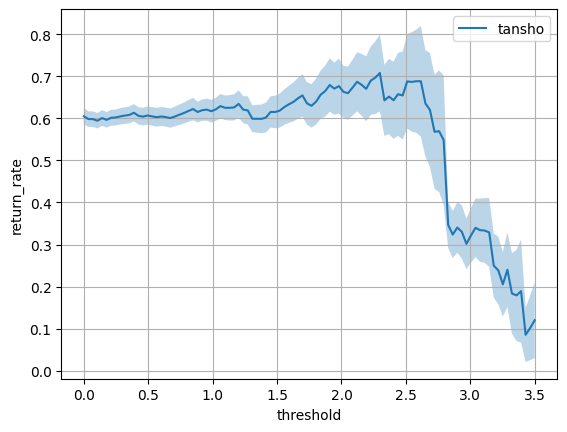

In [51]:
#回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='tansho')

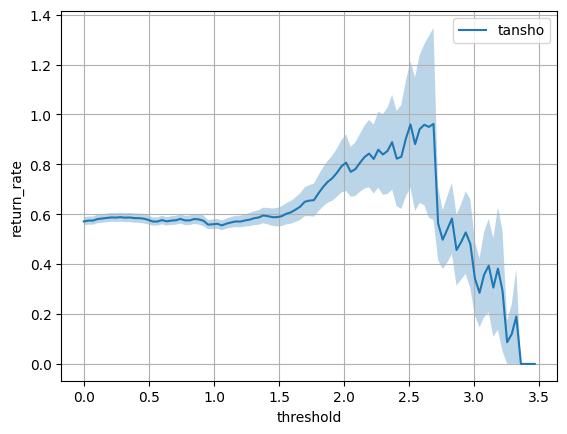

In [4]:
# 過去の回収率のみをロードしてプロット
old_returns_df = pd.read_pickle('models/20260103/tansho.pickle')

T_RANGE = [0.0, 3.5]
N_SAMPLES = 100
returns = {}

# 回収率をプロット
simulation.plot_single_threshold(old_returns_df, N_SAMPLES, label='tansho')

In [52]:
import matplotlib.pyplot as plt

def plot_single_threshold_compare(old_returns_df, returns_df, N_SAMPLES, label1='old_tansho', label2='new_tansho'):
    plt.figure(dpi=100)
    # old_returns_dfの標準偏差で幅をつけて薄くプロット
    plt.fill_between(
        old_returns_df.index,
        y1=old_returns_df['return_rate']-old_returns_df['std'],
        y2=old_returns_df['return_rate']+old_returns_df['std'],
        alpha=0.3
        )
    # old_returns_dfの回収率を実線でプロット
    plt.plot(old_returns_df.index, old_returns_df['return_rate'], label=label1)

    # returns_dfの標準偏差で幅をつけて薄くプロット
    plt.fill_between(
        returns_df.index,
        y1=returns_df['return_rate']-returns_df['std'],
        y2=returns_df['return_rate']+returns_df['std'],
        alpha=0.3
        )
    # returns_dfの回収率を実線でプロット
    plt.plot(returns_df.index, returns_df['return_rate'], label=label2)

    # labelで設定した凡例を表示させる
    plt.legend()
    # グリッドをつける
    plt.grid(True)
    plt.xlabel('threshold')
    plt.ylabel('return_rate')
    plt.show()

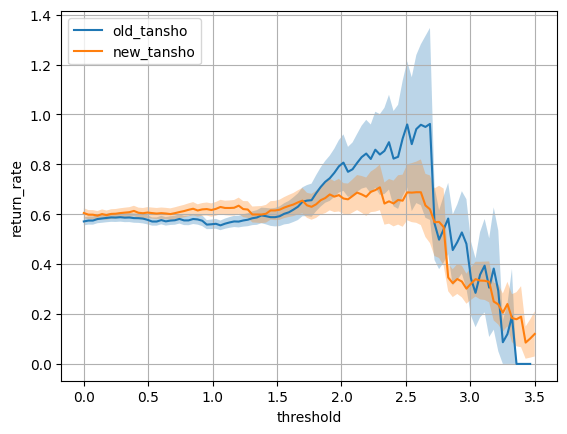

In [53]:
old_returns_df = pd.read_pickle('models/20260103/tansho.pickle')

#old_returns_dfとreturns_dfの結果を重ねてプロットして比較
plot_single_threshold_compare(
    old_returns_df, returns_df, N_SAMPLES,
    label1='old_tansho', label2='new_tansho'
)



In [54]:
# score_table['score'].describe() の出力とreturns_df.index.min()/max() と len(returns_df)を貼るコード
print("score_table['score'] の統計情報:")
display(score_table['score'].describe())
print(f"returns_df index min: {returns_df.index.min()}")
print(f"returns_df index max: {returns_df.index.max()}")
print(f"returns_df length: {len(returns_df)}")

score_table['score'] の統計情報:


count    6.937240e+05
mean    -2.414656e-18
std      9.908537e-01
min     -2.962750e+00
25%     -7.092593e-01
50%     -2.070219e-01
75%      6.194086e-01
max      4.029153e+00
Name: score, dtype: float64

returns_df index min: 0.0
returns_df index max: 3.5
returns_df length: 100


### 5.1.2 複勝馬券

In [55]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyFukusho, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

  0%|          | 0/100 [00:00<?, ?it/s]

In [56]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20260108/fukusho.pickle')

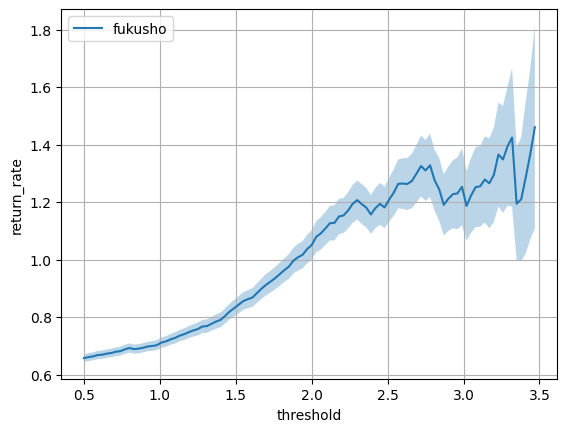

In [57]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='fukusho')

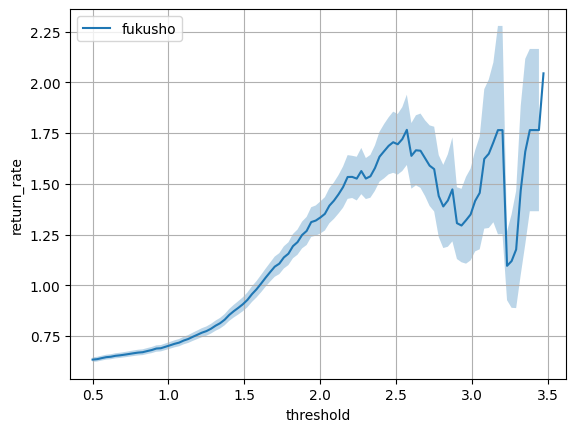

In [5]:
# 過去の回収率のみをロードしてプロット
old_returns_df = pd.read_pickle('models/20260103/fukusho.pickle')

T_RANGE = [0.0, 3.5]
N_SAMPLES = 100
returns = {}

# 回収率をプロット
simulation.plot_single_threshold(old_returns_df, N_SAMPLES, label='fukusho')

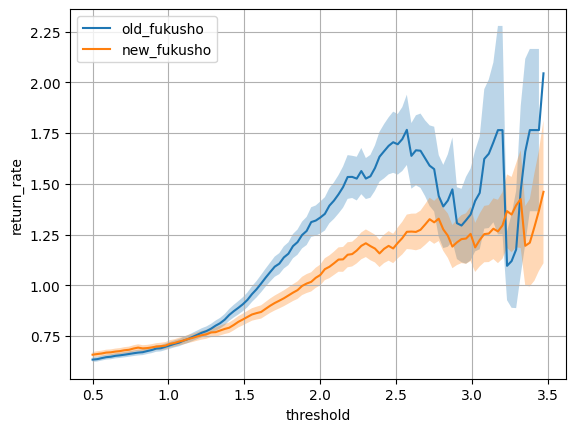

In [58]:
old_returns_df = pd.read_pickle('models/20260103/fukusho.pickle')

#old_returns_dfとreturns_dfの結果を重ねてプロットして比較
plot_single_threshold_compare(
    old_returns_df, returns_df, N_SAMPLES,
    label1='old_fukusho', label2='new_fukusho'
)



### 5.1.3 馬連BOX

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyUmarenBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20260103/umarenbox.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='umarenbox')

### 5.1.4 馬単BOX

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyUmatanBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20260103/umatanbox.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='umatanbox')

### 5.1.5 ワイドBOX

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyWideBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20260103/widebox.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='widebox')

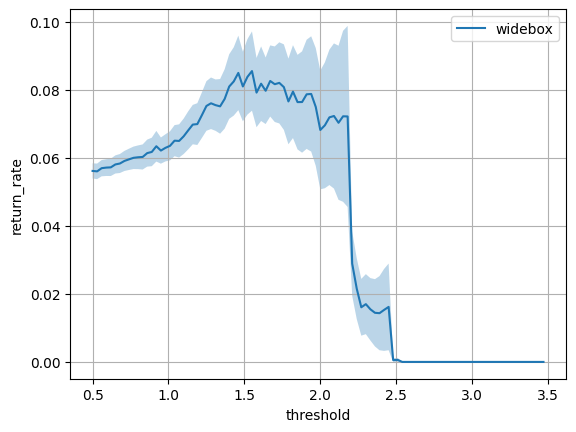

In [6]:
# 過去の回収率のみをロードしてプロット
old_returns_df = pd.read_pickle('models/20260103/widebox.pickle')

T_RANGE = [0.0, 3.5]
N_SAMPLES = 100
returns = {}

# 回収率をプロット
simulation.plot_single_threshold(old_returns_df, N_SAMPLES, label='widebox')

### 5.1.6 三連複BOX

In [66]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicySanrenpukuBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

  0%|          | 0/100 [00:00<?, ?it/s]

In [67]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20260108/sanrenpukubox.pickle')

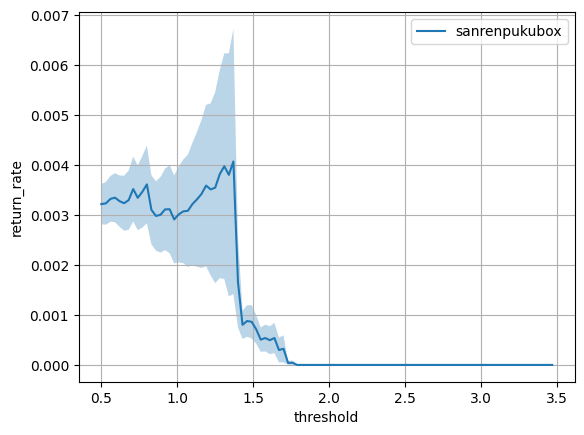

In [68]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='sanrenpukubox')

### 5.1.7 三連単BOX

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicySanrentanBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20260103/sanrentanbox.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='sanrentanbox')

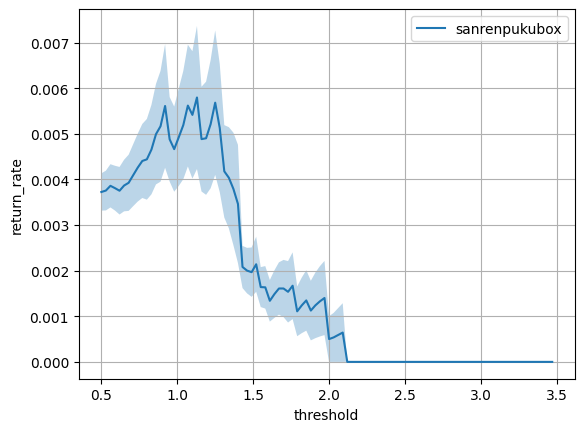

In [7]:
# 過去の回収率のみをロードしてプロット
old_returns_df = pd.read_pickle('models/20260103/sanrenpukubox.pickle')

T_RANGE = [0.0, 3.5]
N_SAMPLES = 100
returns = {}

# 回収率をプロット
simulation.plot_single_threshold(old_returns_df, N_SAMPLES, label='sanrenpukubox')

## 5.2. 複数馬券
未実装

## 5.3. 複数threshold
未実装だが、以下のようなコードになる予定。

In [ ]:
T1_RANGE = [2.5, 3.5]
MIN_T2 = 1
N_SAMPLES = 10

returns = {}
#「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
idx = 0
for i in tqdm(range(N_SAMPLES)):
    #T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold1 = T1_RANGE[1] * i / N_SAMPLES + T1_RANGE[0] * (1-(i/N_SAMPLES))
    for j in range(N_SAMPLES):
        #MIN_T2からthreshold1までをN_SAMPLES等分
        threshold2 = threshold1 * j / N_SAMPLES + MIN_T2 * (1-(j/N_SAMPLES))
        try:
            #print(threshold1, threshold2)
            #賭ける馬券を決定
            actions = keiba_ai.decide_action(
                    score_table, # スコアテーブル
                    policies.BetPolicyTanshoFukusho, # 賭け方の方針(未実装)
                    threshold1=threshold1, #「馬の勝ちやすさスコア」の閾値
                    threshold2=threshold2
                    )
            returns[idx] = simulator.calc_returns(actions)
            idx += 1
        except Exception as e:
            print(e)
            break
returns_df = pd.DataFrame.from_dict(returns, orient='index')

In [ ]:
simulation.plot_single_threshold(returns_df.reset_index(), 100, label='tansho_fukusho')

# 6. 当日の予想
例として2022年1月8日のレースを実際に予想する場合を考える。  
https://race.netkeiba.com/top/race_list.html?kaisai_date=20220108

## 6.1. 前日準備

In [2]:
%autoreload

In [3]:
race_id_list = preparing.scrape_race_id_list(['20260112']) #レースidを取得
len(race_id_list)

getting race_id_list


  0%|          | 0/1 [00:00<?, ?it/s]

scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20260112


24

In [20]:
# モジュール変更をNotebookに反映（スクレイピング周りの修正後はここを実行）
import importlib
import modules.preparing._scrape_shutuba_table as _sst
import modules.preparing._scrape_html as _sh
import modules.preparing as preparing
importlib.reload(_sst)
importlib.reload(_sh)
importlib.reload(preparing)

<module 'modules.preparing' from 'c:\\Users\\koxyg\\Documents\\GitHub\\MyKeiba-AI_v2\\modules\\preparing\\__init__.py'>

In [4]:
#出走するhorse_idの取得
horse_id_list = preparing.scrape_horse_id_list(race_id_list)
len(horse_id_list)

sraping horse_id_list


  0%|          | 0/24 [00:00<?, ?it/s]

370

In [5]:
#horseページのhtmlをスクレイピング
#直近レースが更新されている可能性があるので、skip=Falseにして上書きする
html_files_horse = preparing.scrape_html_horse_with_master(horse_id_list, skip=False)

scraping


  0%|          | 0/370 [00:00<?, ?it/s]

updating master


In [6]:
#horse_infoテーブルの更新
horse_info_20250920 = preparing.get_rawdata_horse_info(html_files_horse)
preparing.update_rawdata(LocalPaths.RAW_HORSE_INFO_PATH, horse_info_20250920)

preparing raw horse_info table


  0%|          | 0/370 [00:00<?, ?it/s]

更新モード: 既存 21208 + 新規 86 = 合計 21294 レコード
データ更新完了: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\raw\horse_info.pickle


,生年月日,調教師,馬主,生産者,産地,セリ取引価格,獲得賞金 (中央),獲得賞金 (地方),通算成績,主な勝鞍,近親馬,trainer_id,owner_id,breeder_id,募集情報
2011106610,2011年5月29日,雑賀正光 (高知),岡田牧雄,増本良孝,新ひだか町,-,"7,051万円",114万円,82戦6勝 [6-3-1-72],15'奥尻特別(500万下),バーミーズ、シルバーゲイル,a0043,851009,233302,NaN
2012100683,2012年3月17日,宮川真衣 (高知),レックス,コスモヴューファーム,新冠町,-,2億109万円,229万円,79戦10勝 [10-9-8-52],17'イルミネーションジャンプS(OP),マイネルパッセ、パルクリール,a0457,309803,214514,NaN
2012103532,2012年2月15日,清水久詞 (栗東),サラブレッドクラブ・ラフィアン,真歌田中牧場,新ひだか町,"1,050万円 (2013年 北海道サマーセール)",2億652万円,0万円,66戦8勝 [8-10-6-42],21'ペガサスジャンプS(OP),トータルソッカー、ガリンシャ,01110,546800,733081,1口:36万円/50口
2012104463,2012年3月17日,今野貞一 (栗東),中村政夫,社台ファーム,千歳市,928万円 (2014年 千葉サラブレッド・セール),"2億3,061万円",0万円,59戦9勝 [9-8-5-37],18'福島テレビオープン(OP),デルマトトコ,01128,471033,393126,NaN
2012104504,2012年4月17日,飯田雄三 (栗東),サラブレッドクラブ・ラフィアン,ノーザンファーム,安平町,-,"1億8,539万円",0万円,58戦8勝 [8-8-6-36],19'総武S(OP),ジオフロント、プロレタリアト,01050,546800,373126,1口:22万円/100口
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023104826,2023年5月8日,東田明士 (栗東),松岡隆雄,浦河小林牧場,浦河町,-,0万円,0万円,1戦0勝 [0-0-0-1],NaN,テイエムスパーダ、ナーゲルリング,01209,306008,730036,NaN
2023106837,2023年2月6日,四位洋文 (栗東),ＴＮレーシング,ノーザンファーム,安平町,"9,240万円 (2024年 セレクトセール)",190万円,0万円,1戦0勝 [0-0-1-0],NaN,デシエルト、スカイグルーヴ,01184,969031,373126,NaN
2023107138,2023年3月26日,福永祐一 (栗東),サンデーレーシング,ノーザンファーム,安平町,-,190万円,0万円,1戦0勝 [0-0-1-0],NaN,ドナウデルタ、イシュトヴァーン,01203,226800,373126,1口:150万円/40口
2023103448,2023年4月26日,森田直行 (栗東),吉田照哉,社台ファーム,千歳市,-,0万円,0万円,1戦0勝 [0-0-0-1],NaN,ティピティーナ、ステイホットの2024,01142,758005,393126,NaN


In [7]:
#horse_resultsテーブルの更新
horse_results_20250920 = preparing.get_rawdata_horse_results(html_files_horse)
preparing.update_rawdata(LocalPaths.RAW_HORSE_RESULTS_PATH, horse_results_20250920)

preparing raw horse_results table


  0%|          | 0/370 [00:00<?, ?it/s]

horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023103134.bin
horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023105808.bin
horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023104203.bin
horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023105880.bin
horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023102824.bin
horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023105909.bin
horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023101731.bin
horse_results insufficient tables: 1 tables in c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\html\horse\2023105618.bin
horse_re

,日付,開催,天気,R,レース名,映像,頭数,枠番,馬番,オッズ,...,着差,ﾀｲﾑ指数,通過,ペース,上り,馬体重,厩舎ｺﾒﾝﾄ,備考,勝ち馬(2着馬),賞金
2011106610,2024/04/29,高知,雨,8.0,りさママ生誕記念特別(C3),NaN,10.0,6.0,7,45.4,...,4.7,**,2-4-6-7,NaN,41.9,477(-1),NaN,NaN,イモータルスモーク,NaN
2011106610,2024/04/14,高知,晴,8.0,C3ー15,NaN,11.0,7.0,8,23.7,...,2.3,**,2-2-2-3,NaN,42.2,478(-1),NaN,NaN,カイラシ,NaN
2011106610,2024/03/27,高知,晴,3.0,C3ー10,NaN,12.0,3.0,3,18.1,...,1.1,**,2-2-2-2,NaN,41.6,479(+3),NaN,NaN,デルマジゾウ,6.0
2011106610,2024/03/20,高知,小雨,2.0,C3ー7,NaN,11.0,7.0,9,11.0,...,0.7,**,7-8-5-6,NaN,41.9,476(0),NaN,NaN,ヤマニンバシリーサ,6.0
2011106610,2024/03/06,高知,曇,3.0,伊予馬事畜産特別(C3),NaN,11.0,6.0,7,11.0,...,1.4,**,3-3-3-4,NaN,39.7,476(-2),NaN,NaN,ララプロフォン,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022102045,2024/08/21,門別,晴,12.0,フルールカップ〔H3(重賞),NaN,10.0,1.0,1,154.2,...,1.8,**,10-10,NaN,38.7,456(0),NaN,NaN,ゼロアワー,NaN
2022102045,2024/08/01,門別,曇,8.0,JRA認定競走ウィナ(OP)(2歳),NaN,7.0,6.0,6,23.8,...,4.8,**,4-4-5-7,NaN,43.5,456(-6),NaN,NaN,ソルジャーフィルド,NaN
2022102045,2024/07/03,門別,曇,5.0,JRA認定競走フレッ(新馬)(2歳),NaN,9.0,3.0,3,4.1,...,-0.1,**,2-2,NaN,38.1,462(0),NaN,NaN,(ハッピータレイア),250.0
2023106386,2025/11/29,5東京7,晴,4.0,2歳新馬,NaN,16.0,3.0,6,58.3,...,3.2,**,14-14,35.8-37.2,38.9,448(0),NaN,NaN,オクトーバーナイン,NaN


In [8]:
#更新後のhorse_infoテーブルの確認
horse_info_processor = preprocessing.HorseInfoProcessor(filepath=LocalPaths.RAW_HORSE_INFO_PATH)
display(horse_info_processor.raw_data.tail())
len(horse_info_processor.raw_data)

,生年月日,調教師,馬主,生産者,産地,セリ取引価格,獲得賞金 (中央),獲得賞金 (地方),通算成績,主な勝鞍,近親馬,trainer_id,owner_id,breeder_id,募集情報
2023104826,2023年5月8日,東田明士 (栗東),松岡隆雄,浦河小林牧場,浦河町,-,0万円,0万円,1戦0勝 [0-0-0-1],NaN,テイエムスパーダ、ナーゲルリング,01209,306008,730036,NaN
2023106837,2023年2月6日,四位洋文 (栗東),ＴＮレーシング,ノーザンファーム,安平町,"9,240万円 (2024年 セレクトセール)",190万円,0万円,1戦0勝 [0-0-1-0],NaN,デシエルト、スカイグルーヴ,01184,969031,373126,NaN
2023107138,2023年3月26日,福永祐一 (栗東),サンデーレーシング,ノーザンファーム,安平町,-,190万円,0万円,1戦0勝 [0-0-1-0],NaN,ドナウデルタ、イシュトヴァーン,01203,226800,373126,1口:150万円/40口
2023103448,2023年4月26日,森田直行 (栗東),吉田照哉,社台ファーム,千歳市,-,0万円,0万円,1戦0勝 [0-0-0-1],NaN,ティピティーナ、ステイホットの2024,01142,758005,393126,NaN
2023107052,2023年1月19日,佐藤悠太 (栗東),塩澤正樹,ノーザンファーム,安平町,"2,970万円 (2024年 セレクトセール)",300万円,0万円,2戦0勝 [0-1-0-1],NaN,エルビッシュ、アドマイヤオウジャ,01205,915008,373126,NaN


21294

In [9]:
#更新後のhorse_resultsテーブルの確認
horse_results_processor = preprocessing.HorseResultsProcessor(filepath=LocalPaths.RAW_HORSE_RESULTS_PATH)
display(horse_results_processor.raw_data.tail())
len(horse_results_processor.raw_data)

c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\modules\preprocessing\_horse_results_processor.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[Cols.PRIZE].fillna(0, inplace=True)


,日付,開催,天気,R,レース名,映像,頭数,枠番,馬番,オッズ,...,着差,ﾀｲﾑ指数,通過,ペース,上り,馬体重,厩舎ｺﾒﾝﾄ,備考,勝ち馬(2着馬),賞金
2022102045,2024/08/21,門別,晴,12.0,フルールカップ〔H3(重賞),NaN,10.0,1.0,1,154.2,...,1.8,**,10-10,NaN,38.7,456(0),NaN,NaN,ゼロアワー,NaN
2022102045,2024/08/01,門別,曇,8.0,JRA認定競走ウィナ(OP)(2歳),NaN,7.0,6.0,6,23.8,...,4.8,**,4-4-5-7,NaN,43.5,456(-6),NaN,NaN,ソルジャーフィルド,NaN
2022102045,2024/07/03,門別,曇,5.0,JRA認定競走フレッ(新馬)(2歳),NaN,9.0,3.0,3,4.1,...,-0.1,**,2-2,NaN,38.1,462(0),NaN,NaN,(ハッピータレイア),250.0
2023106386,2025/11/29,5東京7,晴,4.0,2歳新馬,NaN,16.0,3.0,6,58.3,...,3.2,**,14-14,35.8-37.2,38.9,448(0),NaN,NaN,オクトーバーナイン,NaN
2023107138,2025/11/30,4京都8,晴,3.0,2歳新馬,NaN,13.0,3.0,3,5.7,...,0.9,**,8-7,35.3-34.6,34.4,446(0),NaN,NaN,オンザマーチ,190.0


17105827

In [10]:
#pedsテーブルの更新
html_files_peds = preparing.scrape_html_ped(horse_id_list, skip=False)
peds_20250920 = preparing.get_rawdata_peds(html_files_peds)
preparing.update_rawdata(LocalPaths.RAW_PEDS_PATH, peds_20250920)

  0%|          | 0/370 [00:00<?, ?it/s]

preparing raw peds table


  0%|          | 0/370 [00:00<?, ?it/s]

更新モード: 既存 36003 + 新規 52 = 合計 36055 レコード
データ更新完了: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\raw\peds.pickle


,peds_0,peds_1,peds_2,peds_3,peds_4,peds_5,peds_6,peds_7,peds_8,peds_9,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
2011106610,1999100226,000a000082,000a0012cb,000a000f2b,000a001042,000a0078a6,000a007c38,000a000f87,000a007d0b,000a00877c,...,000a008e05,000a000ded,000a008e04,000a00ae88,000a000e32,000a000e03,000a007ccf,000a007259,000a000de4,000a007b7d
2012100683,2003104570,000a00033a,000a0012bf,000a000f2b,000a001042,000a0078a6,000a007459,000a0013f0,000a0072a0,000a008c1e,...,000a0082aa,000a001383,000a007cea,1982105011,000a000081,000a000e03,000a007054,1955101622,000a00026d,000a0031be
2012103532,1994108729,000a00033a,000a0012bf,000a000f2b,000a001042,000a0078a6,000a007459,000a0013f0,000a0072a0,000a008c1e,...,000a009232,000a001bd8,000a009231,1990109129,000a001b87,000a0000d3,000a00909c,000a006409,000a000e0e,000a007ca0
2012104463,2003102205,000a000d77,000a00185d,000a000e04,000a000f8c,000a00702e,000a008892,000a001183,000a0081e9,000a009851,...,000a008eb9,000a000dda,000a0216c4,000a00fa9e,000a0016db,000a000e04,000a00836d,000a00fa9f,000a000db7,000a00faa0
2012104504,1999106689,000a00033a,000a0012bf,000a000f2b,000a001042,000a0078a6,000a007459,000a0013f0,000a0072a0,000a008c1e,...,000a009de9,000a0012be,000a0086f3,000a00a2b0,000a00193e,000a0010e2,000a007e1d,000a00a2af,000a000ded,000a00a2ae
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023102451,000a013a38,000a0115e2,000a0022d1,000a001bea,000a001607,000a0087a5,000a00b4db,000a001a8e,000a009ac9,000a0115f9,...,000a0002c9,000a00185d,000a00a573,1989107965,000a0002a6,000a0012cb,000a007260,000a000226,000a001612,000a0080c8
2023105734,2014110031,000a01239b,000a00232b,000a00185d,000a000e04,000a008892,1989109105,000a0017b0,000a009786,000a0123ae,...,1984104366,000a000258,000a00058e,1990100739,000a000081,000a000e03,000a007054,000a0061d1,000a0018a0,000a007c56
2023105634,2015101621,000a011d04,000a00231f,000a001be1,000a001607,000a00923d,000a00b688,000a001b40,000a009180,000a011a13,...,000a006409,000a000e0e,000a007ca0,000a006537,000a001676,000a000e04,000a0081e9,000a00a097,000a001341,000a00a096
2023102563,2010104155,1999110099,000a0016f2,000a0012cb,000a000f2b,000a007c38,000a0083b4,000a000fc9,000a0083b3,000a00b2b6,...,000a0118ab,000a001d10,000a0118aa,000a01a7f7,000a001f34,000a001b87,000a00a139,000a010fda,000a001ecc,000a010db5


In [11]:
#processorの更新
horse_info_processor = preprocessing.HorseInfoProcessor(
    filepath=LocalPaths.RAW_HORSE_INFO_PATH)
horse_results_processor = preprocessing.HorseResultsProcessor(
    filepath=LocalPaths.RAW_HORSE_RESULTS_PATH)
peds_processor = preprocessing.PedsProcessor(filepath=LocalPaths.RAW_PEDS_PATH)

c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\modules\preprocessing\_horse_results_processor.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[Cols.PRIZE].fillna(0, inplace=True)


In [12]:
#モデルの準備
keiba_ai = training.KeibaAIFactory.load('models/20260108/basemodel_2020_2025.pickle')

In [ ]:
# --- 診断: モデルのfeature_name_状態を確認 ---
import numpy as np
model = keiba_ai._KeibaAI__model_wrapper.lgb_model
expected_from_attr = getattr(model, 'n_features_in_', None)
expected_from_booster = None
try:
    expected_from_booster = model.booster_.num_feature()
except Exception:
    pass
print('expected_n_features:', expected_from_attr, expected_from_booster)
fn = getattr(model, 'feature_name_', None)
print('feature_name_ type:', type(fn))
try:
    print('len(feature_name_):', None if fn is None else len(fn))
except Exception as e:
    print('len(feature_name_) failed:', e, 'value:', fn)
try:
    print('feature_name_ head:', None if fn is None else list(fn)[:10])
except Exception as e:
    print('list(feature_name_) failed:', e)

print('datasets.X_train n_features:', keiba_ai.datasets.X_train.shape[1])
print('X_train head:', list(keiba_ai.datasets.X_train.columns)[:10])

# 手動でfeature_name_を書き換えできるかテスト
try:
    model.feature_name_ = list(keiba_ai.datasets.X_train.columns)
    print('manually set feature_name_ ok')
    print('feature_name_ head (after set):', list(model.feature_name_)[:10])
except Exception as e:
    print('manually set feature_name_ failed:', repr(e))

## 6.2. 前日全レース予想

In [13]:
# 変更点: %autoreload がWindowsの既定エンコーディング(cp932)で読み込み失敗することがあるため、明示的にreload
import importlib
import modules.policies._score_policy as _score_policy_mod
import modules.policies as _policies_mod
import modules.training._model_wrapper as _model_wrapper_mod
import modules.training._keiba_ai as _keiba_ai_mod
import modules.training._keiba_ai_factory as _keiba_ai_factory_mod
import modules.training as _training_mod

importlib.reload(_score_policy_mod)
importlib.reload(_policies_mod)
importlib.reload(_model_wrapper_mod)
importlib.reload(_keiba_ai_mod)
importlib.reload(_keiba_ai_factory_mod)
importlib.reload(_training_mod)

from modules import policies as policies
from modules import training as training
score_policy = policies.StdScorePolicy
print('reloaded policies/training (explicit)')

reloaded policies/training (explicit)


In [13]:
# 前日全レース予想用のレースidとレース発走時刻を取得
target_race_id_list, target_race_time_list = preparing.scrape_race_id_race_time_list('20260111')
print(len(target_race_id_list))
print(len(target_race_time_list))
yesterday = True

getting race_id_list
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20260111
24
24


In [10]:
# ターゲットエンコーディング時に「馬の成績」として扱う項目
TARGET_COLS = [
        HorseResultsCols.RANK,
        HorseResultsCols.PRIZE,
        HorseResultsCols.RANK_DIFF, 
        'first_corner',
        'final_corner',
        'first_to_rank',
        'first_to_final',
        'final_to_rank',
        'time_seconds'
        ]
# horse_id列と共に、ターゲットエンコーディングの対象にする列
GROUP_COLS = [
        'course_len',
        'race_type',
        HorseResultsCols.PLACE
        ]

In [16]:
# --- 診断: 特徴量の一致率とスコアの分散を1レースで確認 ---
import numpy as np
import pandas as pd

# 例として最初のレースを対象（必要なら race_id をここで上書き）
race_id_debug = target_race_id_list[10]
race_time_debug = target_race_time_list[10]
filepath = 'data/tmp/shutuba_debug.pickle'
today = '2026/01/09'  # 前日予測の取得日（実運用に合わせる）

preparing.scrape_shutuba_table(race_id_debug, today, filepath)

if yesterday:
    pd2 = pd.read_pickle(filepath)
    pd2[ResultsCols.WEIGHT_AND_DIFF] = '0(0)'
    if 'weather' not in pd2.columns or pd2['weather'].isnull().all():
        pd2['weather'] = '晴'
    if 'ground_state' not in pd2.columns or pd2['ground_state'].isnull().all():
        pd2['ground_state'] = '良'
    pd2.to_pickle(filepath)

shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath)
shutuba_data_merger = preprocessing.ShutubaDataMerger(
    shutuba_table_processor,
    horse_results_processor,
    horse_info_processor,
    peds_processor,
    target_cols=TARGET_COLS,
    group_cols=GROUP_COLS,
 )
shutuba_data_merger.merge()

feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger) \
    .add_interval()\
    .add_agedays()\
    .dumminize_ground_state()\
    .dumminize_race_type()\
    .dumminize_sex()\
    .dumminize_weather()\
    .encode_horse_id()\
    .encode_jockey_id()\
    .encode_trainer_id()\
    .encode_owner_id()\
    .encode_breeder_id()\
    .dumminize_kaisai()\
    .dumminize_around()\
    .dumminize_race_class()

X_debug = feature_enginnering_shutuba.featured_data.drop(['date'], axis=1)

# 推論時の列数不一致対策：学習時列に合わせて0埋め整列してからpredict
train_cols = list(keiba_ai.datasets.X_train.columns)
X_debug_aligned = X_debug.reindex(columns=train_cols, fill_value=0)
if ResultsCols.UMABAN in X_debug.columns:
    X_debug_aligned[ResultsCols.UMABAN] = X_debug[ResultsCols.UMABAN]

model = keiba_ai._KeibaAI__model_wrapper.lgb_model
score_debug = score_policy.calc(model, X_debug_aligned)
print('debug race_id:', race_id_debug, 'time:', race_time_debug)
print('score nunique:', score_debug['score'].nunique())
display(score_debug.sort_values('score', ascending=False).head(16))

スクレイピング完了 - レース202606010311: 19頭立て
生データの列数: 18
馬番列（index=1）の値: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', 'ロードオールライト', '']
クリーンアップ前の馬番: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', 'ロードオールライト', '']
scrape_shutuba_table: 2件の不正な馬番レコードを除去しました
除去された馬番: ['ロードオールライト', '']
  除去レコード 202606010311: 馬番='ロードオールライト', 体重='nan'
  除去レコード 202606010311: 馬番='', 体重='nan'
ShutubaTableProcessor: 馬番クリーンアップ開始（17件のレコード）
ShutubaTableProcessor: すべての馬番が有効です
separating horse results by date


  0%|          | 0/1 [00:00<?, ?it/s]

merging horse_results


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=1.1183531548969373e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1183531548969373e-07
[LightGBM] [Warning] lambda_l2 is set=1.8251521766817335e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8251521766817335e-07
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
debug race_id: 202606010311 time: 15:45
score nunique: 17


c:\Users\koxyg\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 指定されたファイルが見つかりません。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\koxyg\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\koxyg\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\koxyg\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\koxyg\Ap

,馬番,score
5,6,1.437203
8,9,1.396744
3,4,1.305186
16,17,0.983314
10,11,0.721824
12,13,0.720024
1,2,0.217459
2,3,0.149057
7,8,0.009503
15,16,-0.225064


In [ ]:
# 一時的に出馬表を保存するパスを指定
filepath = 'data/tmp/shutuba.pickle'
today = '2022/12/27'

for race_id, race_time in zip(target_race_id_list, target_race_time_list):
    # 出馬表の取得
    preparing.scrape_shutuba_table(race_id, today, filepath)

    # 前日予想の場合
    if yesterday:
        # 前日予想の場合、馬体重を0（0）に補正
        pd2 = pd.read_pickle(filepath)
        pd2[ResultsCols.WEIGHT_AND_DIFF] = '0(0)'
        # 前日予想の場合、天候と馬場状態が公開されていない場合はこちらを有効にする
        #pd2['weather'] = '晴'
        #pd2['ground_state'] = '良'
        pd2.to_pickle(filepath)

    # 出馬表の加工
    shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath)

    # テーブルのマージ
    shutuba_data_merger = preprocessing.ShutubaDataMerger(
        shutuba_table_processor,
        horse_results_processor,
        horse_info_processor,
        peds_processor,
        target_cols=TARGET_COLS,
        group_cols=GROUP_COLS
    )
    shutuba_data_merger.merge()

    # 特徴量エンジニアリング
    feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger) \
        .add_interval()\
        .add_agedays()\
        .dumminize_ground_state()\
        .dumminize_race_type()\
        .dumminize_sex()\
        .dumminize_weather()\
        .encode_horse_id()\
        .encode_jockey_id()\
        .encode_trainer_id()\
        .encode_owner_id()\
        .encode_breeder_id()\
        .dumminize_kaisai()\
        .dumminize_around()\
        .dumminize_race_class()

    # 予測
    X = feature_enginnering_shutuba.featured_data.drop(['date'], axis=1)

    # 当日の出走情報テーブル（前処理前）
    df_tmp = shutuba_table_processor.raw_data[:1]

    i = 0
    for num in list(Master.PLACE_DICT.values()):
        if num == race_id[4:6]:
            print(list(Master.PLACE_DICT)[i] + race_id[10:12] + 'R ' + race_time + '発走 ' + str(df_tmp.iat[0, 12])
                + str(df_tmp.iat[0, 10]) + 'm ' + str(df_tmp.iat[0, 13]) + ' ' + str(df_tmp.iat[0, 15]))
            break
        i += 1

    print(keiba_ai.calc_score(X, policies.StdScorePolicy).sort_values('score', ascending=False))

In [ ]:
# ============================================================================
# 全レース前日予測（特徴量整列は keiba_ai.calc_score に委譲）
# ============================================================================

import time
import numpy as np
import pandas as pd

print("=== 全レース前日予測開始 ===")
print(f"対象レース数: {len(target_race_id_list)}")
print(f"前日予想モード: {'ON' if yesterday else 'OFF'}")
print("=" * 50)

# 一時的に出馬表を保存するパスを指定
filepath = 'data/tmp/shutuba.pickle'
today = '2025/12/26'

# 全レースの予測結果を格納
all_predictions = {}
error_count = 0

for idx, (race_id, race_time) in enumerate(zip(target_race_id_list, target_race_time_list), 1):
    try:
        print(f"\n[{idx}/{len(target_race_id_list)}] レース処理中: {race_id}")
        
        # サーバー負荷軽減（必須）
        time.sleep(1)
        
        # 出馬表の取得
        preparing.scrape_shutuba_table(race_id, today, filepath)

        # 前日予想の場合
        if yesterday:
            # 前日予想の場合、馬体重を0（0）に補正
            pd2 = pd.read_pickle(filepath)
            pd2[ResultsCols.WEIGHT_AND_DIFF] = '0(0)'
            # 前日予想の場合、天候と馬場状態が公開されていない場合はデフォルト値を設定
            if 'weather' not in pd2.columns or pd2['weather'].isnull().all():
                pd2['weather'] = '晴'
            if 'ground_state' not in pd2.columns or pd2['ground_state'].isnull().all():
                pd2['ground_state'] = '良'
            pd2.to_pickle(filepath)

        # 出馬表の加工
        shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath)

        # テーブルのマージ
        shutuba_data_merger = preprocessing.ShutubaDataMerger(
            shutuba_table_processor,
            horse_results_processor,
            horse_info_processor,
            peds_processor,
            target_cols=TARGET_COLS,
            group_cols=GROUP_COLS
)
        shutuba_data_merger.merge()

        # 特徴量エンジニアリング
        feature_enginnering_shutuba = (
            preprocessing.FeatureEngineering(shutuba_data_merger)
            .add_interval()
            .add_agedays()
            .dumminize_ground_state()
            .dumminize_race_type()
            .dumminize_sex()
            .dumminize_weather()
            .encode_horse_id()
            .encode_jockey_id()
            .encode_trainer_id()
            .encode_owner_id()
            .encode_breeder_id()
            .dumminize_kaisai()
            .dumminize_around()
            .dumminize_race_class()
        )

        # 予測（整列・型変換は calc_score 側のポリシーで吸収）
        X = feature_enginnering_shutuba.featured_data.drop(['date'], axis=1, errors='ignore')

        # 当日の出走情報テーブル（前処理前）
        df_tmp = shutuba_table_processor.raw_data[:1]

        # レース情報の表示
        race_info = ""
        for place_name, num in Master.PLACE_DICT.items():
            if num == race_id[4:6]:
                race_info = (
                    f"{place_name}{race_id[10:12]}R {race_time}発走 "
                    f"{df_tmp.iat[0, 12]}{df_tmp.iat[0, 10]}m "
                    f"{df_tmp.iat[0, 13]} {df_tmp.iat[0, 15]}"
                )
                print(race_info)
                break

        # 予測実行
        score_result = keiba_ai.calc_score(X, score_policy).sort_values('score', ascending=False)
        print("score nunique:", score_result['score'].nunique())

        # 上位馬のみを表示（簡潔化）
        top_horses = score_result.head(5)
        print("TOP5予想:")
        for rank, (_, row) in enumerate(top_horses.iterrows(), 1):
            print(f"  {rank}位: {row['馬番']}番 (スコア: {row['score']:.3f})")

        # 結果を保存
        all_predictions[race_id] = {
            'race_info': race_info,
            'predictions': score_result,
            'race_time': race_time
        }

        print(f"✅ {race_id} 予測完了")

    except Exception as e:
        error_count += 1
        print(f"❌ {race_id} 予測エラー: {str(e)}")
        # エラーが発生したレースをスキップして続行
        continue

print(f"\n=== 全レース予測完了 ===")
print(f"成功: {len(all_predictions)}/{len(target_race_id_list)} レース")
print(f"エラー: {error_count} レース")

# 最終結果のサマリー表示
if all_predictions:
    print(f"\n=== 本日の予想結果一覧 ===")
    for race_id, result in all_predictions.items():
        print(f"\n{result['race_info']}")
        top3 = result['predictions'].head(3)

        for rank, (_, row) in enumerate(top3.iterrows(), 1):
            print(f"  {rank}位予想: {row['馬番']}番 (スコア: {row['score']:.3f})")

    print(f"\n🎯 {len(all_predictions)}レースの予測が完了しました！")
else:
    print("❌ 予測に成功したレースがありません。")

## 6.3. レース直前データ処理（当日レース予想）

In [13]:
%autoreload

In [23]:
# 馬体重の発表されたレースID、レース時刻を取得（レース当日用）
target_race_id_list, target_race_time_list = preparing.create_active_race_id_list()

# レース時刻順にソート
race_data = list(zip(target_race_id_list, target_race_time_list))
race_data_sorted = sorted(race_data, key=lambda x: x[1])  # 時刻でソート
target_race_id_list = [race_id for race_id, race_time in race_data_sorted]
target_race_time_list = [race_time for race_id, race_time in race_data_sorted]

print("ソート後のレースID:", target_race_id_list)
print("ソート後のレース時刻:", target_race_time_list)

20260112 11:36
getting race_id_list
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20260112
ソート後のレースID: ['202606010505', '202608010505']
ソート後のレース時刻: ['12:10', '12:25']


In [24]:
# 一時的に出馬表を保存するパスを指定
filepath = 'data/tmp/shutuba.pickle'
#today = '2022/10/01'
today = datetime.datetime.now().date().strftime('%Y/%m/%d')

for race_id, race_time in zip(target_race_id_list, target_race_time_list):
    # 出馬表の取得
    preparing.scrape_shutuba_table(race_id, today, filepath)

    # 出馬表の加工
    shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath)
    # 馬番クリーンアップを含む前処理を実行
    # shutuba_table_processor.process()

    # テーブルのマージ
    shutuba_data_merger = preprocessing.ShutubaDataMerger(
        shutuba_table_processor,
        horse_results_processor,
        horse_info_processor,
        peds_processor,
        target_cols=TARGET_COLS,
        group_cols=GROUP_COLS
    )
    shutuba_data_merger.merge()

    # 特徴量エンジニアリング
    feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger) \
        .add_interval()\
        .add_agedays()\
        .dumminize_ground_state()\
        .dumminize_race_type()\
        .dumminize_sex()\
        .dumminize_weather()\
        .encode_horse_id()\
        .encode_jockey_id()\
        .encode_trainer_id()\
        .encode_owner_id()\
        .encode_breeder_id()\
        .dumminize_kaisai()\
        .dumminize_around()\
        .dumminize_race_class()

    # 予測
    X = feature_enginnering_shutuba.featured_data.drop(['date'], axis=1)

    # 当日の出走情報テーブル（前処理前）
    df_tmp = shutuba_table_processor.raw_data[:1]
    #df_tmp['race_type'] tmp.iat[0, 12]
    #df_tmp['around'] 13
    #df_tmp['weather'] 14
    #df_tmp['ground_state'] 15
    #df_tmp['race_class']16

    i = 0
    for num in list(Master.PLACE_DICT.values()):
        if num == race_id[4:6]:
            print(list(Master.PLACE_DICT)[i] + race_id[10:12] + 'R ' + race_time + '発走 ' + str(df_tmp.iat[0, 12])
                + str(df_tmp.iat[0, 10]) + 'm ' + str(df_tmp.iat[0, 13]) + ' ' + str(df_tmp.iat[0, 15]))
            break
        i += 1

    print(keiba_ai.calc_score(X, policies.StdScorePolicy).sort_values('score', ascending=False))

スクレイピング完了 - レース202606010505: 18頭立て
生データの列数: 18
馬番列（index=1）の値: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', 'ボンヴィアッジョ', '']
クリーンアップ前の馬番: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', 'ボンヴィアッジョ', '']
scrape_shutuba_table: 2件の不正な馬番レコードを除去しました
除去された馬番: ['ボンヴィアッジョ', '']
  除去レコード 202606010505: 馬番='ボンヴィアッジョ', 体重='nan'
  除去レコード 202606010505: 馬番='', 体重='nan'
ShutubaTableProcessor: 馬番クリーンアップ開始（16件のレコード）
ShutubaTableProcessor: すべての馬番が有効です
separating horse results by date


  0%|          | 0/1 [00:00<?, ?it/s]

merging horse_results


  0%|          | 0/1 [00:00<?, ?it/s]

中山05R 12:10発走 ダート新馬m 右 良
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=1.1183531548969373e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1183531548969373e-07
[LightGBM] [Warning] lambda_l2 is set=1.8251521766817335e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8251521766817335e-07
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
         race_id  馬番     score
1   202606010505   2  2.444482
3   202606010505   4  1.125460
14  202606010505  15  0.984041
12  202606010505  13  0.571213
6   202606010505   7  0.472694
11  202606010505  12  0.364325
2   202606010505   3  0.126975
7   202606010505   8 -0.203228
5   202606010505   6 -0.327944
8   202606010505   9 -0.418304
9 

  0%|          | 0/1 [00:00<?, ?it/s]

merging horse_results


  0%|          | 0/1 [00:00<?, ?it/s]

京都05R 12:25発走 芝新馬m 右 良
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=1.1183531548969373e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1183531548969373e-07
[LightGBM] [Warning] lambda_l2 is set=1.8251521766817335e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8251521766817335e-07
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
         race_id  馬番     score
0   202608010505   1  3.359856
15  202608010505  16  0.967612
10  202608010505  11  0.790050
16  202608010505  17  0.504863
4   202608010505   5  0.049341
3   202608010505   4  0.022235
9   202608010505  10 -0.094551
5   202608010505   6 -0.097523
13  202608010505  14 -0.165763
17  202608010505  18 -0.234915
7   

In [22]:
# 本番では予測してなかったけど、400万馬券が出たレースのスコアがどうなってたか確認する（セル163の単レース版）
import datetime
import time
from pathlib import Path

# 確認したいレースID（例: 202608010307）
race_id_debug = '202608010503'

# (任意) return_tables があれば「三連単 400万円以上」のレース候補を表示する
return_tables_path = None
for p in [Path('data/raw/return_tables.pickle'), Path('data/raw/return_tables.pickle.bak')]:
    if p.exists():
        return_tables_path = p
        break

if return_tables_path is not None:
    try:
        return_processor = preprocessing.ReturnProcessor(str(return_tables_path))
        return_dict = return_processor.preprocessed_data
        sanrentan = return_dict.get('sanrentan')
        if sanrentan is not None and 'return' in sanrentan.columns:
            high = sanrentan[sanrentan['return'] >= 4_000_000].sort_values('return', ascending=False)
            if len(high) > 0:
                print('=== 三連単 400万円以上のレース候補（上位10）===')
                display(high.head(10))
            if race_id_debug and str(race_id_debug) in sanrentan.index.astype(str):
                payout = sanrentan.loc[sanrentan.index.astype(str) == str(race_id_debug), 'return'].iloc[0]
                print(f"レース {race_id_debug} 三連単払戻: {int(payout):,}円")
    except Exception as e:
        print(f"return_tables 解析スキップ: {e}")

if not race_id_debug:
    raise ValueError('race_id_debug が空です。レースIDを設定してください。')

# race_id から日付を推定（yyyy/mm/dd）
debug_date = f"{race_id_debug[:4]}/{race_id_debug[4:6]}/{race_id_debug[6:8]}"

# 出馬表の取得（過去レースでも参照できる場合あり）
filepath_debug = 'data/tmp/shutuba_debug.pickle'
time.sleep(1)  # サーバー負荷軽減（1秒間隔）
preparing.scrape_shutuba_table(race_id_debug, debug_date, filepath_debug)

# 出馬表の加工 + マージ + 特徴量（セル163と同じ流れ）
shutuba_table_processor_debug = preprocessing.ShutubaTableProcessor(filepath_debug)
shutuba_data_merger_debug = preprocessing.ShutubaDataMerger(
    shutuba_table_processor_debug,
    horse_results_processor,
    horse_info_processor,
    peds_processor,
    target_cols=TARGET_COLS,
    group_cols=GROUP_COLS,
 )
shutuba_data_merger_debug.merge()

feature_enginnering_debug = (
    preprocessing.FeatureEngineering(shutuba_data_merger_debug)
    .add_interval()
    .add_agedays()
    .dumminize_ground_state()
    .dumminize_race_type()
    .dumminize_sex()
    .dumminize_weather()
    .encode_horse_id()
    .encode_jockey_id()
    .encode_trainer_id()
    .encode_owner_id()
    .encode_breeder_id()
    .dumminize_kaisai()
    .dumminize_around()
    .dumminize_race_class()
 )

X_debug = feature_enginnering_debug.featured_data.drop(['date'], axis=1)

# レース概要表示（列名ベースで安全に）
info_row = shutuba_table_processor_debug.raw_data.iloc[0]
place_code = str(race_id_debug)[4:6]
place_name = next((k for k, v in Master.PLACE_DICT.items() if v == place_code), place_code)
race_no = int(str(race_id_debug)[10:12])
print(f"=== {race_id_debug} ({debug_date}) {place_name}{race_no}R ===")
print(
    f"{info_row.get('race_type','')} {info_row.get('course_len','')}m "
    f"{info_row.get('around','')} {info_row.get('ground_state','')} / "
    f"{info_row.get('weather','')} / {info_row.get('race_class','')}"
 )

# 予測スコア（馬ごと）
score_df_debug = keiba_ai.calc_score(X_debug, policies.StdScorePolicy).sort_values('score', ascending=False)
print('=== 予測スコア ===')
display(score_df_debug)

# (任意) 実際の着順との突合（results.pickle があれば）
results_path = None
for p in [Path('data/raw/results.pickle'), Path('data/raw/results.pickle.bak')]:
    if p.exists():
        results_path = p
        break

if results_path is not None:
    try:
        import pandas as pd
        results_raw = pd.read_pickle(results_path)
        if str(race_id_debug) in results_raw.index.astype(str):
            actual = results_raw.loc[str(race_id_debug)].copy()
            # race_id 単位で複数行になる想定（出走頭数ぶん）
            if isinstance(actual, pd.Series):
                actual = actual.to_frame().T
            cols_want = [c for c in ['着順', '馬番', '馬名', '単勝', '人気'] if c in actual.columns]
            if '着順' in actual.columns:
                actual['着順'] = pd.to_numeric(actual['着順'], errors='coerce')
                actual = actual.sort_values('着順')
            merged = actual[cols_want].merge(
                score_df_debug[['馬番', 'score']],
                on='馬番',
                how='left',
            )
            print('=== 実着順 × 予測スコア（先頭10頭）===')
            display(merged.head(10))
    except Exception as e:
        print(f"results 突合スキップ: {e}")

=== 三連単 400万円以上のレース候補（上位10）===


,win_0,win_1,win_2,return
202105010704,16,6,8.0,20738890.0
202105010704,16,6,8.0,20738890.0
202105010704,16,6,8.0,20738890.0
202105010704,16,6,8.0,20738890.0
202105010704,16,6,8.0,20738890.0
202105010704,16,6,8.0,20738890.0
202105010704,16,6,8.0,20738890.0
202105010704,16,6,8.0,20738890.0
202301020407,10,14,12.0,17730000.0
202306050602,15,11,6.0,17649380.0


スクレイピング完了 - レース202608010503: 18頭立て
生データの列数: 18
馬番列（index=1）の値: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', 'ガルディエンヌ', '']
クリーンアップ前の馬番: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', 'ガルディエンヌ', '']
scrape_shutuba_table: 2件の不正な馬番レコードを除去しました
除去された馬番: ['ガルディエンヌ', '']
  除去レコード 202608010503: 馬番='ガルディエンヌ', 体重='nan'
  除去レコード 202608010503: 馬番='', 体重='nan'
ShutubaTableProcessor: 馬番クリーンアップ開始（16件のレコード）
ShutubaTableProcessor: すべての馬番が有効です
separating horse results by date


  0%|          | 0/1 [00:00<?, ?it/s]

merging horse_results


  0%|          | 0/1 [00:00<?, ?it/s]

=== 202608010503 (2026/08/01) 京都3R ===
ダート 1400m 右 良 / 晴 / 未勝利
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=1.1183531548969373e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1183531548969373e-07
[LightGBM] [Warning] lambda_l2 is set=1.8251521766817335e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8251521766817335e-07
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
=== 予測スコア ===


,race_id,馬番,score
10,202608010503,11,1.680500
0,202608010503,1,1.067037
1,202608010503,2,0.957115
4,202608010503,5,0.893034
6,202608010503,7,0.851599
12,202608010503,13,0.693758
9,202608010503,10,0.400955
13,202608010503,14,0.184277
8,202608010503,9,0.120261
14,202608010503,15,-0.153557


## 6.4. レース直前データ処理（旧方式）

In [ ]:
filepath = 'data/tmp/shutuba.pickle' #一時的に出馬表を保存するパスを指定
preparing.scrape_shutuba_table(race_id_list[0], '2025/9/21', filepath) #馬体重が発表されたら、出馬表を取得
shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath) #出馬表の加工

In [ ]:
#テーブルのマージ
shutuba_data_merger = preprocessing.ShutubaDataMerger(
    shutuba_table_processor,
    horse_results_processor,
    horse_info_processor,
    peds_processor,
    target_cols=TARGET_COLS,
    group_cols=GROUP_COLS
)

shutuba_data_merger.merge()

In [ ]:
#特徴量エンジニアリング
feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger)\
    .add_interval()\
    .add_agedays()\
    .dumminize_ground_state()\
    .dumminize_race_type()\
    .dumminize_sex()\
    .dumminize_weather()\
    .encode_horse_id()\
    .encode_jockey_id()\
    .encode_trainer_id()\
    .encode_owner_id()\
    .encode_breeder_id()\
    .dumminize_kaisai()\
    .dumminize_around()\
    .dumminize_race_class()

In [ ]:
# 予測（学習列に完全整列＋NaN防止）
from modules.constants import ResultsCols
import numpy as np

# 1) 学習で実際に使った列を取得
train_cols = keiba_ai.datasets.X_train.columns

# 2) 予測用特徴量（date/rankは除外）
X_feat = feature_enginnering_shutuba.featured_data.drop(['date', 'rank'], axis=1, errors='ignore')

# 3) 学習列に揃える（不足は0、余剰は落とす）
X_feat = X_feat.reindex(columns=train_cols, fill_value=0)

# 4) 数値化とNaN/inf対策
for c in X_feat.columns:
    if getattr(X_feat[c].dtype, 'name', '') == 'category':
        X_feat[c] = X_feat[c].cat.codes
X_feat = X_feat.astype(float).replace([np.inf, -np.inf], 0).fillna(0)

# 5) 表示用に馬番を付与（ポリシー側で自動除外）
X_for_policy = X_feat.copy()
if ResultsCols.UMABAN in feature_enginnering_shutuba.featured_data.columns:
    X_for_policy[ResultsCols.UMABAN] = feature_enginnering_shutuba.featured_data[ResultsCols.UMABAN].values

# 6) 予測
score_result = keiba_ai.calc_score(X_for_policy, policies.StdScorePolicy).sort_values('score', ascending=False)
score_result.head()

## 付録
騎手勝率無し VS 有りの比較

In [ ]:
old_returns_df = pd.read_pickle('models/20251226/tansho_no_jockey_std_0_3p5.pickle')



# old_returns_df と returns_df の結果を重ねてプロットして比較

plot_single_threshold_compare(

    old_returns_df, returns_df, N_SAMPLES,

    label1='no_jockey(std,0-3.5)', label2='with_jockey(std,0-3.5)'

)




In [ ]:
# n_bets / n_races がどの閾値から崩れるか確認（特徴量なし vs あり）

import matplotlib.pyplot as plt



def _plot_counts(df, label, ax_bets, ax_races):

    ax_bets.plot(df.index, df['n_bets'], label=label)

    ax_races.plot(df.index, df['n_races'], label=label)



fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), dpi=100, sharex=True)



_plot_counts(old_returns_df, 'no_jockey', ax1, ax2)

_plot_counts(returns_df, 'with_jockey', ax1, ax2)



ax1.set_ylabel('n_bets')

ax1.grid(True)

ax1.legend()



ax2.set_ylabel('n_races')

ax2.set_xlabel('threshold')

ax2.grid(True)

ax2.legend()



plt.show()



print('--- tail(10): no_jockey ---')

display(old_returns_df.tail(10)[['n_bets','n_races','return_rate']])

print('--- tail(10): with_jockey ---')

display(returns_df.tail(10)[['n_bets','n_races','return_rate']])


In [ ]:
# n_races >= 100 に限定した return_rate の最大値（特徴量なし vs あり）

import numpy as np



MIN_RACES = 100



def best_under_constraint(df, min_races: int):

    d = df[df['n_races'] >= min_races].copy()

    if len(d) == 0:

        return None, None, d

    best_thr = float(d['return_rate'].idxmax())

    best_rr = float(d.loc[best_thr, 'return_rate'])

    return best_thr, best_rr, d



thr0, rr0, d0 = best_under_constraint(old_returns_df, MIN_RACES)

thr1, rr1, d1 = best_under_constraint(returns_df, MIN_RACES)



print(f'MIN_RACES = {MIN_RACES}')

print('--- no_jockey ---')

if thr0 is None:

    print('条件を満たすthresholdがありません')

else:

    print('best threshold:', thr0)

    print('best return_rate:', rr0)

    display(old_returns_df.loc[[thr0], ['n_bets','n_races','return_rate','std']])



print('--- with_jockey ---')

if thr1 is None:

    print('条件を満たすthresholdがありません')

else:

    print('best threshold:', thr1)

    print('best return_rate:', rr1)

    display(returns_df.loc[[thr1], ['n_bets','n_races','return_rate','std']])



# 参考: 上位5件も表示

if len(d0) > 0:

    print('top5(no_jockey)')

    display(d0.sort_values('return_rate', ascending=False).head(5)[['n_bets','n_races','return_rate','std']])

if len(d1) > 0:

    print('top5(with_jockey)')

    display(d1.sort_values('return_rate', ascending=False).head(5)[['n_bets','n_races','return_rate','std']])


In [ ]:
# 上位帯の安定性チェック: MIN_RACES を変えてベストを比較

import pandas as pd



MIN_RACES_LIST = [100, 200, 500]



def best_row(df: pd.DataFrame, min_races: int, label: str) -> dict:

    d = df[df['n_races'] >= min_races]

    if len(d) == 0:

        return {

            'model': label,

            'min_races': min_races,

            'best_threshold': None,

            'best_return_rate': None,

            'n_races': 0,

            'n_bets': 0,

            'std': None,

        }

    thr = float(d['return_rate'].idxmax())

    row = df.loc[thr]

    return {

        'model': label,

        'min_races': min_races,

        'best_threshold': thr,

        'best_return_rate': float(row['return_rate']),

        'n_races': int(row['n_races']),

        'n_bets': int(row['n_bets']),

        'std': float(row['std']),

    }



rows = []

for m in MIN_RACES_LIST:

    rows.append(best_row(old_returns_df, m, 'no_jockey'))

    rows.append(best_row(returns_df, m, 'with_jockey'))



stability_df = pd.DataFrame(rows).sort_values(['min_races', 'model']).reset_index(drop=True)

display(stability_df)


In [ ]:
# 運用向けチェック: min_races=500 の範囲で return_rate > 1.0 は存在するか

import pandas as pd



MIN_RACES_OPS = 500

RR_TARGET = 1.0



def points_over_1(df: pd.DataFrame, label: str, min_races: int, rr_target: float):

    d = df[df['n_races'] >= min_races].copy()

    over = d[d['return_rate'] > rr_target].copy()

    print(f'[{label}] min_races>={min_races} の点数: {len(d)}')

    print(f'[{label}] return_rate>{rr_target} の点数: {len(over)}')

    if len(over) == 0:

        return

    print(f'[{label}] threshold 範囲: {float(over.index.min())} 〜 {float(over.index.max())}')

    display(over.sort_values('return_rate', ascending=False).head(10)[['n_bets','n_races','return_rate','std']])



points_over_1(old_returns_df, 'no_jockey', MIN_RACES_OPS, RR_TARGET)

points_over_1(returns_df, 'with_jockey', MIN_RACES_OPS, RR_TARGET)


In [ ]:
# === 旧モデル(特徴量なし)を新仕様(StdScorePolicy)で再計算して保存 ===

import os

import traceback

import pandas as pd

from tqdm import tqdm



from modules import training, policies, preprocessing, simulation

from modules.constants import LocalPaths



# 旧モデル（特徴量なし）をロード

keiba_ai_no_jockey = training.KeibaAIFactory.load('models/20251223/basemodel_2020_2025.pickle')

keiba_ai_no_jockey.set_params(keiba_ai_no_jockey.get_params())



# Simulator / ReturnProcessor が未準備なら用意

try:

    simulator

except NameError:

    return_processor = preprocessing.ReturnProcessor(filepath=LocalPaths.RAW_RETURN_TABLES_PATH)

    simulator = simulation.Simulator(return_processor)



# 0.0〜3.5 を両端含めてスイープ

T_RANGE_OLD = [0.0, 3.5]

N_SAMPLES_OLD = 100



score_table_old = keiba_ai_no_jockey.calc_score(keiba_ai_no_jockey.datasets.X_test, policies.StdScorePolicy)



returns_old = {}

for i in tqdm(range(N_SAMPLES_OLD)):

    if N_SAMPLES_OLD > 1:

        threshold = T_RANGE_OLD[0] + (T_RANGE_OLD[1] - T_RANGE_OLD[0]) * i / (N_SAMPLES_OLD - 1)

    else:

        threshold = T_RANGE_OLD[0]

    try:

        actions_old = keiba_ai_no_jockey.decide_action(

            score_table_old,

            policies.BetPolicyTansho,

            threshold=threshold,

        )

        returns_old[threshold] = simulator.calc_returns(actions_old)

    except Exception:

        traceback.print_exc()

        break



returns_old_df = pd.DataFrame.from_dict(returns_old, orient='index').sort_index()

returns_old_df.index.name = 'threshold'



os.makedirs('models/20251226', exist_ok=True)

returns_old_path = 'models/20251226/tansho_no_jockey_std_0_3p5.pickle'

returns_old_df.to_pickle(returns_old_path)



print('saved:', returns_old_path)

print('index min/max/len:', float(returns_old_df.index.min()), float(returns_old_df.index.max()), len(returns_old_df))

returns_old_df.head()


## 6.5. 過去日（2025/12/21）の当日予想→券種別回収率シミュレーション

このセクションは 6.3 の「当日予想」セルと同じ処理（出馬表→結合→特徴量→スコア）を、**過去日**の指定 race_id に対して実行し、指定ルールで馬券を買ったと仮定した回収率を計算します。

注意:
- `DataMerger` 側の `date < 対象日` フィルタ（馬の過去成績集計）に依存してリークを避けます。
- ただし **使用モデルが対象日のデータを学習に含んでいる場合**、評価は楽観的になり得ます。
- 払戻テーブル（return_tables）に race_id が無いと、そのレースは集計から除外されます。

In [ ]:
import os
import time
import math
import numpy as np
import pandas as pd

from modules import preparing, preprocessing, policies, training, simulation
from modules.constants import LocalPaths, ResultsCols

# --- 対象レース（2025/12/21 全12R x 3開催 = 36レース） ---
SIM_DATE_STR = '2025/12/21'  # scrape_shutuba_table の date 引数（yyyy/mm/dd）
BASE_RACE_IDS = [
    '202506050601',
    '202509050601',
    '202507050601',
]

race_id_list = []
for base in BASE_RACE_IDS:
    prefix = base[:-2]  # 末尾"01"を除いた部分
    race_id_list.extend([prefix + f'{i:02d}' for i in range(1, 13)])
race_id_list = sorted(set(race_id_list))
print('race_id_list size:', len(race_id_list))

# --- 使用モデル ---
MODEL_PATH = 'models/20251226/basemodel_2020_2025.pickle'
if not os.path.exists(MODEL_PATH):
    # 実在する basemodel を自動選択（ファイル名が変わっても動くようにする）
    candidates = [
        os.path.join('models', '20251226', f)
        for f in os.listdir(os.path.join('models', '20251226'))
        if f.startswith('basemodel_') and f.endswith('.pickle')
    ]
    if len(candidates) == 0:
        raise FileNotFoundError('basemodel_*.pickle が models/20251226 に見つかりません')
    MODEL_PATH = sorted(candidates)[-1]
    print('[WARN] 指定モデルが無いため自動選択:', MODEL_PATH)

keiba_ai = training.KeibaAIFactory.load(MODEL_PATH)
score_policy = policies.StdScorePolicy

# --- 前処理済みテーブル（最新 raw を使用） ---
horse_results_processor = preprocessing.HorseResultsProcessor(filepath=LocalPaths.RAW_HORSE_RESULTS_PATH)
horse_info_processor   = preprocessing.HorseInfoProcessor(filepath=LocalPaths.RAW_HORSE_INFO_PATH)
peds_processor         = preprocessing.PedsProcessor(filepath=LocalPaths.RAW_PEDS_PATH)
return_processor       = preprocessing.ReturnProcessor(filepath=LocalPaths.RAW_RETURN_TABLES_PATH)
simulator              = simulation.Simulator(return_processor)

# 6章の既存変数が無い場合は最低限の空で進める（特徴量が減るだけ）
if 'TARGET_COLS' not in globals():
    TARGET_COLS = []
    print('[WARN] TARGET_COLS が未定義なので空で進めます（特徴量が減ります）。')
if 'GROUP_COLS' not in globals():
    GROUP_COLS = []
    print('[WARN] GROUP_COLS が未定義なので空で進めます（特徴量が減ります）。')

In [ ]:
# --- 1) 出馬表スクレイピング（36レース） ---
out_dir = os.path.join(LocalPaths.TMP_DIR, 'shutuba_20251221')
os.makedirs(out_dir, exist_ok=True)

created = 0
skipped = 0
for rid in race_id_list:
    out_path = os.path.join(out_dir, f'{rid}.pickle')
    if os.path.exists(out_path):
        skipped += 1
        continue
    time.sleep(1)  # サーバー負荷軽減
    preparing.scrape_shutuba_table(rid, SIM_DATE_STR, out_path)
    created += 1

print('scrape done. created=', created, 'skipped(existing)=', skipped, 'dir=', out_dir)

In [ ]:
# --- 2) 出馬表pickleを結合 → 前処理 → マージ → 特徴量 ---
paths = [os.path.join(out_dir, f'{rid}.pickle') for rid in race_id_list if os.path.exists(os.path.join(out_dir, f'{rid}.pickle'))]
print('available shutuba pickles:', len(paths), '/', len(race_id_list))

if len(paths) == 0:
    raise RuntimeError('出馬表pickleが1件もありません。先にスクレイピングセルを実行してください。')

raw_list = [pd.read_pickle(p) for p in paths]
shutuba_raw = pd.concat(raw_list, axis=0, ignore_index=False)
shutuba_all_path = os.path.join(LocalPaths.TMP_DIR, 'shutuba_20251221_all.pickle')
shutuba_raw.to_pickle(shutuba_all_path)
print('saved:', shutuba_all_path, 'rows=', len(shutuba_raw))

# 出馬表の加工（race_idメタ列を保持するようにProcessor側は修正済み）
shutuba_table_processor = preprocessing.ShutubaTableProcessor(shutuba_all_path)

# テーブルのマージ
shutuba_data_merger = preprocessing.ShutubaDataMerger(
    shutuba_table_processor,
    horse_results_processor,
    horse_info_processor,
    peds_processor,
    target_cols=TARGET_COLS,
    group_cols=GROUP_COLS,
 )
shutuba_data_merger.merge()

# 特徴量エンジニアリング
feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger)\
    .add_interval()\
    .add_agedays()\
    .dumminize_ground_state()\
    .dumminize_race_type()\
    .dumminize_sex()\
    .dumminize_weather()\
    .encode_horse_id()\
    .encode_jockey_id()\
    .encode_trainer_id()\
    .encode_owner_id()\
    .encode_breeder_id()\
    .dumminize_kaisai()\
    .dumminize_around()\
    .dumminize_race_class()

X_shutuba = feature_enginnering_shutuba.featured_data
print('X_shutuba shape:', X_shutuba.shape)

In [ ]:
# --- 2.5) コード修正を反映（モジュールreload） ---
import importlib
import modules.policies._score_policy as _score_policy_mod
import modules.policies as _policies_mod

importlib.reload(_score_policy_mod)
importlib.reload(_policies_mod)

from modules import policies as policies  # 再import
score_policy = policies.StdScorePolicy
print('reloaded policies._score_policy')

In [ ]:
# --- 3) スコア算出（レース内標準化） ---
score_table_20251221 = keiba_ai.calc_score(X_shutuba, score_policy)
print('score_table shape:', score_table_20251221.shape)
display(score_table_20251221.head())

# 便利カラム（型）を整える
if ResultsCols.UMABAN in score_table_20251221.columns:
    score_table_20251221[ResultsCols.UMABAN] = pd.to_numeric(score_table_20251221[ResultsCols.UMABAN], errors='coerce').astype('Int64')
score_table_20251221['race_id'] = score_table_20251221['race_id'].astype(str)

In [ ]:
# --- 4) 券種別ルールで actions を作る（新ルール準拠） ---
def _umaban_col(df: pd.DataFrame) -> str:
    if ResultsCols.UMABAN in df.columns:
        return ResultsCols.UMABAN
    if 'umaban' in df.columns:
        return 'umaban'
    raise KeyError('umaban列が見つかりません')

def _sorted_umaban_by_score(df_1race: pd.DataFrame) -> list[int]:
    df = df_1race.copy()
    if 'score' not in df.columns:
        raise KeyError('score列が見つかりません')
    df['score'] = pd.to_numeric(df['score'], errors='coerce')
    ucol = _umaban_col(df)
    df[ucol] = pd.to_numeric(df[ucol], errors='coerce')
    df = df.dropna(subset=['score', ucol]).sort_values('score', ascending=False)
    return df[ucol].astype(int).tolist()

def _pick_W(df_1race: pd.DataFrame, low: float = 2.0, high: float = 2.7) -> list[int]:
    df = df_1race.copy()
    df['score'] = pd.to_numeric(df['score'], errors='coerce')
    ucol = _umaban_col(df)
    df[ucol] = pd.to_numeric(df[ucol], errors='coerce')
    df = df.dropna(subset=['score', ucol])
    df = df[(df['score'] >= float(low)) & (df['score'] <= float(high))]
    df = df.sort_values('score', ascending=False)
    return df[ucol].astype(int).tolist()

def _pick_P(df_1race: pd.DataFrame, min_score: float = 1.6, cap_top: int = 3) -> list[int]:
    df = df_1race.copy()
    df['score'] = pd.to_numeric(df['score'], errors='coerce')
    ucol = _umaban_col(df)
    df[ucol] = pd.to_numeric(df[ucol], errors='coerce')
    df = df.dropna(subset=['score', ucol])
    df = df[df['score'] >= float(min_score)].sort_values('score', ascending=False)
    uma = df[ucol].astype(int).tolist()
    # 4頭以上いる場合は上位3頭に絞る（あなたのルール）
    if len(uma) >= 4:
        uma = uma[: int(cap_top)]
    return uma

def _unique_keep_order(xs: list[int]) -> list[int]:
    seen = set()
    out: list[int] = []
    for x in xs:
        if x in seen:
            continue
        seen.add(x)
        out.append(x)
    return out

def _fill_from_sorted(sorted_all: list[int], exclude: list[int], need: int, cap: int | None = None) -> list[int]:
    ex = set(exclude)
    out: list[int] = []
    for u in sorted_all:
        if u in ex:
            continue
        out.append(u)
        ex.add(u)
        if cap is not None and len(out) >= cap:
            break
        if len(out) >= need:
            break
    return out

def build_actions_by_ticket(score_table: pd.DataFrame) -> dict[str, dict]:
    """新ルール準拠の買い目生成（Simulatorの仕様上、BOX/リストで表現）。

    W（勝ち軸候補）: 2.0 <= score <= 2.7
    P（複勝候補）: score >= 1.6（ただし4頭以上なら上位3頭にcap）

    単勝: W がいれば W に賭ける（いなければ見送り）
    複勝: P に賭ける（いなければ見送り）
    馬連: P のBOX（len(P) >= 2）
    ワイド: P のBOX（len(P)==2のときは次点を1頭補完して3頭に）
    馬単: W がいれば、[W上位1頭 + P上位2頭] を候補にしてBOX（順列）
    三連複: P を土台に不足分を次点で補完して最大5頭までBOX（len>=3）
    三連単: W がいれば候補最大4頭まででBOX（順列）（len>=3）
    """
    actions_by_ticket: dict[str, dict] = {
        'tansho': {},
        'fukusho': {},
        'umaren': {},
        'umatan': {},
        'wide': {},
        'sanrenpuku': {},
        'sanrentan': {},
    }
    for rid, df_r in score_table.groupby('race_id'):
        sorted_all = _sorted_umaban_by_score(df_r)
        W = _pick_W(df_r)
        P = _pick_P(df_r)

        # 単勝
        actions_by_ticket['tansho'][rid] = {'tansho': W}

        # 複勝
        actions_by_ticket['fukusho'][rid] = {'fukusho': P}

        # 馬連（BOX）
        actions_by_ticket['umaren'][rid] = {'umaren': P if len(P) >= 2 else []}

        # ワイド（BOX）: Pが2頭なら次点を1頭補完して3頭に
        wide_candidates = P
        if len(wide_candidates) == 2:
            fill = _fill_from_sorted(sorted_all, exclude=wide_candidates, need=1, cap=1)
            wide_candidates = _unique_keep_order(wide_candidates + fill)
        actions_by_ticket['wide'][rid] = {'wide': wide_candidates if len(wide_candidates) >= 2 else []}

        # 馬単（BOX=順列）: Wが無ければ見送り
        if len(W) >= 1:
            umatan_candidates = [W[0]]
            umatan_candidates += [u for u in P if u != W[0]][:2]
            umatan_candidates = _unique_keep_order(umatan_candidates)
            actions_by_ticket['umatan'][rid] = {'umatan': umatan_candidates if len(umatan_candidates) >= 2 else []}
        else:
            actions_by_ticket['umatan'][rid] = {'umatan': []}

        # 三連複（BOX）: Pを土台に不足分を補完、上限5頭
        tri_candidates = _unique_keep_order(P[:3])
        if len(tri_candidates) < 3:
            tri_candidates += _fill_from_sorted(sorted_all, exclude=tri_candidates, need=(3 - len(tri_candidates)))
        if len(tri_candidates) < 3:
            actions_by_ticket['sanrenpuku'][rid] = {'sanrenpuku': []}
        else:
            # 上限5頭（5C3=10点）
            if len(tri_candidates) < 5:
                tri_candidates += _fill_from_sorted(sorted_all, exclude=tri_candidates, need=(5 - len(tri_candidates)), cap=(5 - len(tri_candidates)))
            tri_candidates = tri_candidates[:5]
            actions_by_ticket['sanrenpuku'][rid] = {'sanrenpuku': tri_candidates}

        # 三連単（BOX=順列）: Wが無ければ見送り、上限4頭（4P3=24点）
        if len(W) >= 1:
            tri1_candidates = [W[0]] + [u for u in P if u != W[0]]
            tri1_candidates = _unique_keep_order(tri1_candidates)
            if len(tri1_candidates) < 4:
                tri1_candidates += _fill_from_sorted(sorted_all, exclude=tri1_candidates, need=(4 - len(tri1_candidates)), cap=(4 - len(tri1_candidates)))
            tri1_candidates = tri1_candidates[:4]
            actions_by_ticket['sanrentan'][rid] = {'sanrentan': tri1_candidates if len(tri1_candidates) >= 3 else []}
        else:
            actions_by_ticket['sanrentan'][rid] = {'sanrentan': []}
    return actions_by_ticket

actions_by_ticket = build_actions_by_ticket(score_table_20251221)
print('tickets:', list(actions_by_ticket.keys()))
print('races in actions:', len(actions_by_ticket['tansho']))

In [ ]:
# --- 5) 券種別に回収率を集計（払戻テーブルに無いrace_idは自動スキップ） ---
rows = []
detail_by_ticket = {}
for ticket, actions_ticket in actions_by_ticket.items():
    returns_per_race = simulator.calc_returns_per_race(actions_ticket)
    returns = simulator.calc_returns(actions_ticket)
    detail_by_ticket[ticket] = returns_per_race.sort_index()
    skipped_races = len(actions_ticket) - returns_per_race.index.nunique()
    rows.append({
        'ticket': ticket,
        'n_races_target': len(actions_ticket),
        'n_races_in_return_tables': returns_per_race.index.nunique(),
        'n_races_skipped': skipped_races,
        **returns,
    })

summary_20251221 = pd.DataFrame(rows).sort_values('ticket').reset_index(drop=True)
display(summary_20251221)

# 例: 単勝のレース別明細
display(detail_by_ticket['tansho'].head())

In [ ]:
# --- 6.5) 払戻（return_tables）欠損の補完（欠損race_idのみ取得） ---
import pandas as pd

from modules.constants import LocalPaths
from modules.preparing._scrape_html import scrape_html_race
from modules.preparing._get_rawdata import get_rawdata_return, update_rawdata
from modules.preprocessing._return_processor import ReturnProcessor
from modules.simulation._simulator import Simulator

# return_tables に存在する race_id を抽出（MultiIndexにも対応）
raw_return_tables = return_processor.raw_data
if getattr(raw_return_tables.index, 'nlevels', 1) > 1:
    existing_race_ids = set(raw_return_tables.index.get_level_values(0).astype(str))
else:
    existing_race_ids = set(raw_return_tables.index.astype(str))

missing_race_ids = sorted(set(map(str, race_id_list)) - existing_race_ids)
print(f'missing race_id in return_tables: {len(missing_race_ids)}')
if len(missing_race_ids) > 0:
    display(pd.Series(missing_race_ids, name='missing_race_id').head(20))

    # 1) race html 取得（欠損分のみ）
    updated_html_paths = scrape_html_race(missing_race_ids, skip=False)

    # 2) raw return_tables 作成→既存pickleへ追記
    new_return_df = get_rawdata_return(updated_html_paths)
    _ = update_rawdata(LocalPaths.RAW_RETURN_TABLES_PATH, new_return_df, mode='update')

    # 3) ReturnProcessor/Simulator を作り直し
    return_processor = ReturnProcessor(LocalPaths.RAW_RETURN_TABLES_PATH)
    simulator = Simulator(return_processor)

    print('return_tables updated. 再集計したい場合は、直前の回収率集計セル（6.5）を再実行してください。')
else:
    print('欠損はありません（このまま回収率集計結果を採用できます）。')


## 6.6. 過去日（2026/01/04）の当日予想→券種別回収率シミュレーション

- 対象: 2026/01/04（日）
- race_id: 202606010501~12 / 202608010501~12 （合計24R）
- 6.5 と同じルールで actions を生成して回収率を集計

In [12]:
# --- 0) 対象レース設定（2026/01/04 全12R x 2開催 = 24レース） ---
import os
import time
import numpy as np
import pandas as pd

from modules import preparing, preprocessing, policies, training, simulation
from modules.constants import LocalPaths, ResultsCols

SIM_DATE_STR_20260104 = '2026/01/04'  # scrape_shutuba_table の date 引数（yyyy/mm/dd）
BASE_RACE_IDS_20260104 = [
    '202606010501',
    '202608010501',
]

race_id_list_20260104: list[str] = []
for base in BASE_RACE_IDS_20260104:
    prefix = base[:-2]
    race_id_list_20260104.extend([prefix + f'{i:02d}' for i in range(1, 13)])
race_id_list_20260104 = sorted(set(race_id_list_20260104))
print('race_id_list_20260104 size:', len(race_id_list_20260104))
# 6.5を実行していない環境でも動くように最低限を初期化
if 'keiba_ai' not in globals():
    MODEL_PATH = 'models/20260103/basemodel_2020_2025.pickle'
    if not os.path.exists(MODEL_PATH):
        candidates = [
            os.path.join('models', '20260103', f)
            for f in os.listdir(os.path.join('models', '20260103'))
            if f.startswith('basemodel_') and f.endswith('.pickle')
        ]
        if len(candidates) == 0:
            raise FileNotFoundError('basemodel_*.pickle が models/20260103 に見つかりません')
        MODEL_PATH = sorted(candidates)[-1]
        print('[WARN] 指定モデルが無いため自動選択:', MODEL_PATH)

    keiba_ai = training.KeibaAIFactory.load(MODEL_PATH)

if 'score_policy' not in globals():
    score_policy = policies.StdScorePolicy

# raw processors / simulator
horse_results_processor = preprocessing.HorseResultsProcessor(filepath=LocalPaths.RAW_HORSE_RESULTS_PATH)
horse_info_processor   = preprocessing.HorseInfoProcessor(filepath=LocalPaths.RAW_HORSE_INFO_PATH)
peds_processor         = preprocessing.PedsProcessor(filepath=LocalPaths.RAW_PEDS_PATH)
return_processor       = preprocessing.ReturnProcessor(filepath=LocalPaths.RAW_RETURN_TABLES_PATH)
simulator              = simulation.Simulator(return_processor)

if 'TARGET_COLS' not in globals():
    TARGET_COLS = []
    print('[WARN] TARGET_COLS が未定義なので空で進めます（特徴量が減ります）。')
if 'GROUP_COLS' not in globals():
    GROUP_COLS = []
    print('[WARN] GROUP_COLS が未定義なので空で進めます（特徴量が減ります）。')

out_dir_20260104 = os.path.join(LocalPaths.TMP_DIR, 'shutuba_20260104')
os.makedirs(out_dir_20260104, exist_ok=True)
print('out_dir_20260104:', out_dir_20260104)

race_id_list_20260104 size: 24


c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\modules\preprocessing\_horse_results_processor.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[Cols.PRIZE].fillna(0, inplace=True)


out_dir_20260104: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\tmp\shutuba_20260104


In [13]:
# --- 1) 出馬表スクレイピング（24レース） ---
created = 0
skipped = 0
for rid in race_id_list_20260104:
    out_path = os.path.join(out_dir_20260104, f'{rid}.pickle')
    if os.path.exists(out_path):
        skipped += 1
        continue
    time.sleep(1)  # サーバー負荷軽減
    preparing.scrape_shutuba_table(rid, SIM_DATE_STR_20260104, out_path)
    created += 1

print('scrape done. created=', created, 'skipped(existing)=', skipped, 'dir=', out_dir_20260104)

スクレイピング完了 - レース202606010501: 18頭立て
生データの列数: 18
馬番列（index=1）の値: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', 'ターコイズテソーロ', '']
クリーンアップ前の馬番: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', 'ターコイズテソーロ', '']
scrape_shutuba_table: 2件の不正な馬番レコードを除去しました
除去された馬番: ['ターコイズテソーロ', '']
  除去レコード 202606010501: 馬番='ターコイズテソーロ', 体重='nan'
  除去レコード 202606010501: 馬番='', 体重='nan'
スクレイピング完了 - レース202606010502: 18頭立て
生データの列数: 18
馬番列（index=1）の値: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', 'ブルーサーマル', '']
クリーンアップ前の馬番: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', 'ブルーサーマル', '']
scrape_shutuba_table: 2件の不正な馬番レコードを除去しました
除去された馬番: ['ブルーサーマル', '']
  除去レコード 202606010502: 馬番='ブルーサーマル', 体重='nan'
  除去レコード 202606010502: 馬番='', 体重='nan'
スクレイピング完了 - レース202606010503: 18頭立て
生データの列数: 18
馬番列（index=1）の値: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12

In [14]:
# --- 2) 出馬表pickleを結合 → 前処理 → マージ → 特徴量 ---
paths = [
    os.path.join(out_dir_20260104, f'{rid}.pickle')
    for rid in race_id_list_20260104
    if os.path.exists(os.path.join(out_dir_20260104, f'{rid}.pickle'))
]
print('available shutuba pickles:', len(paths), '/', len(race_id_list_20260104))

if len(paths) == 0:
    raise RuntimeError('出馬表pickleが1件もありません。先にスクレイピングセルを実行してください。')

raw_list = [pd.read_pickle(p) for p in paths]
shutuba_raw_20260104 = pd.concat(raw_list, axis=0, ignore_index=False)
shutuba_all_path_20260104 = os.path.join(LocalPaths.TMP_DIR, 'shutuba_20260104_all.pickle')
shutuba_raw_20260104.to_pickle(shutuba_all_path_20260104)
print('saved:', shutuba_all_path_20260104, 'rows=', len(shutuba_raw_20260104))

shutuba_table_processor_20260104 = preprocessing.ShutubaTableProcessor(shutuba_all_path_20260104)

shutuba_data_merger_20260104 = preprocessing.ShutubaDataMerger(
    shutuba_table_processor_20260104,
    horse_results_processor,
    horse_info_processor,
    peds_processor,
    target_cols=TARGET_COLS,
    group_cols=GROUP_COLS,
)
shutuba_data_merger_20260104.merge()

feature_enginnering_shutuba_20260104 = preprocessing.FeatureEngineering(shutuba_data_merger_20260104)\
    .add_interval()\
    .add_agedays()\
    .dumminize_ground_state()\
    .dumminize_race_type()\
    .dumminize_sex()\
    .dumminize_weather()\
    .encode_horse_id()\
    .encode_jockey_id()\
    .encode_trainer_id()\
    .encode_owner_id()\
    .encode_breeder_id()\
    .dumminize_kaisai()\
    .dumminize_around()\
    .dumminize_race_class()

X_shutuba_20260104 = feature_enginnering_shutuba_20260104.featured_data
print('X_shutuba_20260104 shape:', X_shutuba_20260104.shape)

available shutuba pickles: 24 / 24
saved: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\tmp\shutuba_20260104_all.pickle rows= 370
ShutubaTableProcessor: 馬番クリーンアップ開始（370件のレコード）
ShutubaTableProcessor: すべての馬番が有効です
separating horse results by date


  0%|          | 0/1 [00:00<?, ?it/s]

merging horse_results


  0%|          | 0/1 [00:00<?, ?it/s]

X_shutuba_20260104 shape: (370, 280)


In [15]:
# --- 3) スコア算出（レース内標準化） ---
score_table_20260104 = keiba_ai.calc_score(X_shutuba_20260104, score_policy)
print('score_table_20260104 shape:', score_table_20260104.shape)
display(score_table_20260104.head())

if ResultsCols.UMABAN in score_table_20260104.columns:
    score_table_20260104[ResultsCols.UMABAN] = pd.to_numeric(score_table_20260104[ResultsCols.UMABAN], errors='coerce').astype('Int64')
score_table_20260104['race_id'] = score_table_20260104['race_id'].astype(str)

[LightGBM] [Warning] feature_fraction is set=0.42, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42
[LightGBM] [Warning] lambda_l1 is set=5.202428034860377e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.202428034860377e-05
[LightGBM] [Warning] lambda_l2 is set=0.00019328962466044669, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019328962466044669
[LightGBM] [Warning] bagging_fraction is set=0.509934059998701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.509934059998701
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
score_table_20260104 shape: (370, 3)


c:\Users\koxyg\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 指定されたファイルが見つかりません。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\koxyg\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\koxyg\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\koxyg\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\koxyg\Ap

,race_id,馬番,score
0,202606010501,1,-1.047970
1,202606010501,2,-0.592729
2,202606010501,3,2.092533
3,202606010501,4,1.405603
4,202606010501,5,0.899931


In [53]:
# --- 4) 券種別ルールで actions を作る → 回収率を集計 ---
# 6.5で定義済みなら再利用、無ければここで定義
if 'build_actions_by_ticket' not in globals():
    def _umaban_col(df: pd.DataFrame) -> str:
        if ResultsCols.UMABAN in df.columns:
            return ResultsCols.UMABAN
        if 'umaban' in df.columns:
            return 'umaban'
        raise KeyError('umaban列が見つかりません')

    def _sorted_umaban_by_score(df_1race: pd.DataFrame) -> list[int]:
        df = df_1race.copy()
        if 'score' not in df.columns:
            raise KeyError('score列が見つかりません')
        df['score'] = pd.to_numeric(df['score'], errors='coerce')
        ucol = _umaban_col(df)
        df[ucol] = pd.to_numeric(df[ucol], errors='coerce')
        df = df.dropna(subset=['score', ucol]).sort_values('score', ascending=False)
        return df[ucol].astype(int).tolist()

    def _pick_W(df_1race: pd.DataFrame, low: float = 2.0, high: float = 2.7) -> list[int]:
        df = df_1race.copy()
        df['score'] = pd.to_numeric(df['score'], errors='coerce')
        ucol = _umaban_col(df)
        df[ucol] = pd.to_numeric(df[ucol], errors='coerce')
        df = df.dropna(subset=['score', ucol])
        df = df[(df['score'] >= float(low)) & (df['score'] <= float(high))]
        df = df.sort_values('score', ascending=False)
        return df[ucol].astype(int).tolist()

    def _pick_P(df_1race: pd.DataFrame, min_score: float = 1.6, cap_top: int = 3) -> list[int]:
        df = df_1race.copy()
        df['score'] = pd.to_numeric(df['score'], errors='coerce')
        ucol = _umaban_col(df)
        df[ucol] = pd.to_numeric(df[ucol], errors='coerce')
        df = df.dropna(subset=['score', ucol])
        df = df[df['score'] >= float(min_score)].sort_values('score', ascending=False)
        uma = df[ucol].astype(int).tolist()
        # 4頭以上いる場合は上位3頭に絞る（あなたのルール）
        if len(uma) >= 4:
            uma = uma[: int(cap_top)]
        return uma

    def _unique_keep_order(xs: list[int]) -> list[int]:
        seen = set()
        out: list[int] = []
        for x in xs:
            if x in seen:
                continue
            seen.add(x)
            out.append(x)
        return out

    def _fill_from_sorted(sorted_all: list[int], exclude: list[int], need: int, cap: int | None = None) -> list[int]:
        ex = set(exclude)
        out: list[int] = []
        for u in sorted_all:
            if u in ex:
                continue
            out.append(u)
            ex.add(u)
            if cap is not None and len(out) >= cap:
                break
            if len(out) >= need:
                break
        return out

    def build_actions_by_ticket(score_table: pd.DataFrame) -> dict[str, dict]:
        """新ルール準拠の買い目生成（Simulatorの仕様上、BOX/リストで表現）。

        W（勝ち軸候補）: 2.0 <= score <= 2.7
        P（複勝候補）: score >= 1.6（ただし4頭以上なら上位3頭にcap）

        単勝: W がいれば W に賭ける（いなければ見送り）
        複勝: P に賭ける（いなければ見送り）
        馬連: P のBOX（len(P) >= 2）
        ワイド: P のBOX（len(P)==2のときは次点を1頭補完して3頭に）
        馬単: W がいれば、[W上位1頭 + P上位2頭] を候補にしてBOX（順列）
        三連複: P を土台に不足分を次点で補完して最大5頭までBOX（len>=3）
        三連単: W がいれば候補最大4頭まででBOX（順列）（len>=3）
        """
        actions_by_ticket: dict[str, dict] = {
            'tansho': {},
            'fukusho': {},
            'umaren': {},
            'umatan': {},
            'wide': {},
            'sanrenpuku': {},
            'sanrentan': {},
        }
        for rid, df_r in score_table.groupby('race_id'):
            sorted_all = _sorted_umaban_by_score(df_r)
            W = _pick_W(df_r)
            P = _pick_P(df_r)

            # 単勝
            actions_by_ticket['tansho'][rid] = {'tansho': W}

            # 複勝
            actions_by_ticket['fukusho'][rid] = {'fukusho': P}

            # 馬連（BOX）
            actions_by_ticket['umaren'][rid] = {'umaren': P if len(P) >= 2 else []}

            # ワイド（BOX）: Pが2頭なら次点を1頭補完して3頭に
            wide_candidates = P
            if len(wide_candidates) == 2:
                fill = _fill_from_sorted(sorted_all, exclude=wide_candidates, need=1, cap=1)
                wide_candidates = _unique_keep_order(wide_candidates + fill)
            actions_by_ticket['wide'][rid] = {'wide': wide_candidates if len(wide_candidates) >= 2 else []}

            # 馬単（BOX=順列）: Wが無ければ見送り
            if len(W) >= 1:
                umatan_candidates = [W[0]]
                umatan_candidates += [u for u in P if u != W[0]][:2]
                umatan_candidates = _unique_keep_order(umatan_candidates)
                actions_by_ticket['umatan'][rid] = {'umatan': umatan_candidates if len(umatan_candidates) >= 2 else []}
            else:
                actions_by_ticket['umatan'][rid] = {'umatan': []}

            # 三連複（BOX）: Pを土台に不足分を補完、上限5頭
            tri_candidates = _unique_keep_order(P[:3])
            if len(tri_candidates) < 3:
                tri_candidates += _fill_from_sorted(sorted_all, exclude=tri_candidates, need=(3 - len(tri_candidates)))
            if len(tri_candidates) < 3:
                actions_by_ticket['sanrenpuku'][rid] = {'sanrenpuku': []}
            else:
                # 上限5頭（5C3=10点）
                if len(tri_candidates) < 5:
                    tri_candidates += _fill_from_sorted(sorted_all, exclude=tri_candidates, need=(5 - len(tri_candidates)), cap=(5 - len(tri_candidates)))
                tri_candidates = tri_candidates[:5]
                actions_by_ticket['sanrenpuku'][rid] = {'sanrenpuku': tri_candidates}

            # 三連単（BOX=順列）: Wが無ければ見送り、上限4頭（4P3=24点）
            if len(W) >= 1:
                tri1_candidates = [W[0]] + [u for u in P if u != W[0]]
                tri1_candidates = _unique_keep_order(tri1_candidates)
                if len(tri1_candidates) < 4:
                    tri1_candidates += _fill_from_sorted(sorted_all, exclude=tri1_candidates, need=(4 - len(tri1_candidates)), cap=(4 - len(tri1_candidates)))
                tri1_candidates = tri1_candidates[:4]
                actions_by_ticket['sanrentan'][rid] = {'sanrentan': tri1_candidates if len(tri1_candidates) >= 3 else []}
            else:
                actions_by_ticket['sanrentan'][rid] = {'sanrentan': []}
        return actions_by_ticket

actions_by_ticket_20260104 = build_actions_by_ticket(score_table_20260104)
print('tickets:', list(actions_by_ticket_20260104.keys()))
print('races in actions:', len(actions_by_ticket_20260104['tansho']))

rows = []
detail_by_ticket_20260104 = {}
for ticket, actions_ticket in actions_by_ticket_20260104.items():
    returns_per_race = simulator.calc_returns_per_race(actions_ticket)
    returns = simulator.calc_returns(actions_ticket)
    detail_by_ticket_20260104[ticket] = returns_per_race.sort_index()
    skipped_races = len(actions_ticket) - returns_per_race.index.nunique()
    rows.append({
        'ticket': ticket,
        'n_races_target': len(actions_ticket),
        'n_races_in_return_tables': returns_per_race.index.nunique(),
        'n_races_skipped': skipped_races,
        **returns,
    })

summary_20260104 = pd.DataFrame(rows).sort_values('ticket').reset_index(drop=True)
display(summary_20260104)

tickets: ['tansho', 'fukusho', 'umaren', 'umatan', 'wide', 'sanrenpuku', 'sanrentan']
races in actions: 24


,ticket,n_races_target,n_races_in_return_tables,n_races_skipped,n_bets,n_races,n_hits,total_bet_amount,return_rate,std
0,fukusho,24,24,0,17,24,6,17,0.958824,0.39136
1,sanrenpuku,24,24,0,785,24,0,785,0.000000,NaN
2,sanrentan,24,24,0,4710,24,0,4710,0.000000,NaN
3,tansho,24,24,0,5,24,0,5,0.000000,0.00000
4,umaren,24,24,0,144,24,0,144,0.000000,0.00000
5,umatan,24,24,0,288,24,0,288,0.000000,0.00000
6,wide,24,24,0,144,24,0,144,0.000000,0.00000


In [51]:
# --- 4.1) デバッグ: actions / return_tables の整合性チェック（必要なら消してOK） ---
rid = str(race_id_list_20260104[0])
print('sample race_id:', rid)

# actions の中身（空になっていないか）
try:
    print('tansho action sample:', actions_by_ticket_20260104['tansho'][rid])
    print('fukusho action sample:', actions_by_ticket_20260104['fukusho'][rid])
except Exception as e:
    print('actions sample check failed:', e)

# return_tables の中身（券種ラベルが入っているか）
try:
    raw_rt = pd.read_pickle(LocalPaths.RAW_RETURN_TABLES_PATH)
    one = raw_rt.loc[rid]
    print('return_tables rows for sample:', len(one) if hasattr(one, '__len__') else '1')
    # 先頭列(0)に券種名が入っている想定
    if isinstance(one, pd.Series):
        labels = [one.get(0)]
    else:
        labels = one[0].astype(str).unique().tolist()
    print('ticket labels in return_tables sample:', labels)
except Exception as e:
    print('return_tables sample check failed:', e)

sample race_id: 202606010501
tansho action sample: {'tansho': [3]}
fukusho action sample: {'fukusho': [3]}
return_tables rows for sample: 8
ticket labels in return_tables sample: ['単勝', '複勝', '枠連', '馬連', 'ワイド', '馬単', '三連複', '三連単']


In [49]:
# --- 4.5) 修正したモジュールをリロード（Notebookに反映） ---
import importlib

# constants 側（UrlPathsなど）も合わせてreloadする
import modules.constants._url_paths as _url_paths
import modules.constants as _constants

import modules.preparing._get_rawdata as _get_rawdata
import modules.preparing._scrape_html as _scrape_html

importlib.reload(_url_paths)
importlib.reload(_constants)
importlib.reload(_get_rawdata)
importlib.reload(_scrape_html)

# 再importして、このNotebook内の参照も更新
from modules.preparing._get_rawdata import get_rawdata_return, update_rawdata
from modules.preparing._scrape_html import scrape_html_race

print('reloaded:', _url_paths.__name__, _constants.__name__, _get_rawdata.__name__, _scrape_html.__name__)

reloaded: modules.constants._url_paths modules.constants modules.preparing._get_rawdata modules.preparing._scrape_html


In [ ]:
# --- 5) 払戻（return_tables）欠損の確認＆必要なら補完 ---
import re
from pathlib import Path
import pandas as pd
from bs4 import BeautifulSoup

from modules.constants import LocalPaths
from modules.preprocessing._return_processor import ReturnProcessor
from modules.simulation._simulator import Simulator

# NOTE: get_rawdata_return / scrape_html_race / update_rawdata は直前の「リロード」セルで再import済み
raw_return_tables = return_processor.raw_data
if getattr(raw_return_tables.index, 'nlevels', 1) > 1:
    existing_race_ids = set(raw_return_tables.index.get_level_values(0).astype(str))
else:
    existing_race_ids = set(raw_return_tables.index.astype(str))

missing_race_ids_20260104 = sorted(set(map(str, race_id_list_20260104)) - existing_race_ids)
print(f'missing race_id in return_tables (20260104): {len(missing_race_ids_20260104)}')

# 文字化け修正などで「既存データを置換したい」場合は True
FORCE_REFRESH_RETURN_20260104 = False  # True にすると全24Rを再取得して置換
target_race_ids = list(map(str, race_id_list_20260104)) if FORCE_REFRESH_RETURN_20260104 else missing_race_ids_20260104
update_mode = 'replace' if FORCE_REFRESH_RETURN_20260104 else 'update'

if len(target_race_ids) > 0:
    if not FORCE_REFRESH_RETURN_20260104:
        display(pd.Series(target_race_ids, name='missing_race_id').head(20))
    else:
        print(f'FORCE_REFRESH_RETURN_20260104=True: 対象 {len(target_race_ids)}R を再取得して置換します')

    updated_html_paths = scrape_html_race(target_race_ids, skip=False)
    print('scraped html files:', len(updated_html_paths))
    if len(updated_html_paths) > 0:
        display(pd.Series(updated_html_paths, name='updated_html_path').head(5))

    try:
        new_return_df = get_rawdata_return(updated_html_paths)
    except Exception as e:
        print('get_rawdata_return failed.')
        print(str(e))

        # 失敗時の補助情報: race_id 推定と HTML 簡易診断
        rids = []
        for p in updated_html_paths:
            m = re.findall(r'race\W(\d+)\.bin', str(p))
            if m:
                rids.append(m[0])
        print('race_id inferred from updated_html_paths (sample):', rids[:20])

        for p in updated_html_paths[:3]:
            path = Path(p)
            b = path.read_bytes() if path.exists() else b''
            lower = b.lower()
            if (b'euc-jp' in lower) or (b'euc_jp' in lower):
                s = b.decode('euc-jp', errors='ignore')
            else:
                s = b.decode('utf-8', errors='ignore')
            soup = BeautifulSoup(s, 'lxml')
            data_intro = soup.find('div', attrs={'class': 'data_intro'})
            h1 = ''
            if data_intro:
                hs = data_intro.find_all('h1')
                if hs:
                    h1 = hs[0].get_text(strip=True)
            og_title = ''
            og = soup.find('meta', attrs={'property': 'og:title'})
            if og and og.get('content'):
                og_title = og.get('content')
            print('--- html diagnose ---')
            print('path:', str(path))
            print('size:', len(b))
            print('data_intro h1:', h1)
            print('og:title:', og_title)

        raise
    _ = update_rawdata(LocalPaths.RAW_RETURN_TABLES_PATH, new_return_df, mode=update_mode)

    return_processor = ReturnProcessor(LocalPaths.RAW_RETURN_TABLES_PATH)
    simulator = Simulator(return_processor)

    print('return_tables updated. 必要なら、上の回収率集計セルを再実行してください。')
else:
    print('欠損はありません（このまま回収率集計結果を採用できます）。')

missing race_id in return_tables (20260104): 0
FORCE_REFRESH_RETURN_20260104=True: 対象 24R を再取得して置換します


  0%|          | 0/24 [00:00<?, ?it/s]

scraped html files: 24


0    c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\...
1    c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\...
2    c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\...
3    c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\...
4    c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\...
Name: updated_html_path, dtype: object

preparing raw return table


  0%|          | 0/24 [00:00<?, ?it/s]

置換モード: 保持 769247 + 置換 192 = 合計 769439 レコード
データ更新完了: c:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\data\raw\return_tables.pickle
return_tables updated. 必要なら、上の回収率集計セルを再実行してください。


In [ ]:
# --- 診断: 学習時特徴量(train_cols) vs 推論特徴量(X_debug) の差分一覧 ---
import pandas as pd
from modules.constants import ResultsCols

# 比較対象のXを決める（基本は X_debug）
if 'X_debug' in globals():
    X_cmp = X_debug.copy()
elif 'X_shutuba_20260104' in globals():
    X_cmp = X_shutuba_20260104.copy()
elif 'X_shutuba' in globals():
    X_cmp = X_shutuba.copy()
else:
    raise NameError('X_debug も X_shutuba_20260104 も X_shutuba も見つかりません')

# 学習時の列（keiba_aiが持つデータセット由来）
train_cols = list(keiba_ai.datasets.X_train.columns)
x_cols = list(X_cmp.columns)

missing_in_inference = [c for c in train_cols if c not in x_cols]
extra_in_inference = [c for c in x_cols if c not in train_cols]

print('=== Feature diff ===')
print('train cols:', len(train_cols))
print('inference cols:', len(x_cols))
print('missing_in_inference (train - inference):', len(missing_in_inference))
print('extra_in_inference (inference - train):', len(extra_in_inference))

if len(missing_in_inference) > 0:
    display(pd.DataFrame({'missing_in_inference': missing_in_inference}))
if len(extra_in_inference) > 0:
    display(pd.DataFrame({'extra_in_inference': extra_in_inference}))

# 参考: LightGBMモデルが保持しているfeature名の状態
if 'model' not in globals():
    try:
        model = getattr(keiba_ai, '_KeibaAI__model_wrapper').lgb_model
    except Exception:
        model = None
if model is not None:
    fn_attr = getattr(model, 'feature_name_', None)
    fn_booster = None
    try:
        fn_booster = model.booster_.feature_name()
    except Exception:
        pass
    print('\n=== Model feature names ===')
    print('feature_name_ exists:', fn_attr is not None, 'len:', (len(fn_attr) if fn_attr is not None else None))
    if fn_attr is not None:
        print('feature_name_ head:', list(fn_attr)[:10])
    print('booster_.feature_name() exists:', fn_booster is not None, 'len:', (len(fn_booster) if fn_booster is not None else None))
    if fn_booster is not None:
        print('booster feature_name head:', list(fn_booster)[:10])

# 参考: 推論側で欠けている列が全て0埋めで問題ないかざっくり確認（存在する列のみ）
if len(missing_in_inference) > 0:
    print('\n[NOTE] 欠けている列は推論時に0埋めして整列可能です。')

## 旧モデル vs 新モデル（同条件）: 閾値スイープ比較

- **目的**: 旧モデル（20260103）と新モデル（20260108）を、**同じ評価データ**（新モデルの `X_test`）に対してスコア→単勝/複勝の閾値スイープを回し、回収率曲線を比較する。
- **注意**: `simulator` と `return_processor`、および `T_RANGE`/`N_SAMPLES` が事前に作成済みである前提。

In [59]:
# モデルパス（ユーザー提示の絶対パス）
OLD_MODEL_PATH = r"C:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\models\20260103\basemodel_2020_2025.pickle"
NEW_MODEL_PATH = r"C:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\models\20260108\basemodel_2020_2025.pickle"

print('OLD_MODEL_PATH:', OLD_MODEL_PATH)
print('NEW_MODEL_PATH:', NEW_MODEL_PATH)

OLD_MODEL_PATH: C:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\models\20260103\basemodel_2020_2025.pickle
NEW_MODEL_PATH: C:\Users\koxyg\Documents\GitHub\MyKeiba-AI_v2\models\20260108\basemodel_2020_2025.pickle


In [60]:
# 旧/新モデルをロード
# 既に training / policies が import 済みの前提（未importなら上流セルを実行）
keiba_ai_old = training.KeibaAIFactory.load(OLD_MODEL_PATH)
keiba_ai_new = training.KeibaAIFactory.load(NEW_MODEL_PATH)

print('loaded old:', type(keiba_ai_old))
print('loaded new:', type(keiba_ai_new))
print('old model features:', getattr(keiba_ai_old._KeibaAI__model_wrapper.lgb_model, 'n_features_in_', None))
print('new model features:', getattr(keiba_ai_new._KeibaAI__model_wrapper.lgb_model, 'n_features_in_', None))

loaded old: <class 'modules.training._keiba_ai.KeibaAI'>
loaded new: <class 'modules.training._keiba_ai.KeibaAI'>
old model features: 276
new model features: 276


In [62]:
# 共通の評価入力Xを作る（新モデルのtestセットを基準にする）
# ※ 全期間の test_data は行数が非常に多く、閾値スイープが重くなります。
#    まずは「直近のレースだけ」に絞って比較し、必要なら上限を外してください。

from modules.constants import ResultsCols
import pandas as pd

# 直近レースに絞るパラメータ（必要に応じて変更）
EVAL_MAX_RACES = 2000   # None にすると全レース（非常に重い）
EVAL_MIN_DATE = None    # 例: '2025-01-01'（文字列でOK）

# 新モデル側の test_data をベースにする
_eval_df = keiba_ai_new.datasets.test_data.copy()

if EVAL_MIN_DATE is not None and 'date' in _eval_df.columns:
    _eval_df = _eval_df[_eval_df['date'] >= pd.to_datetime(EVAL_MIN_DATE)]

if EVAL_MAX_RACES is not None:
    if 'race_id' in _eval_df.columns:
        # date順に見て「直近のrace_id」を残す（重複は落とす）
        if 'date' in _eval_df.columns:
            race_order = (
                _eval_df.reset_index()
                .sort_values('date')
                .drop_duplicates('race_id', keep='last')['race_id']
            )
        else:
            race_order = _eval_df['race_id'].drop_duplicates()

        keep_race_ids = set(race_order.tail(int(EVAL_MAX_RACES)))
        _eval_df = _eval_df[_eval_df['race_id'].isin(keep_race_ids)]

# 新モデル側 X_test から、同じ index の行を抜く
X_eval = keiba_ai_new.datasets.X_test.loc[_eval_df.index].copy()

# race_id/umaban を付与（score_table生成＆Simulatorで必須）
meta_cols = [c for c in [ResultsCols.UMABAN, 'race_id'] if c in _eval_df.columns]
for c in meta_cols:
    X_eval[c] = _eval_df[c].to_numpy()

print('EVAL_MAX_RACES:', EVAL_MAX_RACES)
print('EVAL_MIN_DATE:', EVAL_MIN_DATE)
print('X_eval shape:', X_eval.shape)
print('X_eval has race_id:', 'race_id' in X_eval.columns)
print('X_eval has umaban:', ResultsCols.UMABAN in X_eval.columns)
if 'race_id' in X_eval.columns:
    print('n_eval_races:', pd.Series(X_eval['race_id']).nunique())
print('n_eval_rows:', len(X_eval))

EVAL_MAX_RACES: 2000
EVAL_MIN_DATE: None
X_eval shape: (135364, 278)
X_eval has race_id: True
X_eval has umaban: True
n_eval_races: 2000
n_eval_rows: 135364


In [65]:
# 閾値スイープ（単勝/複勝）を旧/新モデルで並走
import numpy as np
import pandas as pd
import traceback

# ベスト閾値に課す制約（ユーザー指定）
MIN_RACES = 200
MIN_BETS = 1000


def _thresholds(N_SAMPLES, T_RANGE):
    if N_SAMPLES is None or N_SAMPLES <= 1:
        return [float(T_RANGE[0])]
    lo, hi = float(T_RANGE[0]), float(T_RANGE[1])
    return [lo + (hi - lo) * i / (N_SAMPLES - 1) for i in range(int(N_SAMPLES))]


def _ensure_returns_schema(df: pd.DataFrame) -> pd.DataFrame:
    # Simulator.calc_returns が空dictを返した場合でも列を揃える
    cols = ['n_bets', 'n_races', 'n_hits', 'total_bet_amount', 'return_rate', 'std']
    for c in cols:
        if c not in df.columns:
            df[c] = 0
    return df[cols].fillna(0)


def sweep_returns(keiba_ai_obj, X_input: pd.DataFrame, bet_policy, label: str) -> pd.DataFrame:
    # スコアテーブル
    score_table_local = keiba_ai_obj.calc_score(X_input, policies.StdScorePolicy)

    returns = {}
    for threshold in _thresholds(N_SAMPLES, T_RANGE):
        try:
            actions = keiba_ai_obj.decide_action(
                score_table_local,
                bet_policy,
                threshold=float(threshold),
            )
            returns[float(threshold)] = simulator.calc_returns(actions)
        except Exception:
            print(f'[{label}] threshold={threshold} failed')
            traceback.print_exc()
            returns[float(threshold)] = {}

    returns_df = pd.DataFrame.from_dict(returns, orient='index').sort_index()
    returns_df.index.name = 'threshold'
    returns_df = _ensure_returns_schema(returns_df)
    return returns_df


def summarize_best(returns_df: pd.DataFrame) -> pd.Series:
    if returns_df.empty:
        return pd.Series(dtype=float)
    best_th = returns_df['return_rate'].astype(float).idxmax()
    best_row = returns_df.loc[best_th].copy()
    best_row['best_threshold'] = float(best_th)
    return best_row


def summarize_best_constrained(returns_df: pd.DataFrame, min_races: int, min_bets: int) -> pd.Series:
    if returns_df.empty:
        return pd.Series(dtype=float)
    mask = (returns_df['n_races'].astype(float) >= float(min_races)) & (returns_df['n_bets'].astype(float) >= float(min_bets))
    constrained = returns_df.loc[mask]
    if constrained.empty:
        s = pd.Series({
            'n_bets': 0,
            'n_races': 0,
            'n_hits': 0,
            'total_bet_amount': 0,
            'return_rate': 0,
            'std': 0,
            'best_threshold': np.nan,
        })
        return s
    best_th = constrained['return_rate'].astype(float).idxmax()
    best_row = constrained.loc[best_th].copy()
    best_row['best_threshold'] = float(best_th)
    return best_row


# --- 単勝 ---
old_tansho_df = sweep_returns(keiba_ai_old, X_eval, policies.BetPolicyTansho, label='old_tansho')
new_tansho_df = sweep_returns(keiba_ai_new, X_eval, policies.BetPolicyTansho, label='new_tansho')

# --- 複勝 ---
old_fukusho_df = sweep_returns(keiba_ai_old, X_eval, policies.BetPolicyFukusho, label='old_fukusho')
new_fukusho_df = sweep_returns(keiba_ai_new, X_eval, policies.BetPolicyFukusho, label='new_fukusho')

# サマリ（制約なし）
summary_unconstrained = pd.DataFrame([
    summarize_best(old_tansho_df).rename('old_tansho'),
    summarize_best(new_tansho_df).rename('new_tansho'),
    summarize_best(old_fukusho_df).rename('old_fukusho'),
    summarize_best(new_fukusho_df).rename('new_fukusho'),
])

# サマリ（制約あり）
summary_constrained = pd.DataFrame([
    summarize_best_constrained(old_tansho_df, MIN_RACES, MIN_BETS).rename('old_tansho'),
    summarize_best_constrained(new_tansho_df, MIN_RACES, MIN_BETS).rename('new_tansho'),
    summarize_best_constrained(old_fukusho_df, MIN_RACES, MIN_BETS).rename('old_fukusho'),
    summarize_best_constrained(new_fukusho_df, MIN_RACES, MIN_BETS).rename('new_fukusho'),
])

print(f'Constraints: n_races>={MIN_RACES}, n_bets>={MIN_BETS}')
print('--- Unconstrained best ---')
display(summary_unconstrained)
print('--- Constrained best ---')
display(summary_constrained)

[LightGBM] [Warning] feature_fraction is set=0.42, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42
[LightGBM] [Warning] lambda_l1 is set=5.202428034860377e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.202428034860377e-05
[LightGBM] [Warning] lambda_l2 is set=0.00019328962466044669, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019328962466044669
[LightGBM] [Warning] bagging_fraction is set=0.509934059998701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.509934059998701
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=1.1183531548969373e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1183531548969373e-07
[LightGBM] [Warning] lambda_l2 is set=1.8251521766817335e-07, reg_lambda=0.

,n_bets,n_races,n_hits,total_bet_amount,return_rate,std,best_threshold
old_tansho,112.0,7.0,2.0,112.0,1.742857,1.597894,2.984848
new_tansho,2607.0,324.0,33.0,2607.0,0.743728,0.313979,2.318182
old_fukusho,15545.0,1678.0,1105.0,15545.0,0.502142,0.025793,1.257576
new_fukusho,28996.0,2000.0,1436.0,28996.0,0.518858,0.034091,0.772727


--- Constrained best ---


,n_bets,n_races,n_hits,total_bet_amount,return_rate,std,best_threshold
old_tansho,2912.0,303.0,77.0,2912.0,0.490076,0.114409,1.984848
new_tansho,2607.0,324.0,33.0,2607.0,0.743728,0.313979,2.318182
old_fukusho,15545.0,1678.0,1105.0,15545.0,0.502142,0.025793,1.257576
new_fukusho,28996.0,2000.0,1436.0,28996.0,0.518858,0.034091,0.772727


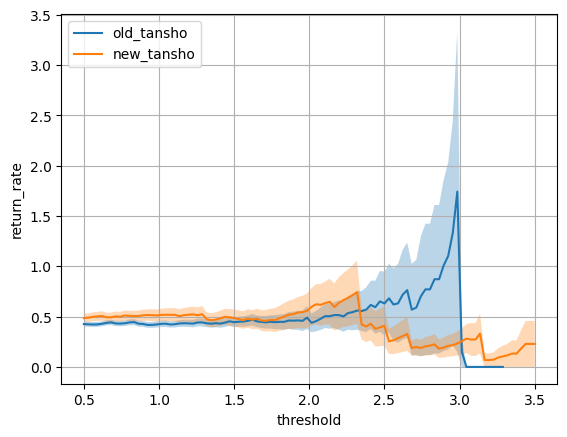

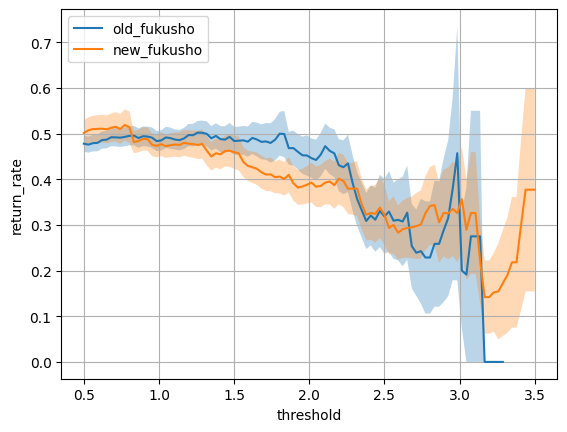

In [64]:
# 旧/新モデルの回収率カーブを重ねて表示（単勝/複勝）
# ※ plot_single_threshold_compare が前のセル群で定義済みの前提

plot_single_threshold_compare(old_tansho_df, new_tansho_df, N_SAMPLES, label1='old_tansho', label2='new_tansho')

plot_single_threshold_compare(old_fukusho_df, new_fukusho_df, N_SAMPLES, label1='old_fukusho', label2='new_fukusho')